# PROJECT CHATBOT ZAKI

## Install Dependensi

In [ ]:
import sys
!pip install faiss-cpu sentence-transformers rank-bm25 qdrant-client
!pip install transformers langchain langchain-openai supabase
!pip install tiktoken unidecode tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.3/337.3 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [ ]:
from sentence_transformers.cross_encoder import CrossEncoder

print("Memuat model Cross-Encoder untuk reranking...")
cross_encoder_model_name = 'cross-encoder/ms-marco-MiniLM-L6-v2'
cross_encoder = CrossEncoder(cross_encoder_model_name)
print(f"Model '{cross_encoder_model_name}' berhasil load")

Memuat model Cross-Encoder untuk reranking...


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Model 'cross-encoder/ms-marco-MiniLM-L6-v2' berhasil load


## Setup API KEY & Koneksi Supabase

In [ ]:
import os
import json
import re
import textwrap
import unicodedata
import pandas as pd
import numpy as np

from google.colab import userdata
from supabase import create_client, Client

print("\n--- Setup Kunci API & Koneksi DB ---")
try:
    os.environ["SUMOPOD_API_KEY"] = userdata.get('chatbot_TA')

    SUPABASE_URL = userdata.get('SUPABASE_URL')
    SUPABASE_KEY = userdata.get('SUPABASE_KEY')

    client: Client = create_client(SUPABASE_URL, SUPABASE_KEY)
    test_connection = client.table("baznas_docs").select("id").limit(1).execute()

    print("Kunci API dan koneksi Supabase berhasil")

except Exception as e:
    print(f"Terjadi kesalahan saat setup atau koneksi Supabase: {e}")


--- Setup Kunci API & Koneksi DB ---
Kunci API dan koneksi Supabase berhasil


## Load Data dari Supabase

In [ ]:
assert client is not None, "Supabase belum terhubung."

print("load data dari Supabase...")
try:
    baznas_rows = client.table("baznas_docs").select("*").execute().data
    baznas_df = pd.DataFrame(baznas_rows)
    print(f"Berhasil load {len(baznas_df)} dokumen BAZNAS")
    print(f"Kolom baznas_docs: {list(baznas_df.columns)}")
except Exception as e:
    print(f"Gagal memuat baznas_docs: {e}")
    baznas_df = pd.DataFrame()
try:
    quran_rows = client.table("quran_zaki").select("*").execute().data
    quran_df = pd.DataFrame(quran_rows)
    print(f"Berhasil memuat {len(quran_df)} ayat Al-Qur'an")
    print(f"Kolom quran_zaki: {list(quran_df.columns)}")
except Exception as e:
    print(f" Gagal memuat quran_zaki: {e}")
    quran_df = pd.DataFrame()


load data dari Supabase...
Berhasil load 166 dokumen BAZNAS
Kolom baznas_docs: ['id', 'source_file', 'content', 'embedding']
Berhasil memuat 33 ayat Al-Qur'an
Kolom quran_zaki: ['id', 'surah_id', 'surah_latin', 'surah_translation', 'ayah', 'arabic', 'translation', 'footnotes', 'tafsir_wajiz', 'tafsir_tahlili', 'page_content', 'embedding']


## Text Chunking dengan Overlap

In [ ]:
class AdvancedTextChunker:
    def __init__(self, chunk_size=1000, chunk_overlap=200, separators=None):
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap

        if separators is None:
            self.separators = [
                "\n\n",      # Paragraph breaks
                "\n",        # Line breaks
                ". ",        # Sentence endings
                "! ",        # Exclamation
                "? ",        # Question
                "; ",        # Semicolon
                ", ",        # Comma
                " ",         # Space
                ""           # Fallback
            ]
        else:
            self.separators = separators

        # Initialize tokenizer for accurate token counting
        try:
            self.encoding = tiktoken.get_encoding("cl100k_base")
        except:
            self.encoding = None

    def count_tokens(self, text):
        """
        Count tokens menggunakan tiktoken jika tersedia
        """
        if self.encoding:
            return len(self.encoding.encode(text))
        else:
            # Fallback: estimate berdasarkan kata
            return len(text.split()) * 1.3

    def chunk_text(self, text):
        """
        Chunk teks dengan overlap dan preservasi konteks
        """
        if not text:
            return []
        if self.count_tokens(text) <= self.chunk_size:
            return [text]

        chunks = []
        current_chunk = ""
        parts = self._split_text_hierarchical(text)

        for part in parts:
            test_chunk = current_chunk + ("\n" if current_chunk else "") + part

            if self.count_tokens(test_chunk) <= self.chunk_size:
                current_chunk = test_chunk
            else:
                if current_chunk:
                    chunks.append(current_chunk.strip())
                    overlap_text = self._get_overlap_text(current_chunk)
                    current_chunk = overlap_text + ("\n" if overlap_text else "") + part
                else:
                    sub_chunks = self._force_split_large_text(part)
                    chunks.extend(sub_chunks[:-1])
                    current_chunk = sub_chunks[-1] if sub_chunks else ""

        if current_chunk:
            chunks.append(current_chunk.strip())

        return chunks

    def _split_text_hierarchical(self, text):
        """
        Split teks secara hierarkis menggunakan separator
        """
        parts = [text]

        for separator in self.separators:
            new_parts = []
            for part in parts:
                if self.count_tokens(part) > self.chunk_size:
                    if separator in part:
                        split_parts = part.split(separator)
                        for i, split_part in enumerate(split_parts):
                            if i < len(split_parts) - 1:
                                split_part += separator
                            new_parts.append(split_part)
                    else:
                        new_parts.append(part)
                else:
                    new_parts.append(part)
            parts = new_parts

        return [part for part in parts if part.strip()]

    def _get_overlap_text(self, text):
        """
        Ambil bagian akhir teks untuk overlap
        """
        if not text:
            return ""

        words = text.split()
        if len(words) <= 10:
            return text
        overlap_words = words[-min(50, len(words) // 4):]
        overlap_text = " ".join(overlap_words)
        while self.count_tokens(overlap_text) > self.chunk_overlap and len(overlap_words) > 1:
            overlap_words = overlap_words[1:]
            overlap_text = " ".join(overlap_words)

        return overlap_text

    def _force_split_large_text(self, text):
        """
        Force split untuk teks yang terlalu besar
        """
        if not text:
            return []

        chunks = []
        words = text.split()
        current_words = []

        for word in words:
            test_chunk = " ".join(current_words + [word])

            if self.count_tokens(test_chunk) <= self.chunk_size:
                current_words.append(word)
            else:
                if current_words:
                    chunks.append(" ".join(current_words))
                current_words = [word]

        if current_words:
            chunks.append(" ".join(current_words))

        return chunks

# Inisialisasi chunker
chunker = AdvancedTextChunker(chunk_size=1000, chunk_overlap=200)

## System State Management dengan Supabase Storage

In [ ]:

import pickle
import os
from datetime import datetime
import json

def save_state_to_supabase():
    """Simpan system state dengan error handling untuk RLS"""
    try:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        faiss_filename = f"zaki_faiss_index_{timestamp}.bin"
        faiss.write_index(faiss_index, faiss_filename)

        state_data = {
            'embeddings': embeddings,
            'all_docs': all_docs,
            'all_metadata': all_metadata,
            'bm25_index': bm25_index,
            'ground_truth': ground_truth,
            'timestamp': timestamp,
            'total_docs': len(all_docs),
            'embedding_shape': embeddings.shape
        }

        state_filename = f"zaki_system_state_{timestamp}.pkl"
        with open(state_filename, 'wb') as f:
            pickle.dump(state_data, f)

        simpan metadata ke database (dengan fallback)
        metadata_record = {
            'timestamp': timestamp,
            'faiss_filename': faiss_filename,
            'state_filename': state_filename,
            'total_docs': len(all_docs),
            'embedding_dimension': embeddings.shape[1] if embeddings.size > 0 else 0,
            'file_size_faiss': os.path.getsize(faiss_filename),
            'file_size_state': os.path.getsize(state_filename),
            'created_at': datetime.now().isoformat()
        }

        try:
            client.table("zaki_system_states").insert(metadata_record).execute()
            print("Metadata berhasil disimpan ke database")
        except Exception as db_error:
            print(f"Warning: Gagal simpan metadata ke database: {db_error}")
            print("File state berhasil disimpan secara lokal")

            metadata_filename = f"metadata_{timestamp}.json"
            with open(metadata_filename, 'w') as f:
                json.dump(metadata_record, f, indent=2)
            print(f"Metadata disimpan ke file lokal: {metadata_filename}")

        print(f"System state berhasil disimpan:")
        print(f"  - FAISS Index: {faiss_filename}")
        print(f"  - System State: {state_filename}")
        print(f"  - Total docs: {len(all_docs)}")
        print(f"  - Embedding dimension: {embeddings.shape[1]}")

        return timestamp

    except Exception as e:
        print(f"Error saving state: {e}")
        return None

def load_state_from_local(timestamp=None):
    """Load system state dari file lokal"""
    global embeddings, all_docs, all_metadata, faiss_index, bm25_index, ground_truth

    try:
        if timestamp is None:
            import glob
            state_files = glob.glob("zaki_system_state_*.pkl")
            if not state_files:
                return False
            state_files.sort(reverse=True)
            state_filename = state_files[0]
            faiss_filename = state_filename.replace("zaki_system_state_", "zaki_faiss_index_").replace(".pkl", ".bin")
        else:
            faiss_filename = f"zaki_faiss_index_{timestamp}.bin"
            state_filename = f"zaki_system_state_{timestamp}.pkl"

        if os.path.exists(faiss_filename):
            faiss_index = faiss.read_index(faiss_filename)
        else:
            print(f"File FAISS tidak ditemukan: {faiss_filename}")
            return False
        if os.path.exists(state_filename):
            with open(state_filename, 'rb') as f:
                state_data = pickle.load(f)
        else:
            print(f"File state tidak ditemukan: {state_filename}")
            return False
        embeddings = state_data['embeddings']
        all_docs = state_data['all_docs']
        all_metadata = state_data['all_metadata']
        bm25_index = state_data['bm25_index']
        ground_truth = state_data.get('ground_truth', create_ground_truth())

        print(f"System state berhasil dimuat dari file lokal:")
        print(f"  - Total docs: {len(all_docs)}")
        print(f"  - FAISS index: {faiss_index.ntotal} vectors")
        print(f"  - Embedding shape: {embeddings.shape}")

        return True

    except Exception as e:
        print(f"Error loading state: {e}")
        return False

def auto_load_system_state():
    """Auto-load system state dengan fallback ke lokal"""
    print("Checking for existing system state...")

    if load_state_from_local():
        print("System state loaded successfully from local files!")
        return True
    else:
        print("No existing state found. Build new index required.")
        return False

print("=== System State Management ===")
state_loaded = auto_load_system_state()

## Ground Truth

In [ ]:
def create_ground_truth():
    """
    Membuat ground truth berdasarkan data aktual dari Supabase
    """

    ground_truth = {
    0: ['BAZNAS_1'], # 1. Apa tujuan utama dari ditetapkannya Peraturan BAZNAS Nomor 2 Tahun 2019?
    1: ['BAZNAS_1'], # 2. Sebutkan Undang-Undang yang menjadi landasan hukum dari Peraturan BAZNAS Nomor 2 Tahun 2019.
    2: ['BAZNAS_6'], # 3. Siapakah Ketua BAZNAS RI yang menetapkan Peraturan BAZNAS Nomor 2 Tahun 2019?
    3: ['BAZNAS_6'], # 4. Kapan Peraturan BAZNAS Nomor 2 Tahun 2019 mulai berlaku?
    4: ['BAZNAS_2'], # 5. Apa perbedaan antara BAZNAS, BAZNAS Provinsi, dan BAZNAS Kabupaten/Kota menurut Peraturan BAZNAS No. 2 Tahun 2019?
    5: ['BAZNAS_2'], # 6. Jelaskan definisi "Zakat" berdasarkan Pasal 1 Peraturan BAZNAS Nomor 2 Tahun 2019.
    6: ['BAZNAS_2'], # 7. Apa yang dimaksud dengan "Pengelolaan Zakat" dalam Peraturan BAZNAS No. 2 Tahun 2019?
    7: ['BAZNAS_2'], # 8. Siapakah yang disebut sebagai "Muzaki" dan "Mustahik" dalam Peraturan BAZNAS No. 2 Tahun 2019?
    8: ['BAZNAS_2'], # 9. Apa tugas dari Lembaga Amil Zakat (LAZ) menurut Peraturan BAZNAS No. 2 Tahun 2019?
    9: ['BAZNAS_2'], # 10. Jelaskan apa itu "Amil Zakat" menurut Peraturan BAZNAS No. 2 Tahun 2019.
    10: ['BAZNAS_2', 'BAZNAS_5'], # 11. Apa definisi dari "Rapat Pleno" dalam konteks Peraturan BAZNAS No. 2 Tahun 2019?
    11: ['BAZNAS_2'], # 12. Apa fungsi dari Unit Pengumpul Zakat (UPZ) menurut Peraturan BAZNAS No. 2 Tahun 2019?
    12: ['BAZNAS_3'], # 13. Sebutkan empat fungsi utama BAZNAS dalam pengelolaan zakat seperti yang dijelaskan dalam Peraturan BAZNAS No. 2 Tahun 2019.
    13: ['BAZNAS_3'], # 14. Dari unsur apa saja pimpinan BAZNAS Provinsi dan Kabupaten/Kota berasal menurut Peraturan BAZNAS No. 2 Tahun 2019?
    14: ['BAZNAS_3'], # 15. Sebutkan lima posisi dalam unsur pimpinan BAZNAS sesuai Peraturan BAZNAS No. 2 Tahun 2019.
    15: ['BAZNAS_4'], # 16. Apa tugas pokok Ketua BAZNAS Provinsi atau Kabupaten/Kota menurut Peraturan BAZNAS No. 2 Tahun 2019?
    16: ['BAZNAS_4'], # 17. Wakil Ketua mana yang bertanggung jawab atas pengelolaan pengumpulan zakat menurut Peraturan BAZNAS No. 2 Tahun 2019?
    17: ['BAZNAS_4'], # 18. Sebutkan tiga wewenang dari Wakil Ketua I terkait pengumpulan zakat dalam Peraturan BAZNAS No. 2 Tahun 2019.
    18: ['BAZNAS_4'], # 19. Siapa yang bertugas mengelola dan mengembangkan data Mustahik menurut Peraturan BAZNAS No. 2 Tahun 2019?
    19: ['BAZNAS_4'], # 20. Wakil Ketua mana yang menyusun laporan keuangan menurut Peraturan BAZNAS No. 2 Tahun 2019?
    20: ['BAZNAS_4'], # 21. Jelaskan tugas utama dari Wakil Ketua III menurut Peraturan BAZNAS No. 2 Tahun 2019.
    21: ['BAZNAS_4'], # 22. Siapa yang bertanggung jawab atas pengelolaan sumber daya Amil Zakat sesuai Peraturan BAZNAS No. 2 Tahun 2019?
    22: ['BAZNAS_4'], # 23. Sebutkan tugas Wakil Ketua IV terkait administrasi dan SDM berdasarkan Peraturan BAZNAS No. 2 Tahun 2019.
    23: ['BAZNAS_4'], # 24. Siapa yang berwenang memberikan rekomendasi untuk pembukaan perwakilan LAZ di daerah menurut Peraturan BAZNAS No. 2 Tahun 2019?
    24: ['BAZNAS_4'], # 25. Apa solusi yang diatur dalam Peraturan BAZNAS No. 2 Tahun 2019 jika jumlah Wakil Ketua kurang dari yang ditetapkan?
    25: ['BAZNAS_5'], # 26. Berapa kuorum yang diperlukan agar Rapat Pleno dianggap sah menurut Peraturan BAZNAS No. 2 Tahun 2019?
    26: ['BAZNAS_5'], # 27. Siapa yang memimpin Rapat Pleno menurut Peraturan BAZNAS No. 2 Tahun 2019?
    27: ['BAZNAS_5'], # 28. Bagaimana keputusan diambil dalam Rapat Pleno jika musyawarah tidak mufakat, sesuai Peraturan BAZNAS No. 2 Tahun 2019?
    28: ['BAZNAS_5'], # 29. Seberapa sering Rapat Pleno harus dilaksanakan menurut Peraturan BAZNAS No. 2 Tahun 2019?
    29: ['BAZNAS_3', 'BAZNAS_4'], # 30. Jelaskan struktur organisasi dan pembagian tugas pimpinan BAZNAS di tingkat daerah sesuai Peraturan BAZNAS Nomor 2 Tahun 2019.
    30: ['BAZNAS_11'], # 31. Bagaimana BAZNAS dapat berperan aktif dalam perencanaan pembangunan nasional?
    31: ['BAZNAS_7'],  # 32. Sebutkan dasar hukum dari UU No. 25 Tahun 2004...
    32: ['BAZNAS_8'],  # 33. Apa saja tahapan dalam perencanaan pembangunan nasional menurut PP No. 17 Tahun 2017?
    33: ['BAZNAS_9'],  # 34. Sebutkan minimal lima komponen dalam sistematika penulisan RPJMD.
    34: ['BAZNAS_10'], # 35. Kegiatan apa yang dijadwalkan pada bulan April dalam perencanaan nasional?
    35: ['BAZNAS_11'], # 36. Melalui kegiatan apa BAZNAS dapat berpartisipasi? (Musrenbang)
    36: ['BAZNAS_11'], # 37. Apa tujuan Rakornas BAZNAS pada bulan Januari?
    37: ['BAZNAS_11'], # 38. Sebutkan kebijakan prioritas terkait zakat aparatur negara.
    38: ['BAZNAS_11'], # 39. Apa 3 prinsip "Aman" dalam sinergi program penyaluran ZIS-DSKL?
    39: ['BAZNAS_11'], # 40. Kapan RKAT BAZNAS ditetapkan dan disahkan?
    40: ['BAZNAS_8'],  # 41. Apa saja yang harus dimuat dalam Rancangan Renstra-KL menurut PP No. 40/2006?
    41: ['BAZNAS_9'],  # 42. Apa perbedaan sistematika penulisan antara RPJPD dan RPJMD?
    42: ['BAZNAS_10'], # 43. Bagaimana program pembangunan daerah diintegrasikan dengan program pusat?
    43: ['BAZNAS_11'], # 44. Kapan BAZNAS menyusun kerangka ekonomi zakat?
    44: ['BAZNAS_9', 'BAZNAS_10'], # 45. Sebutkan dua dasar hukum yang mengatur Rencana Pembangunan Daerah.
    45: ['BAZNAS_13'], # 46. Berapa lama masa kerja Pimpinan BAZNAS?
    46: ['BAZNAS_13'], # 47. Bolehkah Pimpinan BAZNAS dipilih kembali?
    47: ['BAZNAS_13'], # 48. Kapan masa kerja Pimpinan BAZNAS mulai dihitung?
    48: ['BAZNAS_13'], # 49. Jika ada perbedaan tanggal, mana yang dipakai?
    49: ['BAZNAS_13'], # 50. Kapan Panitia Seleksi Calon Pimpinan BAZNAS harus dibentuk?
    50: ['BAZNAS_13'], # 51. Apa yang harus dilakukan Ketua BAZNAS provinsi saat masa kerja akan berakhir?
    51: ['BAZNAS_13'], # 52. Siapa yang ditembuskan surat pemberitahuan dari Ketua BAZNAS kab/kota?
    52: ['BAZNAS_13'], # 53. Siapa yang melakukan supervisi pergantian pimpinan BAZNAS kab/kota?
    53: ['BAZNAS_14'], # 54. Apa konsekuensi hukum bagi Pimpinan BAZNAS yang masa kerjanya habis?
    54: ['BAZNAS_14'], # 55. Apa sanksi pidana bagi amil zakat tanpa izin?
    55: ['BAZNAS_14'], # 56. Siapa Ketua BAZNAS yang menandatangani SE No. 2 Tahun 2023?
    56: ['BAZNAS_12'], # 57. Kepada siapa saja SE No. 2 Tahun 2023 ditujukan?
    57: ['BAZNAS_13'], # 58. Apa himbauan kepada Gubernur/Bupati agar tidak ada kekosongan jabatan?
    58: ['BAZNAS_12'], # 59. Sebutkan dua peraturan yang menjadi dasar hukum SE No. 2 Tahun 2023.
    59: ['BAZNAS_14'], # 60. Apa dasar hukum yang melarang amil zakat tanpa izin?
    60: ['BAZNAS_15'], # 61. Apa judul lengkap dari Surat Edaran Ketua BAZNAS Nomor 1 Tahun 2023?
    61: ['BAZNAS_15'], # 62. Sebutkan minimal tiga dasar hukum yang melandasi Surat Edaran tentang kewajiban menjaga netralitas.
    62: ['BAZNAS_15'], # 63. Apa isi dari Nota Kesepahaman antara BAZNAS dengan BAWASLU tahun 2018?
    63: ['BAZNAS_16', 'BAZNAS_18'], # 64. Jelaskan 3 (tiga) prinsip "Aman" yang wajib dilaksanakan dalam pengelolaan zakat.
    64: ['BAZNAS_16'], # 65. Apa yang dimaksud dengan prinsip "Aman NKRI" dalam pengelolaan zakat?
    65: ['BAZNAS_16'], # 66. Sebutkan tiga contoh kegiatan politik praktis yang dilarang bagi Pimpinan dan Amil BAZNAS.
    66: ['BAZNAS_16'], # 67. Apa yang harus dilakukan oleh seorang Amil Pelaksana LAZ jika ia ingin mencalonkan diri?
    67: ['BAZNAS_16', 'BAZNAS_18'], # 68. Siapa saja yang diwajibkan untuk menjaga netralitas?
    68: ['BAZNAS_17'], # 69. Kemana pelanggaran netralitas harus dilaporkan?
    69: ['BAZNAS_17'], # 70. Berdasarkan peraturan mana penyelesaian pelanggaran kode etik dilaksanakan?
    70: ['BAZNAS_18'], # 71. Sanksi apa yang dapat dikenakan kepada Amil Zakat yang melanggar dan tidak mengundurkan diri?
    71: ['BAZNAS_18'], # 72. Sebutkan dua kewajiban Pimpinan BAZNAS di bagian Penutup Surat Edaran.
    72: ['BAZNAS_18'], # 73. Siapakah Ketua BAZNAS yang menandatangani Surat Edaran Nomor 1 Tahun 2023?
    73: ['BAZNAS_18'], # 74. Kapan Surat Edaran tentang Kewajiban Menjaga Netralitas ditetapkan?
    74: ['BAZNAS_18'], # 75. Siapa saja yang menerima tembusan dari Surat Edaran ini?
    75: ['BAZNAS_19'], # 76. Apa alasan utama dibuatnya Peraturan Ketua BAZNAS No. 5 Tahun 2024?
    76: ['BAZNAS_20'], # 77. Jelaskan definisi dari "Aplikasi Menara Masjid" dan "SiMBA".
    77: ['BAZNAS_21'], # 78. Siapa saja yang menjadi ruang lingkup pedoman Aplikasi Menara Masjid?
    78: ['BAZNAS_23'], # 79. Data transaksi apa saja yang wajib dicatat oleh masjid?
    79: ['BAZNAS_24'], # 80. BAZNAS provinsi mengelola data dari jenis masjid apa saja?
    80: ['BAZNAS_24'], # 81. Apa perbedaan antara "masjid agung" dan "masjid raya"?
    81: ['BAZNAS_25'], # 82. Melalui sistem apa BAZNAS mendaftarkan masjid UPZ?
    82: ['BAZNAS_25'], # 83. Sebutkan tiga langkah dalam proses registrasi masjid melalui SiMBA.
    83: ['BAZNAS_26', 'BAZNAS_28'], # 84. Jelaskan perbedaan dana "di dalam neraca" dan "di luar neraca".
    84: ['BAZNAS_26'], # 85. Sebutkan tiga tanggung jawab BAZNAS dalam mengelola data ZIS-DSKL di masjid.
    85: ['BAZNAS_27'], # 86. Apakah penggunaan Aplikasi Menara Masjid wajib bagi semua masjid?
    86: ['BAZNAS_28'], # 87. Bagaimana status data dari Aplikasi Menara Masjid pada neraca BAZNAS?
    87: ['BAZNAS_29'], # 88. Bagaimana BAZNAS melakukan pembinaan dan pengawasan?
    88: ['BAZNAS_30'], # 89. Berapa lama batas waktu bagi masjid non-UPZ untuk mendaftar sebagai UPZ?
    89: ['BAZNAS_31'], # 90. Kapan Peraturan Ketua BAZNAS No. 5 Tahun 2024 ini mulai berlaku?
    90: ['BAZNAS_32'], # 91. Apa tujuan utama dari Peraturan Menteri Agama Nomor 19 Tahun 2024 tentang LAZ?
    91: ['BAZNAS_32'], # 92. Sebutkan UU tentang Pengelolaan Zakat yang menjadi dasar hukum PMA No. 19 Tahun 2024.
    92: ['BAZNAS_33'], # 93. Siapa yang dapat membentuk LAZ untuk membantu BAZNAS?
    93: ['BAZNAS_33'], # 94. Sebutkan tiga tingkatan skala LAZ.
    94: ['BAZNAS_33'], # 95. Siapa pejabat yang berwenang memberikan izin untuk LAZ berskala nasional?
    95: ['BAZNAS_33'], # 96. Siapa yang memberikan izin untuk LAZ berskala provinsi dan kabupaten/kota?
    96: ['BAZNAS_33'], # 97. Organisasi kemasyarakatan Islam yang bergerak di bidang apa saja yang dapat membentuk LAZ?
    97: ['BAZNAS_33'], # 98. Bentuk badan hukum apa yang dapat mendirikan LAZ?
    98: ['BAZNAS_34'], # 99. Bagaimana status izin LAZ yang telah ada sebelum PMA No. 19 Tahun 2024 berlaku?
    99: ['BAZNAS_34'], # 100. Bagaimana proses perpanjangan izin LAZ yang sedang berjalan saat peraturan ini berlaku?
    100: ['BAZNAS_34'],# 101. Kapan Peraturan Menteri Agama Nomor 19 Tahun 2024 mulai berlaku?
    101: ['BAZNAS_33'],# 102. Apa fungsi LAZ menurut Pasal 2 Peraturan Menteri Agama Nomor 19 Tahun 2024?
    102: ['BAZNAS_35'], # 103. Apa alasan utama Peraturan BAZNAS No. 4 Tahun 2018 diganti?
    103: ['BAZNAS_37'], # 104. Apa saja yang termasuk dalam DSKL menurut Pasal 3?
    104: ['BAZNAS_36', 'BAZNAS_38'], # 105. Jelaskan perbedaan antara "SiMBA" dan "SiMBALITE".
    105: ['BAZNAS_37'], # 106. Siapa saja yang wajib menyusun laporan pengelolaan ZIS?
    106: ['BAZNAS_37'], # 107. Sebutkan dua jenis laporan periodik yang wajib disusun.
    107: ['BAZNAS_37'], # 108. Apa yang dimaksud dengan "laporan akhir tahun"?
    108: ['BAZNAS_37'], # 109. Apa saja tiga komponen laporan 6 bulanan BAZNAS Provinsi?
    109: ['BAZNAS_38'], # 110. Sistem informasi apa yang digunakan untuk pelaporan nasional?
    110: ['BAZNAS_38'], # 111. Sebutkan dua cara penggunaan aplikasi SiMBA.
    111: ['BAZNAS_38'], # 112. Kapan SiMBALITE dapat digunakan?
    112: ['BAZNAS_39'], # 113. Siapa yang bertanggung jawab melakukan pembinaan kepada LAZ?
    113: ['BAZNAS_39'], # 114. Sebutkan tiga bentuk pembinaan terkait pelaporan.
    114: ['BAZNAS_39'], # 115. Apa yang terjadi pada Peraturan BAZNAS No. 4 Tahun 2018?
    115: ['BAZNAS_39'], # 116. Berapa lama batas waktu penyesuaian sistem pelaporan?
    116: ['BAZNAS_38'], # 117. Siapa saja yang harus menyediakan infrastruktur TI minimum?
    117: ['BAZNAS_40'], # 118. Apa tujuan Peraturan BAZNAS tentang Tata Cara Permohonan Rekomendasi Izin LAZ?
    118: ['BAZNAS_42'], # 119. Sebutkan 7 syarat untuk mendapatkan izin pembentukan LAZ.
    119: ['BAZNAS_42'], # 120. Apa saja tiga tingkatan skala LAZ?
    120: ['BAZNAS_42'], # 121. LAZ harus mendapat rekomendasi dari lembaga apa?
    121: ['BAZNAS_43'], # 122. Berapa jumlah minimal pegawai LAZ berskala nasional?
    122: ['BAZNAS_43'], # 123. Berapa jumlah minimal dana ZIS-DSKL yang sanggup dikumpulkan LAZ provinsi per tahun?
    123: ['BAZNAS_43'], # 124. Berapa jumlah minimal pegawai LAZ berskala kabupaten/kota?
    124: ['BAZNAS_44'], # 125. Apa saja dua jenis verifikasi yang dilakukan BAZNAS?
    125: ['BAZNAS_44'], # 126. Berapa lama masa berlaku izin pembentukan LAZ?
    126: ['BAZNAS_44'], # 127. Kapan permohonan perpanjangan izin LAZ harus diajukan?
    127: ['BAZNAS_44'], # 128. Siapa yang memberikan izin perpanjangan untuk LAZ berskala nasional?
    128: ['BAZNAS_44'], # 129. Sebutkan dua laporan yang harus dilampirkan saat mengajukan perpanjangan izin LAZ.
    129: ['BAZNAS_44'], # 130. Berapa lama proses penyelesaian rekomendasi izin perpanjangan LAZ?
    130: ['BAZNAS_45'], # 131. Di mana LAZ berskala nasional dapat membuka perwakilan?
    131: ['BAZNAS_45'], # 132. Siapa yang memberikan izin pembukaan perwakilan LAZ berskala provinsi?
    132: ['BAZNAS_46'], # 133. Siapa yang melakukan verifikasi untuk rekomendasi pembukaan perwakilan LAZ nasional?
    133: ['BAZNAS_46'], # 134. Berapa lama proses penyelesaian rekomendasi izin pembukaan perwakilan LAZ?
    134: ['BAZNAS_47'], # 135. Kapan permohonan perpanjangan izin perwakilan LAZ harus diajukan?
    135: ['BAZNAS_47'], # 136. Sebutkan dua dokumen wajib untuk perpanjangan izin perwakilan LAZ.
    136: ['BAZNAS_48'], # 137. Bagaimana status rekomendasi izin LAZ yang sudah terbit sebelum peraturan ini berlaku?
    137: ['BAZNAS_50'], # 138. Apa tujuan utama Peraturan BAZNAS No. 5 Tahun 2018?
    138: ['BAZNAS_51'], # 139. Apa saja 6 lingkup pengaturan dalam peraturan ini?
    139: ['BAZNAS_51'], # 140. Apa yang dimaksud dengan "Hak Amil"?
    140: ['BAZNAS_51'], # 141. Apa definisi dari RKAT?
    141: ['BAZNAS_52'], # 142. Bentuk apa yang digunakan untuk penyusunan anggaran?
    142: ['BAZNAS_53'], # 143. Sebutkan tiga sumber penerimaan dana selain ZIS.
    143: ['BAZNAS_53'], # 144. Bagaimana jika tidak ada perbankan syariah?
    144: ['BAZNAS_53'], # 145. Penerimaan dana Zakat bisa berupa apa saja selain uang?
    145: ['BAZNAS_53'], # 146. Kapan dana Zakat harus disetorkan ke bank?
    146: ['BAZNAS_53'], # 147. Sebutkan lima informasi dalam bukti setor loket.
    147: ['BAZNAS_53'], # 148. Apa perbedaan kas besar dan kas kecil?
    148: ['BAZNAS_53'], # 149. Bagaimana pengeluaran dana jika Mustahik tidak punya rekening?
    149: ['BAZNAS_54'], # 150. Siapa yang wajib melakukan pengendalian keuangan?
    150: ['BAZNAS_54'], # 151. Sebutkan tiga objek pengendalian keuangan.
    151: ['BAZNAS_55'], # 152. Sebutkan empat tahapan prosedur pembukuan penerimaan.
    152: ['BAZNAS_55'], # 153. Seberapa sering Laporan Keuangan harus disusun?
    153: ['BAZNAS_55'], # 154. Apa saja lima komponen laporan keuangan akhir tahun?
    154: ['BAZNAS_56'], # 155. Apa saja tiga jenis kode akun laporan posisi keuangan?
    155: ['BAZNAS_57'], # 156. Berapa lama waktu penyesuaian pengelolaan keuangan?
    156: ['BAZNAS_58'], # 157. Siapa Ketua BAZNAS yang menandatangani Peraturan No. 5 Tahun 2018?
    157: ['BAZNAS_59'], # 158. Apa tujuan Peraturan BAZNAS No. 4 Tahun 2018?
    158: ['BAZNAS_61'], # 159. Sebutkan dua jenis laporan periodik yang wajib dibuat.
    159: ['BAZNAS_61'], # 160. Apa saja tiga jenis laporan pengelolaan zakat secara umum?
    160: ['BAZNAS_61'], # 161. Periode waktu apa yang dicakup laporan 6 bulan?
    161: ['BAZNAS_61'], # 162. Apa saja komponen laporan 6 bulanan BAZNAS Provinsi?
    162: ['BAZNAS_61'], # 163. Apa perbedaan komponen laporan 6 bulanan BAZNAS Kab/Kota dengan LAZ Nasional?
    163: ['BAZNAS_61'], # 164. Kapan batas waktu BAZNAS Provinsi menyampaikan laporan 6 bulanan?
    164: ['BAZNAS_61'], # 165. Kepada siapa saja BAZNAS Kab/Kota harus menyampaikan laporan 6 bulanan?
    165: ['BAZNAS_61'], # 166. Kapan batas waktu paling lambat LAZ Kab/Kota menyampaikan laporan 6 bulanan?
    166: ['BAZNAS_61', 'BAZNAS_62'], # 167. Apa beda laporan keuangan akhir tahun dengan laporan 6 bulanan?
    167: ['BAZNAS_62'], # 168. Apa yang dilakukan jika tidak bisa menyampaikan laporan keuangan yang diaudit?
    168: ['BAZNAS_62'], # 169. Kapan batas waktu BAZNAS menyampaikan laporan akhir tahun ke Menteri Agama?
    169: ['BAZNAS_62'], # 170. Kepada siapa saja LAZ Provinsi harus menyampaikan laporan akhir tahun?
    170: ['BAZNAS_62'], # 171. Kapan batas waktu paling lambat Perwakilan LAZ Provinsi menyampaikan laporan akhir tahun?
    171: ['BAZNAS_63'], # 172. Sanksi apa yang dikenakan jika tidak menyampaikan laporan?
    172: ['BAZNAS_70', 'BAZNAS_72'], # 173. Apa tujuan utama Peraturan BAZNAS No. 1 Tahun 2018?
    173: ['BAZNAS_71'], # 174. Apa yang dimaksud dengan "Kode Etik Amil Zakat"?
    174: ['BAZNAS_71'], # 175. Siapa "Terlapor" dan "Pelapor" dalam konteks pelanggaran kode etik?
    175: ['BAZNAS_72'], # 176. Sebutkan tiga dari lima tujuan Kode Etik Amil Zakat.
    176: ['BAZNAS_73'], # 177. Sebutkan lima dari sembilan nilai dasar Amil Zakat.
    177: ['BAZNAS_73'], # 178. Apa saja landasan etika dari Kode Etik Amil Zakat?
    178: ['BAZNAS_73'], # 179. Sebutkan tujuh asas pedoman Amil Zakat.
    179: ['BAZNAS_74'], # 180. Apa dua larangan bagi Amil Zakat dalam asas syariat Islam?
    180: ['BAZNAS_74'], # 181. Sebutkan tiga larangan bagi Amil Zakat terkait asas amanah dan integritas.
    181: ['BAZNAS_74'], # 182. Apa kewajiban Amil Zakat dalam asas kemanfaatan?
    182: ['BAZNAS_74'], # 183. Apa larangan bagi Amil Zakat dalam asas keadilan?
    183: ['BAZNAS_74'], # 184. Sebutkan tiga kewajiban Amil Zakat dalam asas akuntabilitas.
    184: ['BAZNAS_74'], # 185. Sebutkan tiga larangan bagi Amil Zakat dalam asas profesionalitas.
    185: ['BAZNAS_75'], # 186. Apa saja tiga tingkatan pelanggaran Kode Etik?
    186: ['BAZNAS_76'], # 187. Komite Etik BAZNAS Provinsi berwenang memeriksa siapa saja?
    187: ['BAZNAS_76'], # 188. Sebutkan tiga syarat menjadi anggota Komite Etik.
    188: ['BAZNAS_76'], # 189. Apa saja tiga kewenangan Komite Etik?
    189: ['BAZNAS_77'], # 190. Apa saja dua alat bukti dalam laporan dugaan pelanggaran?
    190: ['BAZNAS_78'], # 191. Berapa lama batas waktu melengkapi kekurangan dokumen laporan?
    191: ['BAZNAS_80'], # 192. Berapa lama waktu penetapan putusan setelah sidang selesai?
    192: ['BAZNAS_89'], # 193. Apa tujuan dari pengelolaan zakat menurut UU No. 23 Tahun 2011?
    193: ['BAZNAS_89'], # 194. Sebutkan tujuh asas yang menjadi dasar pengelolaan zakat.
    194: ['BAZNAS_89'], # 195. Apa saja yang termasuk dalam kategori zakat mal menurut Pasal 4 UU ini?
    195: ['BAZNAS_90'], # 196. Apa status kelembagaan BAZNAS dan kepada siapa BAZNAS bertanggung jawab?
    196: ['BAZNAS_90'], # 197. Sebutkan empat fungsi utama yang diselenggarakan oleh BAZNAS.
    197: ['BAZNAS_90'], # 198. Berapa jumlah anggota BAZNAS dan bagaimana komposisinya?
    198: ['BAZNAS_90'], # 199. Berapa lama masa kerja anggota BAZNAS dan apakah dapat dipilih kembali?
    199: ['BAZNAS_90'], # 200. Sebutkan lima dari sembilan syarat menjadi anggota BAZNAS.
    200: ['BAZNAS_90'], # 201. Siapa yang membentuk BAZNAS provinsi dan kabupaten/kota?
    201: ['BAZNAS_90'], # 202. Di mana saja BAZNAS dapat membentuk UPZ?
    202: ['BAZNAS_90'], # 203. Sebutkan lima dari delapan syarat pembentukan LAZ.
    203: ['BAZNAS_91'], # 204. Apa yang dapat dilakukan muzaki jika tidak bisa menghitung zakatnya?
    204: ['BAZNAS_91'], # 205. Apa manfaat membayar zakat ke BAZNAS/LAZ terkait pajak?
    205: ['BAZNAS_91'], # 206. Zakat didistribusikan berdasarkan prinsip apa saja?
    206: ['BAZNAS_91'], # 207. Kapan zakat dapat didayagunakan untuk usaha produktif?
    207: ['BAZNAS_91'], # 208. Bagaimana pengelolaan infak, sedekah, dan DSKL harus dicatat?
    208: ['BAZNAS_92'], # 209. Dari sumber apa saja BAZNAS pusat dibiayai?
    209: ['BAZNAS_92'], # 210. Dari mana sumber pembiayaan BAZNAS provinsi dan kabupaten/kota?
    210: ['BAZNAS_93'], # 211. Siapa yang bertugas melaksanakan pembinaan dan pengawasan?
    211: ['BAZNAS_94'], # 212. Bagaimana masyarakat dapat berperan serta dalam pengawasan?
    212: ['BAZNAS_95'], # 213. Sebutkan tiga jenis sanksi administratif.
    213: ['BAZNAS_96'], # 214. Apa larangan bagi amil zakat tanpa izin?
    214: ['BAZNAS_97'], # 215. Apa sanksi pidana bagi yang tidak mendistribusikan zakat?
    215: ['BAZNAS_98'], # 216. Apa yang terjadi pada LAZ yang telah ada sebelum UU ini berlaku?
    216: ['BAZNAS_99'], # 217. Bagaimana status UU No. 38 Tahun 1999 setelah UU ini berlaku?
    }

    return ground_truth

def validate_ground_truth(ground_truth, all_metadata):
    """
    Validasi ground truth yang menggunakan string-based ID terhadap metadata.
    Fungsi ini memeriksa apakah setiap doc_id di ground_truth ada di all_metadata.
    """
    print("Memvalidasi ground truth dengan ID berbasis string...")
    try:
        valid_doc_ids = {meta['id'] for meta in all_metadata if 'id' in meta}
        if not valid_doc_ids:
            print("Peringatan: Tidak ada 'id' yang ditemukan di all_metadata. Validasi tidak dapat dilakukan.")
            return
    except (TypeError, KeyError):
        print("Error: 'all_metadata' sepertinya bukan list of dictionaries yang berisi key 'id'. Validasi dibatalkan.")
        return

    # Iterasi melalui ground_truth dan periksa keberadaan setiap doc_id.
    invalid_ids_found = False
    for query_id, doc_ids in ground_truth.items():
        for doc_id in doc_ids:
            if doc_id not in valid_doc_ids:
                print(f"Peringatan: Query {query_id} memiliki doc_id '{doc_id}' yang TIDAK DITEMUKAN dalam daftar dokumen.")
                invalid_ids_found = True

    if not invalid_ids_found:
        print("Semua doc_id dalam ground truth valid dan ditemukan dalam daftar dokumen.")

    print(f"Ground truth berisi {len(ground_truth)} query dengan total {sum(len(docs) for docs in ground_truth.values())} dokumen relevan.")

# Load ground truth
ground_truth = create_ground_truth()

## Preprocessing & Text Normalization

In [ ]:
def normalize_text(text):
    """Normalisasi teks untuk konsistensi"""
    if pd.isna(text):
        return ""
    text = str(text)
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def create_document_text(row, doc_type="baznas"):
    """Membuat teks dokumen yang konsisten dengan pengayaan referensi"""
    if doc_type == "baznas":
        content = normalize_text(row.get("content", ""))
        source = normalize_text(row.get("source_file", ""))
        return f"{content}\n[Sumber: {source}]"

    elif doc_type == "quran":
        surah = normalize_text(row.get("surah_latin", ""))
        ayah = str(row.get("ayah", ""))
        arabic = normalize_text(row.get("arabic", ""))
        translation = normalize_text(row.get("translation", ""))
        tafsir_wajiz = normalize_text(row.get("tafsir_wajiz", ""))
        tafsir_tahlili = normalize_text(row.get("tafsir_tahlili", ""))

        doc_text = f"QS. {surah}:{ayah}\n"
        doc_text += f"Arab: {arabic}\n"
        doc_text += f"Terjemahan: {translation}\n"
        if tafsir_wajiz:
            doc_text += f"Tafsir Wajiz: {tafsir_wajiz}\n"
        if tafsir_tahlili:
            doc_text += f"Tafsir Tahlili: {tafsir_tahlili}\n"

        return doc_text

    return ""

# Proses data BAZNAS
if not baznas_df.empty:
    baznas_df["doc_text"] = baznas_df.apply(
        lambda row: create_document_text(row, "baznas"), axis=1
    )
    baznas_df["doc_type"] = "baznas"
    baznas_df["metadata"] = baznas_df.apply(
        lambda row: {
            "id": row.get("id"),
            "source_file": row.get("source_file", ""),
            "doc_type": "baznas"
        }, axis=1
    )
    print(f"{len(baznas_df)} dokumen BAZNAS siap")

if not quran_df.empty:
    quran_df["doc_text"] = quran_df.apply(
        lambda row: create_document_text(row, "quran"), axis=1
    )
    quran_df["doc_type"] = "quran"
    quran_df["metadata"] = quran_df.apply(
        lambda row: {
            "id": row.get("id"),
            "surah_latin": row.get("surah_latin", ""),
            "ayah": row.get("ayah", ""),
            "tafsir_wajiz": row.get("tafsir_wajiz", ""),
            "tafsir_tahlili": row.get("tafsir_tahlili", ""),
            "doc_type": "quran"
        }, axis=1
    )
    print(f"{len(quran_df)} ayat Al-Qur'an siap")

print("Preprocessing selesai.")


166 dokumen BAZNAS siap
33 ayat Al-Qur'an siap
Preprocessing selesai.


## Setup Embedding Model & Build Indexes

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
from rank_bm25 import BM25Okapi
from tqdm.auto import tqdm

if 'state_loaded' not in globals():
    state_loaded = False
    print("state_loaded telah didefinisikan sebagai False")

print("Memuat embedding model...")
embedding_model = SentenceTransformer("indobenchmark/indobert-base-p2")

all_docs = []
all_metadata = []

if not baznas_df.empty:
    all_docs.extend(baznas_df["doc_text"].tolist())
    all_metadata.extend(baznas_df["metadata"].tolist())

if not quran_df.empty:
    all_docs.extend(quran_df["doc_text"].tolist())
    all_metadata.extend(quran_df["metadata"].tolist())

print(f"Total dokumen: {len(all_docs)}")
print("Membuat embeddings...")
embeddings = embedding_model.encode(
    all_docs,
    show_progress_bar=True,
    normalize_embeddings=True,
    batch_size=16
)
embeddings = embeddings.astype("float32")

# FAISS Index
print("Build FAISS index...")
dimension = embeddings.shape[1]
faiss_index = faiss.IndexHNSWFlat(dimension, 64)
faiss_index.hnsw.efConstruction = 200
faiss_index.add(embeddings)

# BM25 Index
print("Membangun BM25 index...")
tokenized_docs = [doc.split() for doc in all_docs]
bm25_index = BM25Okapi(tokenized_docs)

print("Semua index berhasil dibuat")

if 'all_docs' in globals():
    validate_ground_truth(ground_truth, all_metadata)
else:
    print("Ground truth siap")

# Auto-save dengan error handling
try:
    if not state_loaded:
        print("Menyimpan state...")
        save_timestamp = save_state_to_supabase()
        if save_timestamp:
            print(f"State berhasil disimpan dengan timestamp: {save_timestamp}")
            state_loaded = True
        else:
            print("Gagal menyimpan state, namun sistem tetap berfungsi")
    else:
        print("State sudah dimuat sebelumnya")
except Exception as e:
    print(f"Error dalam state management: {e}")
    print("Melanjutkan tanpa auto-save")

state_loaded telah didefinisikan sebagai False
Memuat embedding model...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Total dokumen: 199
Membuat embeddings...


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Build FAISS index...
Membangun BM25 index...
Semua index berhasil dibuat
Memvalidasi ground truth dengan ID berbasis string...
✅ Semua doc_id dalam ground truth valid dan ditemukan dalam daftar dokumen.
Ground truth berisi 217 query dengan total 226 dokumen relevan.
Menyimpan state...
Error dalam state management: name 'save_state_to_supabase' is not defined
Melanjutkan tanpa auto-save


## Inisialisasi LLM SumoPod (gpt-4.1-mini)

In [ ]:
from langchain_openai import ChatOpenAI

print("Menginisialisasi LLM SumoPod...")
llm_sumopod = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0.1,
    api_key=os.environ["SUMOPOD_API_KEY"],
    base_url="https://ai.sumopod.com/v1"
)

# Test connection
try:
    test_response = llm_sumopod.predict("Halo, apakah Anda bisa membantu?")
    print("LLM SumoPod berhasil terkoneksi")
except Exception as e:
    print(f"Gagal koneksi LLM: {e}")


Menginisialisasi LLM SumoPod...


/tmp/ipython-input-3343134017.py:13: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  test_response = llm_sumopod.predict("Halo, apakah Anda bisa membantu?")


LLM SumoPod berhasil terkoneksi


## Hybrid Retrieval (FAISS + BM25 + RRF)

In [ ]:
def hybrid_search(query, top_k=20, alpha=0.6, k_rrf=60):
    """
    Hybrid search menggunakan Dense (FAISS) + Sparse (BM25) + RRF
    """
    # Dense search
    query_embedding = embedding_model.encode([query], normalize_embeddings=True)
    query_embedding = query_embedding.astype("float32")

    distances, indices = faiss_index.search(query_embedding, top_k * 2)
    dense_results = [(idx, 1 - dist) for idx, dist in zip(indices[0], distances[0])]

    # Sparse search (BM25)
    query_tokens = query.split()
    bm25_scores = bm25_index.get_scores(query_tokens)
    sparse_results = [(idx, score) for idx, score in enumerate(bm25_scores)]
    sparse_results.sort(key=lambda x: x[1], reverse=True)
    sparse_results = sparse_results[:top_k * 2]

    # Reciprocal Rank Fusion (RRF)
    dense_ranks = {idx: rank for rank, (idx, _) in enumerate(dense_results)}
    sparse_ranks = {idx: rank for rank, (idx, _) in enumerate(sparse_results)}

    all_candidates = set(dense_ranks.keys()) | set(sparse_ranks.keys())
    fused_results = []
    for idx in all_candidates:
        dense_rank = dense_ranks.get(idx, len(dense_results))
        sparse_rank = sparse_ranks.get(idx, len(sparse_results))
        rrf_score = (alpha / (k_rrf + dense_rank)) + ((1 - alpha) / (k_rrf + sparse_rank))
        fused_results.append((idx, rrf_score))

    fused_results.sort(key=lambda x: x[1], reverse=True)

    # Return top results dengan metadata
    results = []
    for idx, score in fused_results[:top_k]:
        if idx < len(all_docs):
            results.append({
                'document_id': idx,
                "text": all_docs[idx],
                "metadata": all_metadata[idx],
                "score": score
            })
    return results

## Cross Encoder Rerank

In [ ]:
def cross_encoder_rerank(query, candidates, top_k=3):
    """
    Melakukan reranking pada dokumen kandidat menggunakan model Cross-Encoder.

    Args:
        query (str): Pertanyaan dari pengguna.
        candidates (list): Daftar dictionary dokumen dari hybrid search.
        top_k (int): Jumlah dokumen teratas yang akan dikembalikan.

    Returns:
        list: Daftar dictionary dokumen yang sudah di-rerank.
    """
    if not candidates:
        return []
    pairs = [[query, doc['text']] for doc in candidates]
    scores = cross_encoder.predict(pairs, show_progress_bar=False)
    for i in range(len(candidates)):
        candidates[i]['rerank_score'] = scores[i]
    reranked_docs = sorted(candidates, key=lambda x: x['rerank_score'], reverse=True)
    return reranked_docs[:top_k]

print("Fungsi 'cross_encoder_rerank' berhasil dibuat.")

Fungsi 'cross_encoder_rerank' berhasil dibuat.


## Guardrails Konten

In [ ]:
import re

# Regex patterns untuk validasi
QURAN_VERSE_PATTERN = re.compile(r"QS\.\s*([A-Za-z\-\s]+):\s*(\d+)")
SENSITIVE_WORDS = re.compile(
    r"\b(kafir|sesat|bid[''']ah|murtad|syirik)\b",
    re.IGNORECASE
)

def validate_quran_reference(text):
    """Validasi apakah teks mengandung referensi Al-Qur'an yang valid"""
    matches = QURAN_VERSE_PATTERN.findall(text)
    return len(matches) > 0

def filter_sensitive_content(text):
    """Filter konten sensitif"""
    if SENSITIVE_WORDS.search(text):
        return False
    return True

def apply_guardrails(generated_text, context_docs):
    """
    Terapkan guardrails pada teks yang dihasilkan
    """
    # Check for sensitive content
    if not filter_sensitive_content(generated_text):
        return "[Maaf, konten yang diminta mengandung hal sensitif dan tidak dapat ditampilkan.]"

    # Ensure Quranic reference if dealing with religious content
    has_religious_context = any(
        doc["metadata"]["doc_type"] == "quran" for doc in context_docs
    )

    if has_religious_context and not validate_quran_reference(generated_text):
        generated_text += "\n\n[Catatan: Silakan rujuk ke Al-Qur'an dan hadits untuk memahami lebih lanjut.]"

    return generated_text


## Answer Generation System

In [ ]:
def generate_answer(question, max_context_length=2000):
    """
    Generate jawaban menggunakan pipeline RAG lengkap dengan Cross-Encoder Reranker.
    """
    print(f"Mencari informasi untuk: {question}")

    # Step 1: Hybrid retrieval (tetap sama)
    candidates = hybrid_search(question, top_k=15)
    print(f"Ditemukan {len(candidates)} kandidat dokumen")

    top_docs = cross_encoder_rerank(question, candidates, top_k=3)
    # =====================================================================

    print(f"Dipilih {len(top_docs)} dokumen terbaik setelah Cross-Encoder rerank")

    # Step 3: Prepare context (tetap sama)
    context_parts = []
    references = []

    for i, doc in enumerate(top_docs, 1):
        doc_type = doc["metadata"]["doc_type"]
        if doc_type == "quran":
            surah = doc["metadata"]["surah_latin"]
            ayah = doc["metadata"]["ayah"]
            context_parts.append(f"[Dalil {i}] {doc['text']}")
            references.append(f"QS. {surah}:{ayah}")
        else:
            source_file = doc["metadata"]["source_file"]
            context_parts.append(f"[Dokumen {i}] {doc['text']}")
            references.append(f"{source_file}")

    context = "\\n\\n".join(context_parts)

    if len(context) > max_context_length:
        context = context[:max_context_length] + "..."

    # Step 4: Generate answer (tetap sama)
    prompt = f"""Anda adalah ZAKI, asisten cerdas untuk pertanyaan seputar zakat, infak, sedekah, dan BAZNAS. Jawab pertanyaan berikut dengan:

1. Jawaban yang akurat dan mudah dipahami
2. Menggunakan informasi dari konteks yang diberikan
3. Sertakan referensi Al-Qur'an jika relevan (format: QS. NamaSurah:Ayat)
4. Jika ada tafsir dan hadis, sertakan penjelasan singkat
5. Maksimal 300 kata
6. Hindari interpretasi pribadi di luar dalil yang ada

KONTEKS INFORMASI:
{context}

PERTANYAAN: {question}

JAWABAN:"""

    try:
        raw_answer = llm_sumopod.predict(prompt).strip()
        print("Jawaban berhasil dihasilkan")
    except Exception as e:
        print(f"Error generating answer: {e}")
        return "Maaf, terjadi kesalahan saat memproses pertanyaan Anda."

    final_answer = apply_guardrails(raw_answer, top_docs)
    if references:
        final_answer += "\\n\\nReferensi:\\n"
        for i, ref in enumerate(references, 1):
            final_answer += f"- [{i}] {ref}\\n"

    return final_answer

print("Fungsi 'generate_answer' telah diperbarui untuk menggunakan Cross-Encoder.")

Fungsi 'generate_answer' telah diperbarui untuk menggunakan Cross-Encoder.


## Interactive Chat Interface

In [ ]:
def chat_with_zaki():
    """
    Interface chat interaktif dengan ZAKI
    """
    print("ZAKI: Assalamu'alaikum! Saya ZAKI, asisten untuk pertanyaan zakat, infak, sedekah, dan BAZNAS.")
    print("Ketik 'quit' untuk keluar.\n")\

    while True:
        question = input(" Silahkan Tulis Pertanyaan Anda: ").strip()

        if question.lower() in ['quit', 'exit', 'keluar']:
            print("ZAKI: Wassalamu'alaikum. Semoga bermanfaat!")
            break

        if not question:
            continue

        print("\n ZAKI: Sedang memproses pertanyaan Anda...")

        try:
            answer = generate_answer(question)
            print(f"\n ZAKI: {answer}")
        except Exception as e:
            print(f"\n ZAKI: Maaf, terjadi kesalahan: {e}")

        print("\n" + "="*60 + "\n")

# Mulai chat
chat_with_zaki()

ZAKI: Assalamu'alaikum! Saya ZAKI, asisten untuk pertanyaan zakat, infak, sedekah, dan BAZNAS.
Ketik 'quit' untuk keluar.

 Silahkan Tulis Pertanyaan Anda: Zakat wajib didistribusikan kepada mustahik berdasarkan prinsip apa saja?

 ZAKI: Sedang memproses pertanyaan Anda...
Mencari informasi untuk: Zakat wajib didistribusikan kepada mustahik berdasarkan prinsip apa saja?
Ditemukan 15 kandidat dokumen
Dipilih 3 dokumen terbaik setelah Cross-Encoder rerank


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Jawaban berhasil dihasilkan

 ZAKI: Zakat wajib didistribusikan kepada mustahik berdasarkan prinsip-prinsip berikut:

1. **Sesuai dengan syariat Islam**  
   Distribusi zakat harus mengikuti ketentuan syariat Islam yang mengatur siapa saja yang berhak menerima zakat (mustahik), seperti disebutkan dalam QS. At-Taubah: 60.

2. **Skala prioritas**  
   Pendistribusian dilakukan berdasarkan urutan prioritas kebutuhan mustahik agar zakat tepat sasaran dan memberikan manfaat maksimal.

3. **Prinsip pemerataan**  
   Distribusi zakat harus merata agar tidak terjadi ketimpangan penerimaan di antara mustahik yang membutuhkan.

4. **Prinsip keadilan**  
   Penyaluran zakat harus adil, memberikan hak kepada setiap golongan mustahik sesuai dengan ketentuan dan kebutuhan mereka.

5. **Prinsip kewilayahan**  
   Distribusi mempertimbangkan aspek wilayah agar zakat dapat menjangkau mustahik di berbagai daerah secara proporsional.

Hal ini sesuai dengan Pasal 25 dan Pasal 26 dari dokumen yang menyatak

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Jawaban berhasil dihasilkan

 ZAKI: BAZNAS dapat membentuk Unit Pengumpul Zakat (UPZ) di berbagai institusi untuk memudahkan pengumpulan zakat secara efektif dan terorganisir. Berdasarkan informasi yang ada, UPZ dibentuk di dalam institusi seperti:

1. Kantor pemerintah  
2. Badan Usaha Milik Negara (BUMN)  
3. Perusahaan swasta  
4. Masjid  
5. Sekolah  

UPZ berfungsi sebagai titik pengumpulan zakat yang berada di garda depan, terutama untuk zakat yang dipotong langsung dari gaji (payroll zakat). Di masjid, UPZ juga berperan penting dalam mengumpulkan Zakat Fitrah selama bulan Ramadan, serta Zakat Maal dan infak dari masyarakat sekitar.

Pembentukan dan operasional UPZ diatur secara rinci oleh PERBAZNAS No. 2 Tahun 2016, yang memastikan tata kelola pengumpulan zakat berjalan sesuai standar yang ditetapkan oleh BAZNAS.

Secara syar’i, pengelolaan zakat yang terorganisir ini sesuai dengan perintah Allah dalam Al-Qur’an:  
“Ambillah zakat dari sebagian harta mereka, dengan zakat itu kam

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Jawaban berhasil dihasilkan

 ZAKI: Pengelolaan infak, sedekah, dan Dana Sosial Keagamaan Lainnya (DSKL) harus dicatat secara akuntabel dan transparan melalui sistem pelaporan yang terintegrasi secara nasional. Hal ini bertujuan untuk menjamin akuntabilitas dan transparansi dalam pengelolaan dana tersebut, sehingga pengelolaannya dapat dipertanggungjawabkan kepada masyarakat dan pihak terkait.

Menurut Peraturan Badan Amil Zakat Nasional (BAZNAS) Nomor 1 Tahun 2023 tentang Pelaporan Pelaksanaan Pengelolaan Zakat, Infak, Sedekah, dan Dana Sosial Keagamaan Lainnya, setiap pengelolaan dana tersebut wajib disusun dan disampaikan pelaporannya secara terintegrasi melalui sistem pelaporan nasional. Dengan demikian, pencatatan harus dilakukan secara sistematis, lengkap, dan akurat agar memudahkan pengawasan dan evaluasi.

Hal ini sejalan dengan prinsip dalam Islam yang menekankan pentingnya amanah dan transparansi dalam pengelolaan harta, sebagaimana firman Allah SWT:  
_"Sesungguhnya Allah me

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Jawaban berhasil dihasilkan

 ZAKI: Tujuh asas yang menjadi dasar pengelolaan zakat, khususnya dalam kerangka kerja BAZNAS, adalah prinsip-prinsip yang memastikan tata kelola zakat berjalan secara efektif, transparan, dan sesuai syariah serta regulasi negara. Berdasarkan regulasi dan kebijakan yang mengatur BAZNAS, asas-asas tersebut meliputi:

1. **Asas Syariah**  
   Pengelolaan zakat harus sesuai dengan hukum Islam, merujuk pada Al-Qur’an dan Hadis sebagai sumber utama. QS. At-Taubah:103 menegaskan kewajiban mengeluarkan zakat sebagai ibadah dan kewajiban sosial.

2. **Asas Legalitas**  
   Pengelolaan zakat harus berlandaskan pada peraturan perundang-undangan yang berlaku, seperti UU No. 23 Tahun 2011 tentang Pengelolaan Zakat dan peraturan turunannya.

3. **Asas Transparansi**  
   Pengelolaan zakat harus dilakukan secara terbuka dan dapat dipertanggungjawabkan kepada masyarakat dan pemerintah.

4. **Asas Akuntabilitas**  
   Setiap kegiatan pengelolaan zakat harus dapat dipertang

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Jawaban berhasil dihasilkan

 ZAKI: Berikut lima dari sembilan syarat untuk dapat diangkat sebagai anggota BAZNAS berdasarkan ketentuan yang berlaku:

1. **Beragama Islam**  
   Karena BAZNAS adalah lembaga yang mengelola zakat, anggota harus beriman dan beramal sesuai syariat Islam.

2. **Memiliki integritas dan moralitas yang baik**  
   Anggota harus memiliki reputasi yang baik dan dapat dipercaya dalam menjalankan tugas pengelolaan zakat.

3. **Memahami dan menguasai bidang zakat, infak, dan sedekah**  
   Pengetahuan yang memadai diperlukan agar dapat mengelola dan mengawasi zakat secara profesional.

4. **Memiliki kemampuan manajerial dan administratif**  
   Karena tugas anggota meliputi perencanaan, pendistribusian, dan koordinasi, kemampuan ini sangat penting.

5. **Tidak sedang menjabat sebagai anggota legislatif, eksekutif, atau yudikatif**  
   Untuk menjaga independensi dan menghindari konflik kepentingan dalam pengelolaan zakat.

Syarat-syarat ini bertujuan untuk memastik

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Jawaban berhasil dihasilkan

 ZAKI: Masyarakat dapat berperan serta dalam pengawasan pengelolaan zakat dengan cara aktif melakukan pembinaan dan pengawasan terhadap BAZNAS dan Lembaga Amil Zakat (LAZ). Berdasarkan Pasal 35 Undang-Undang Nomor 23 Tahun 2011 tentang Pengelolaan Zakat:

1. **Pembinaan** dilakukan untuk meningkatkan kesadaran masyarakat agar menunaikan zakat melalui BAZNAS dan LAZ serta memberikan saran guna meningkatkan kinerja kedua lembaga tersebut.

2. **Pengawasan** dilakukan dengan:
   - Memiliki akses terhadap informasi tentang pengelolaan zakat yang dilakukan oleh BAZNAS dan LAZ.
   - Menyampaikan informasi apabila terjadi penyimpangan dalam pengelolaan zakat.

Hal ini penting agar pengelolaan zakat berjalan transparan dan akuntabel, sesuai dengan prinsip syariah dan peraturan yang berlaku. Dengan demikian, masyarakat tidak hanya sebagai penerima manfaat, tetapi juga sebagai pengawas yang menjaga amanah zakat.

Secara syar’i, pengawasan ini sejalan dengan perintah 

update

In [ ]:
def chat_with_zaki():
    """
    Interface chat interaktif dengan ZAKI - Diperbaiki
    """
    print("ZAKI: Assalamu'alaikum! Saya ZAKI, asisten untuk pertanyaan zakat, infak, sedekah, dan BAZNAS.")
    print("Ketik 'quit' untuk keluar.\n")

    while True:
        question = input("Silahkan Tulis Pertanyaan Anda: ").strip()

        if question.lower() in ['quit', 'exit', 'keluar']:
            print("ZAKI: Wassalamu'alaikum. Semoga bermanfaat!")
            break

        if not question:
            continue

        print("\nZAKI: Sedang memproses pertanyaan Anda...")

        try:
            answer = generate_answer(question)
            print(f"\nZAKI: {answer}")
        except Exception as e:
            print(f"\nZAKI: Maaf, terjadi kesalahan: {e}")

        print("\n" + "="*60 + "\n")

# Mulai chat hanya jika semua komponen siap
if 'embedding_model' in globals() and 'faiss_index' in globals():
    chat_with_zaki()
else:
    print("Sistem belum siap. Pastikan semua sel sebelumnya sudah dijalankan.")

## System Evaluation & Testing

In [ ]:
def evaluate_system():
    """
    Evaluasi sistem dengan pertanyaan test
    """
    test_questions = [
        "Apa itu zakat fitrah?",
        "Siapa yang wajib membayar zakat?",
        "Bagaimana cara menghitung zakat penghasilan?",
        "Apa peran BAZNAS dalam pengelolaan zakat?",
        "Dalil Al-Qur'an tentang kewajiban zakat?"
    ]

    print("Evaluasi sistem dengan pertanyaan test...")
    print("="*60)

    for i, question in enumerate(test_questions, 1):
        print(f"\n{i}. {question}")
        print("-" * 40)

        try:
            answer = generate_answer(question)
            print(f"Jawaban: {answer}")
        except Exception as e:
            print(f"Error: {e}")

        print("\n" + "="*60)

# Jalankan evaluasi
evaluate_system()

Evaluasi sistem dengan pertanyaan test...

1. Apa itu zakat fitrah?
----------------------------------------
Mencari informasi untuk: Apa itu zakat fitrah?
Ditemukan 15 kandidat dokumen


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Dipilih 3 dokumen terbaik setelah Cross-Encoder rerank
Jawaban berhasil dihasilkan
Jawaban: Zakat fitrah adalah zakat jiwa yang wajib dikeluarkan oleh setiap Muslim yang mampu menjelang Hari Raya Idulfitri. Tujuannya adalah untuk mensucikan diri (tazkiyah) dan sebagai bentuk solidaritas sosial kepada fakir miskin agar mereka juga dapat merayakan Idulfitri dengan layak (QS. At-Taubah: 103).

Besaran zakat fitrah adalah satu sha’ makanan pokok, yang di Indonesia biasanya setara dengan 2,5 hingga 3 kg beras atau nilai uang yang setara. Pembayaran zakat fitrah dilakukan selama bulan Ramadan hingga sebelum pelaksanaan salat Idulfitri (HR Ibnu Umar). 

BAZNAS RI menetapkan nilai zakat fitrah dalam bentuk uang sesuai harga beras di wilayah tertentu. Misalnya, untuk tahun 2025 di Jabodetabek, nilai zakat fitrah ditetapkan sebesar Rp47.000 per jiwa. Fatwa MUI No. 65/2022 juga memperbolehkan pembayaran zakat fitrah dengan uang sebagai pengganti makanan pokok.

Zakat fitrah merupakan kewajiban ya

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Dipilih 3 dokumen terbaik setelah Cross-Encoder rerank
Jawaban berhasil dihasilkan
Jawaban: Yang wajib membayar zakat adalah setiap Muslim yang memenuhi syarat tertentu, yaitu memiliki kekayaan atau harta yang mencapai nisab (batas minimum) dan telah melewati haul (periode kepemilikan selama satu tahun Hijriah) untuk zakat maal (harta). Selain itu, zakat fitrah wajib dikeluarkan oleh setiap Muslim yang mampu bagi dirinya dan tanggungannya menjelang Hari Raya Idulfitri.

Penjelasan lebih rinci:

1. **Zakat Maal (Harta)**  
   - Wajib bagi Muslim yang memiliki harta mencapai nisab, yaitu batas minimum kekayaan tertentu.  
   - Harta tersebut harus dimiliki selama haul, yaitu satu tahun penuh menurut kalender Hijriah.  
   - Jika harta belum mencapai nisab atau belum melewati haul, maka zakat tidak wajib.  
   - Nisab dan haul ini berlaku khusus untuk zakat maal, bukan untuk zakat pertanian atau zakat fitrah.  
   (Referensi: QS. At-Taubah: 103)

2. **Zakat Fitrah**  
   - Wajib bagi seti

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Dipilih 3 dokumen terbaik setelah Cross-Encoder rerank
Jawaban berhasil dihasilkan
Jawaban: Cara menghitung zakat penghasilan dilakukan dengan langkah berikut:

1. **Menentukan Nisab**  
   Nisab zakat penghasilan sama dengan nisab zakat emas, yaitu setara dengan 85 gram emas murni. Jika penghasilan Anda dalam satu tahun mencapai atau melebihi nilai nisab ini, maka wajib mengeluarkan zakat.

2. **Menghitung Penghasilan Bersih**  
   Hitung total penghasilan yang diterima dalam satu tahun setelah dikurangi kebutuhan pokok dan pengeluaran penting lainnya. Penghasilan ini bisa berupa gaji, usaha, atau pendapatan lain yang halal.

3. **Menghitung Zakat yang Dikeluarkan**  
   Besaran zakat penghasilan adalah 2,5% dari penghasilan bersih yang telah mencapai nisab.  
   Rumus:  
   Zakat = 2,5% × Penghasilan Bersih (setelah dikurangi kebutuhan pokok)

4. **Periode Penghitungan**  
   Zakat penghasilan biasanya dihitung dan dikeluarkan setiap tahun sekali, sesuai dengan haul (masa satu tahun)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Dipilih 3 dokumen terbaik setelah Cross-Encoder rerank
Jawaban berhasil dihasilkan
Jawaban: BAZNAS (Badan Amil Zakat Nasional) berperan sebagai lembaga pemerintah nonstruktural yang memegang posisi sentral dalam pengelolaan zakat, infak, dan sedekah (ZIS) di Indonesia. Peran utama BAZNAS meliputi:

1. **Operator Pengelola Zakat**  
   BAZNAS bertugas mengelola zakat secara profesional dan terintegrasi, mulai dari pengumpulan, pendistribusian, hingga pendayagunaan dana zakat. Hal ini menjadikan pengelolaan zakat lebih sistematis dan transparan dibandingkan pengelolaan secara tradisional dan individual.

2. **Koordinator dan Regulator Lembaga Amil Zakat (LAZ)**  
   Selain mengelola zakat secara langsung, BAZNAS juga berfungsi sebagai regulator dan koordinator bagi LAZ yang tumbuh dari inisiatif masyarakat. Dengan demikian, BAZNAS memastikan standar pengelolaan zakat yang baik dan sesuai dengan ketentuan syariah serta peraturan perundang-undangan.

3. **Penguatan Peran Negara dalam Penge

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Ditemukan 15 kandidat dokumen
Dipilih 3 dokumen terbaik setelah Cross-Encoder rerank
Jawaban berhasil dihasilkan
Jawaban: Dalil Al-Qur'an yang menegaskan kewajiban zakat terdapat dalam beberapa ayat, salah satunya adalah QS. Al-Baqarah:43 yang menyandingkan perintah zakat dengan salat, menunjukkan keduanya sebagai kewajiban utama bagi umat Islam:

**QS. Al-Baqarah 2:43**  
_"Dan dirikanlah salat, tunaikanlah zakat, dan ruku‘lah beserta orang-orang yang ruku‘."_

Ayat ini menegaskan bahwa zakat adalah ibadah yang wajib dilakukan bersama salat, sebagai bentuk ketaatan kepada Allah SWT.

Selain itu, dalam QS. At-Taubah:103 disebutkan perintah pengumpulan zakat sebagai sarana pensucian harta dan membantu kaum yang berhak menerimanya:

**QS. At-Taubah 9:103**  
_"Ambillah zakat dari sebagian harta mereka, dengan zakat itu kamu membersihkan dan mensucikan mereka dan mendoalah untuk mereka. Sesungguhnya doa kamu itu (menjadi) ketenteraman jiwa bagi mereka. Dan Allah Maha Mendengar lagi Maha M

## Utility Functions

In [ ]:
def search_documents(query, doc_type=None, top_k=10):
    """
    Fungsi pencarian dokumen dengan filter tipe
    """
    candidates = hybrid_search(query, top_k=top_k*2)

    if doc_type:
        candidates = [
            doc for doc in candidates
            if doc["metadata"]["doc_type"] == doc_type
        ]

    return candidates[:top_k]

def get_document_stats():
    """
    Statistik dokumen dalam sistem
    """
    stats = {
        "total_documents": len(all_docs),
        "baznas_docs": len([m for m in all_metadata if m["doc_type"] == "baznas"]),
        "quran_docs": len([m for m in all_metadata if m["doc_type"] == "quran"]),
        "embedding_dimension": embeddings.shape[1] if embeddings.size > 0 else 0
    }
    return stats

def quick_test():
    """
    Test cepat sistem
    """
    print("Quick Test ZAKI System")
    print("="*40)

    # Test stats
    stats = get_document_stats()
    print(f"Total dokumen: {stats['total_documents']}")
    print(f"Dokumen BAZNAS: {stats['baznas_docs']}")
    print(f"Ayat Al-Qur'an: {stats['quran_docs']}")
    print(f"Dimensi embedding: {stats['embedding_dimension']}")

    # Test search
    print("\n Test pencarian...")
    results = search_documents("zakat fitrah", top_k=3)
    print(f"Ditemukan {len(results)} hasil untuk 'zakat fitrah'")

    # Test answer generation
    print("\n Test generasi jawaban...")
    answer = generate_answer("Apa itu zakat?")
    print(f"Jawaban berhasil dihasilkan (panjang: {len(answer)} karakter)")

    print("\n Semua test berjalan")

# Jalankan quick test
quick_test()

Quick Test ZAKI System
Total dokumen: 199
Dokumen BAZNAS: 166
Ayat Al-Qur'an: 33
Dimensi embedding: 768

 Test pencarian...
Ditemukan 3 hasil untuk 'zakat fitrah'

 Test generasi jawaban...
Mencari informasi untuk: Apa itu zakat?
Ditemukan 15 kandidat dokumen


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Dipilih 3 dokumen terbaik setelah Cross-Encoder rerank
Jawaban berhasil dihasilkan
Jawaban berhasil dihasilkan (panjang: 1705 karakter)

 Semua test berjalan


# UJICOBA DAN ENHANCE REFERENCE SYSTEM

## Preprocessing & Text Normalization (Updated)

In [ ]:
def normalize_text(text):
    """Normalisasi teks untuk konsistensi"""
    if pd.isna(text):
        return ""
    text = str(text)
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def create_document_text(row, doc_type="baznas"):
    """Membuat teks dokumen yang konsisten dengan pengayaan referensi"""
    if doc_type == "baznas":
        # Pastikan kolom sesuai dengan struktur tabel baznas_docs
        content = normalize_text(row.get("content", ""))
        source = normalize_text(row.get("source_file", ""))
        return f"{content}\n[Sumber: {source}]"

    elif doc_type == "quran":
        # Pengayaan referensi Al-Qur'an dengan tafsir lengkap
        surah = normalize_text(row.get("surah_latin", ""))
        ayah = str(row.get("ayah", ""))
        arabic = normalize_text(row.get("arabic", ""))
        translation = normalize_text(row.get("translation", ""))
        tafsir_wajiz = normalize_text(row.get("tafsir_wajiz", ""))
        tafsir_tahlili = normalize_text(row.get("tafsir_tahlili", ""))

        doc_text = f"QS. {surah}:{ayah}\n"
        doc_text += f"Arab: {arabic}\n"
        doc_text += f"Terjemahan: {translation}\n"

        # Tambahkan tafsir wajiz jika tersedia
        if tafsir_wajiz:
            doc_text += f"Tafsir Wajiz: {tafsir_wajiz}\n"

        # Tambahkan tafsir tahlili jika tersedia
        if tafsir_tahlili:
            doc_text += f"Tafsir Tahlili: {tafsir_tahlili}\n"

        return doc_text

    return ""

# Proses data BAZNAS
if not baznas_df.empty:
    baznas_df["doc_text"] = baznas_df.apply(
        lambda row: create_document_text(row, "baznas"), axis=1
    )
    baznas_df["doc_type"] = "baznas"
    baznas_df["metadata"] = baznas_df.apply(
        lambda row: {
            "id": row.get("id"),
            "source_file": row.get("source_file", ""),
            "doc_type": "baznas"
        }, axis=1
    )
    print(f"{len(baznas_df)} dokumen BAZNAS siap")

# Proses data Al-Qur'an dengan pengayaan referensi
if not quran_df.empty:
    quran_df["doc_text"] = quran_df.apply(
        lambda row: create_document_text(row, "quran"), axis=1
    )
    quran_df["doc_type"] = "quran"
    quran_df["metadata"] = quran_df.apply(
        lambda row: {
            "id": row.get("id"),
            "surah_latin": row.get("surah_latin", ""),
            "ayah": row.get("ayah", ""),
            "tafsir_wajiz": row.get("tafsir_wajiz", ""),
            "tafsir_tahlili": row.get("tafsir_tahlili", ""),
            "doc_type": "quran"
        }, axis=1
    )
    print(f"{len(quran_df)} ayat Al-Qur'an siap")

print("Preprocessing dengan pengayaan referensi Al-Qur'an selesai.")


128 dokumen BAZNAS siap
33 ayat Al-Qur'an siap
Preprocessing dengan pengayaan referensi Al-Qur'an selesai.


## Answer Generation System (Updated)

In [ ]:
def generate_answer(question, max_context_length=2000):
    """
    Generate jawaban menggunakan pipeline RAG lengkap dengan referensi yang diperkaya
    """
    print(f"Mencari informasi untuk: {question}")

    # Step 1: Hybrid retrieval
    candidates = hybrid_search(question, top_k=15)
    print(f"Ditemukan {len(candidates)} kandidat dokumen")

    # Step 2: Reranking
    top_docs = llm_rerank(question, candidates, top_k=3)
    print(f"Dipilih {len(top_docs)} dokumen terbaik")

    # Step 3: Prepare context with enhanced references
    context_parts = []
    references = []

    for i, doc in enumerate(top_docs, 1):
        doc_type = doc["metadata"]["doc_type"]
        if doc_type == "quran":
            surah = doc["metadata"]["surah_latin"]
            ayah = doc["metadata"]["ayah"]
            context_parts.append(f"[Dalil {i}] {doc['text']}")
            references.append(f"QS. {surah}:{ayah}")
        else:
            source_file = doc["metadata"]["source_file"]
            context_parts.append(f"[Dokumen {i}] {doc['text']}")
            references.append(f"{source_file}")

    context = "\n\n".join(context_parts)

    # Potong context jika terlalu panjang
    if len(context) > max_context_length:
        context = context[:max_context_length] + "..."

    # Step 4: Generate answer
    prompt = f"""Anda adalah ZAKI, asisten cerdas untuk pertanyaan seputar zakat, infak, sedekah, dan BAZNAS. Jawab pertanyaan berikut dengan:

1. Jawaban yang akurat dan mudah dipahami
2. Menggunakan informasi dari konteks yang diberikan
3. Sertakan referensi Al-Qur'an jika relevan (format: QS. NamaSurah:Ayat)
4. Jika ada tafsir dan hadis, sertakan penjelasan singkat
5. Maksimal 300 kata
6. Hindari interpretasi pribadi di luar dalil yang ada

KONTEKS INFORMASI:
{context}

PERTANYAAN: {question}

JAWABAN:"""

    try:
        raw_answer = llm_sumopod.predict(prompt).strip()
        print("Jawaban berhasil dihasilkan")
    except Exception as e:
        print(f"Error generating answer: {e}")
        return "Maaf, terjadi kesalahan saat memproses pertanyaan Anda."

    # Step 5: Apply guardrails
    final_answer = apply_guardrails(raw_answer, top_docs)

    # Step 6: Add enhanced references
    if references:
        final_answer += "\n\nReferensi:\n"
        for i, ref in enumerate(references, 1):
            final_answer += f"- [{i}] {ref}\n"

    return final_answer

print("Answer generation system dengan referensi yang diperkaya siap!")


Answer generation system dengan referensi yang diperkaya siap!


## TEST CHAT UPDATED

In [ ]:
def chat_with_zaki():
    """
    Interface chat interaktif dengan ZAKI
    """
    print("ZAKI: Assalamu'alaikum! Saya ZAKI, asisten untuk pertanyaan zakat, infak, sedekah, dan BAZNAS.")
    print("Ketik 'quit' untuk keluar.\n")\

    while True:
        question = input(" Silahkan Tulis Pertanyaan Anda: ").strip()

        if question.lower() in ['quit', 'exit', 'keluar']:
            print("ZAKI: Wassalamu'alaikum. Semoga bermanfaat!")
            break

        if not question:
            continue

        print("\n ZAKI: Sedang memproses pertanyaan Anda...")

        try:
            answer = generate_answer(question)
            print(f"\n ZAKI: {answer}")
        except Exception as e:
            print(f"\n ZAKI: Maaf, terjadi kesalahan: {e}")

        print("\n" + "="*60 + "\n")

# Mulai chat
chat_with_zaki()

ZAKI: Assalamu'alaikum! Saya ZAKI, asisten untuk pertanyaan zakat, infak, sedekah, dan BAZNAS.
Ketik 'quit' untuk keluar.

 Silahkan Tulis Pertanyaan Anda: jelaskan dalil dan ayat dalam al quran tentang zakat 

 ZAKI: Sedang memproses pertanyaan Anda...
Mencari informasi untuk: jelaskan dalil dan ayat dalam al quran tentang zakat
Ditemukan 15 kandidat dokumen
Dipilih 3 dokumen terbaik
Jawaban berhasil dihasilkan

 ZAKI: Zakat adalah salah satu ibadah penting dalam Islam yang diperintahkan secara jelas dalam Al-Qur’an dan Hadis. Berikut beberapa dalil dan ayat Al-Qur’an yang menjelaskan tentang zakat:

1. **QS. Al-Bayyinah:5**  
وَمَا أُمِرُوا إِلَّا لِيَعْبُدُوا اللَّهَ مُخْلِصِينَ لَهُ الدِّينَ حُنَفَاء وَيُقِيمُوا الصَّلَاةَ وَيُؤْتُوا الزَّكَاةَ وَذَلِكَ دِينُ الْقَيِّمَةِ  
Artinya: "Mereka tidak diperintah kecuali untuk menyembah Allah dengan mengikhlaskan ketaatan kepada-Nya lagi hanif (istikamah), melaksanakan salat, dan menunaikan zakat. Itulah agama yang lurus (benar)."  
**Ta

# BASELINE DAN EVALUASI

## BASELINE 1 (TF-IDF)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import time

class TFIDFKeywordSearch:
    def __init__(self, max_features=5000, ngram_range=(1, 2)):
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            lowercase=True,
            ngram_range=ngram_range,
            stop_words=None
        )
        self.corpus_vectors = None
        self.documents = None
        self.metadata = None

    def build_index(self, documents, metadata):
        """Membangun indeks TF-IDF untuk dokumen"""
        self.documents = documents
        self.metadata = metadata

        # Fit dan transform corpus
        self.corpus_vectors = self.vectorizer.fit_transform(documents)

        print(f"TF-IDF index berhasil dibuat dengan {len(documents)} dokumen")
        print(f"Vocabulary size: {len(self.vectorizer.vocabulary_)}")

    def search(self, query, top_k=10):
        """Pencarian dokumen berdasarkan TF-IDF similarity"""
        if self.corpus_vectors is None:
            raise ValueError("Index belum dibuat. Jalankan build_index terlebih dahulu.")

        start_time = time.time()

        # Transform query ke TF-IDF vector
        query_vector = self.vectorizer.transform([query])

        # Hitung cosine similarity
        similarities = cosine_similarity(query_vector, self.corpus_vectors).flatten()

        # Ranking berdasarkan similarity
        ranked_indices = np.argsort(-similarities)[:top_k]

        end_time = time.time()

        # Prepare results
        results = []
        for i, idx in enumerate(ranked_indices):
            if similarities[idx] > 0:
                results.append({
                    'rank': i + 1,
                    'document_id': idx,
                    'text': self.documents[idx],
                    'metadata': self.metadata[idx],
                    'score': similarities[idx],
                    'method': 'tfidf',
                    'response_time': end_time - start_time
                })

        return results

    def get_top_keywords(self, query, top_n=10):
        """Mendapatkan kata kunci teratas dari query"""
        query_vector = self.vectorizer.transform([query])
        feature_names = self.vectorizer.get_feature_names_out()

        # Ambil kata dengan TF-IDF score tertinggi
        tfidf_scores = query_vector.toarray()[0]
        top_indices = np.argsort(-tfidf_scores)[:top_n]

        keywords = [(feature_names[i], tfidf_scores[i]) for i in top_indices if tfidf_scores[i] > 0]
        return keywords

# Inisialisasi TF-IDF baseline
print("Inisialisasi TF-IDF Baseline...")
tfidf_baseline = TFIDFKeywordSearch()
tfidf_baseline.build_index(all_docs, all_metadata)
print("TF-IDF Baseline siap digunakan")

Inisialisasi TF-IDF Baseline...
TF-IDF index berhasil dibuat dengan 199 dokumen
Vocabulary size: 5000
TF-IDF Baseline siap digunakan


## Model Baseline 2 Naive RAG (Semantic Search)

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import time

class NaiveRAGSearch:
    def __init__(self, embedding_model="indobenchmark/indobert-base-p2"):
        self.embedding_model = SentenceTransformer(embedding_model)
        self.index = None
        self.documents = None
        self.metadata = None
        self.embeddings = None

    def build_index(self, documents, metadata):
        """Membangun indeks semantik untuk dokumen"""
        self.documents = documents
        self.metadata = metadata

        # Generate embeddings untuk semua dokumen
        print("Generating embeddings untuk Naive RAG...")
        self.embeddings = self.embedding_model.encode(
            documents,
            show_progress_bar=True,
            normalize_embeddings=True,
            batch_size=16
        )

        # Build FAISS index
        dimension = self.embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dimension)  # Inner Product untuk normalized vectors
        self.index.add(self.embeddings.astype('float32'))

        print(f"Naive RAG index berhasil dibuat dengan {len(documents)} dokumen")
        print(f"Embedding dimension: {dimension}")

    def search(self, query, top_k=10):
        """Pencarian dokumen berdasarkan semantic similarity"""
        if self.index is None:
            raise ValueError("Index belum dibuat. Jalankan build_index terlebih dahulu.")

        start_time = time.time()

        # Generate embedding untuk query
        query_embedding = self.embedding_model.encode(
            [query],
            normalize_embeddings=True
        )

        # Pencarian similarity
        similarities, indices = self.index.search(
            query_embedding.astype('float32'),
            top_k
        )

        end_time = time.time()

        # Prepare results
        results = []
        for i, (idx, score) in enumerate(zip(indices[0], similarities[0])):
            if idx != -1:  # Valid index
                results.append({
                    'rank': i + 1,
                    'document_id': idx,
                    'text': self.documents[idx],
                    'metadata': self.metadata[idx],
                    'score': float(score),
                    'method': 'naive_rag',
                    'response_time': end_time - start_time
                })

        return results

    def get_query_embedding(self, query):
        """Mendapatkan embedding dari query"""
        return self.embedding_model.encode([query], normalize_embeddings=True)[0]

# Inisialisasi Naive RAG baseline
print("Inisialisasi Naive RAG Baseline...")
naive_rag_baseline = NaiveRAGSearch()
naive_rag_baseline.build_index(all_docs, all_metadata)
print("Naive RAG Baseline siap digunakan")

Inisialisasi Naive RAG Baseline...
Generating embeddings untuk Naive RAG...


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Naive RAG index berhasil dibuat dengan 199 dokumen
Embedding dimension: 768
Naive RAG Baseline siap digunakan


## Framework Evaluasi

In [ ]:
import time
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

class RAGEvaluator:
    def __init__(self):
        self.results = {}
        self.metrics = [
            'precision_at_k',
            'recall_at_k',
            'ndcg_at_k',
            'mrr',
            'hit_rate',
            'response_time',
            'source_diversity'
        ]

    def evaluate_system(self, search_system, test_queries, ground_truth, system_name, k_values=None):
        """Evaluasi sistem dengan error handling yang diperbaiki"""

        if k_values is None:
            k_values = [1, 3, 5, 10]

        # Validasi k_values
        if not k_values or len(k_values) == 0:
            k_values = [1, 3, 5, 10]
            print("Warning: k_values kosong, menggunakan default [1, 3, 5, 10]")

        print(f"Evaluating {system_name} with k_values: {k_values}")

        results = {
            'system_name': system_name,
            'metrics': {},
            'query_results': []
        }

        total_response_time = 0
        all_precision_scores = {k: [] for k in k_values}
        all_recall_scores = {k: [] for k in k_values}
        all_ndcg_scores = {k: [] for k in k_values}
        all_mrr_scores = []
        all_hit_rates = {k: [] for k in k_values}
        all_source_diversity = []

        for i, query in enumerate(test_queries):
            print(f"Processing query {i+1}/{len(test_queries)}: {query[:50]}...")

            try:
                start_time = time.time()

                try:
                    max_k = max(k_values)
                except (ValueError, TypeError):
                    max_k = 10
                    print(f"Warning: Error dengan k_values, menggunakan max_k = 10")

                search_results = search_system.search(query, top_k=max_k)

                end_time = time.time()
                response_time = end_time - start_time
                total_response_time += response_time
                if not search_results:
                    print(f"Warning: No results for query {i}")
                    for k in k_values:
                        all_precision_scores[k].append(0.0)
                        all_recall_scores[k].append(0.0)
                        all_ndcg_scores[k].append(0.0)
                        all_hit_rates[k].append(0.0)
                    all_mrr_scores.append(0.0)
                    all_source_diversity.append(0.0)
                    continue
                relevant_docs = ground_truth.get(i, [])
                for k in k_values:
                    top_k_results = search_results[:k]
                    retrieved_docs = []
                    for r in top_k_results:
                        if isinstance(r, dict) and 'document_id' in r:
                            retrieved_docs.append(r['document_id'])
                        else:
                            print(f"Warning: Invalid result format in {system_name}")
                            continue

                    # Precision@K
                    precision_k = self.calculate_precision_at_k(retrieved_docs, relevant_docs)
                    all_precision_scores[k].append(precision_k)

                    # Recall@K
                    recall_k = self.calculate_recall_at_k(retrieved_docs, relevant_docs)
                    all_recall_scores[k].append(recall_k)

                    # NDCG@K
                    ndcg_k = self.calculate_ndcg_at_k(top_k_results, relevant_docs)
                    all_ndcg_scores[k].append(ndcg_k)

                    # Hit Rate@K
                    hit_rate_k = self.calculate_hit_rate_at_k(retrieved_docs, relevant_docs)
                    all_hit_rates[k].append(hit_rate_k)

                # MRR
                mrr = self.calculate_mrr(search_results, relevant_docs)
                all_mrr_scores.append(mrr)

                # Source Diversity
                source_diversity = self.calculate_source_diversity(search_results)
                all_source_diversity.append(source_diversity)

                # Simpan hasil per query
                results['query_results'].append({
                    'query': query,
                    'results': search_results,
                    'response_time': response_time,
                    'relevant_docs': relevant_docs
                })

            except Exception as e:
                print(f"Error processing query {i}: {e}")
                for k in k_values:
                    all_precision_scores[k].append(0.0)
                    all_recall_scores[k].append(0.0)
                    all_ndcg_scores[k].append(0.0)
                    all_hit_rates[k].append(0.0)
                all_mrr_scores.append(0.0)
                all_source_diversity.append(0.0)
                continue


        if test_queries:
            results['metrics']['avg_response_time'] = total_response_time / len(test_queries)
        else:
            results['metrics']['avg_response_time'] = 0.0

        for k in k_values:
            if all_precision_scores[k]:
                results['metrics'][f'precision_at_{k}'] = np.mean(all_precision_scores[k])
                results['metrics'][f'recall_at_{k}'] = np.mean(all_recall_scores[k])
                results['metrics'][f'ndcg_at_{k}'] = np.mean(all_ndcg_scores[k])
                results['metrics'][f'hit_rate_at_{k}'] = np.mean(all_hit_rates[k])
            else:
                results['metrics'][f'precision_at_{k}'] = 0.0
                results['metrics'][f'recall_at_{k}'] = 0.0
                results['metrics'][f'ndcg_at_{k}'] = 0.0
                results['metrics'][f'hit_rate_at_{k}'] = 0.0

        results['metrics']['source_diversity'] = np.mean(all_source_diversity) if all_source_diversity else 0.0
        results['metrics']['mrr'] = np.mean(all_mrr_scores) if all_mrr_scores else 0.0

        self.results[system_name] = results
        return results

    def calculate_precision_at_k(self, retrieved, relevant):
        """Hitung Precision@K"""
        if not retrieved:
            return 0.0
        relevant_retrieved = set(retrieved) & set(relevant)
        return len(relevant_retrieved) / len(retrieved)

    def calculate_recall_at_k(self, retrieved, relevant):
        """Hitung Recall@K"""
        if not relevant:
            return 0.0
        relevant_retrieved = set(retrieved) & set(relevant)
        return len(relevant_retrieved) / len(relevant)

    def calculate_ndcg_at_k(self, results, relevant):
        """Hitung NDCG@K"""
        if not results or not relevant:
            return 0.0

        dcg = 0.0
        for i, result in enumerate(results):
            doc_id = result.get('document_id', -1)
            if doc_id in relevant:
                dcg += 1.0 / np.log2(i + 2)

        idcg = 0.0
        for i in range(min(len(relevant), len(results))):
            idcg += 1.0 / np.log2(i + 2)

        return dcg / idcg if idcg > 0 else 0.0

    def calculate_mrr(self, results, relevant):
        """Hitung Mean Reciprocal Rank"""
        for i, result in enumerate(results):
            doc_id = result.get('document_id', -1)
            if doc_id in relevant:
                return 1.0 / (i + 1)
        return 0.0

    def calculate_hit_rate_at_k(self, retrieved, relevant):
        """Hitung Hit Rate@K"""
        return 1.0 if set(retrieved) & set(relevant) else 0.0

    def calculate_source_diversity(self, results):
        """Hitung diversitas sumber dalam hasil"""
        if not results:
            return 0.0

        sources = []
        for result in results:
            if isinstance(result, dict) and 'metadata' in result:
                metadata = result['metadata']
                if isinstance(metadata, dict) and 'doc_type' in metadata:
                    sources.append(metadata['doc_type'])

        if not sources:
            return 0.0

        unique_sources = len(set(sources))
        return unique_sources / len(sources)

    def generate_comparison_report(self):
        """Generate laporan perbandingan antar sistem"""
        if len(self.results) < 2:
            return "Minimal 2 sistem diperlukan untuk perbandingan"

        comparison_data = []
        for system_name, system_results in self.results.items():
            metrics = system_results['metrics']
            comparison_data.append({
                'System': system_name,
                'Precision@5': f"{metrics.get('precision_at_5', 0):.4f}",
                'Recall@5': f"{metrics.get('recall_at_5', 0):.4f}",
                'NDCG@5': f"{metrics.get('ndcg_at_5', 0):.4f}",
                'MRR': f"{metrics.get('mrr', 0):.4f}",
                'Hit Rate@5': f"{metrics.get('hit_rate_at_5', 0):.4f}",
                'Avg Response Time': f"{metrics.get('avg_response_time', 0):.3f}s",
                'Source Diversity': f"{metrics.get('source_diversity', 0):.4f}"
            })

        comparison_df = pd.DataFrame(comparison_data)
        return comparison_df

    def visualize_comparison(self):
        """Visualisasi perbandingan metrik"""
        if len(self.results) < 2:
            print("Minimal 2 sistem diperlukan untuk visualisasi")
            return

        # Prepare data untuk visualisasi
        systems = list(self.results.keys())
        metrics_to_plot = ['precision_at_5', 'recall_at_5', 'ndcg_at_5', 'mrr', 'hit_rate_at_5']

        # Create figure
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        # Colors untuk setiap sistem
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

        # Plot each metric
        for i, metric in enumerate(metrics_to_plot):
            values = [self.results[system]['metrics'].get(metric, 0) for system in systems]

            bars = axes[i].bar(systems, values,
                             color=[colors[j % len(colors)] for j in range(len(systems))])
            axes[i].set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
            axes[i].set_ylabel('Score', fontsize=10)
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(axis='y', alpha=0.3)
            axes[i].set_ylim(0, 1.0)

            # Add value labels on bars
            for bar, value in zip(bars, values):
                height = bar.get_height()
                axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{value:.3f}', ha='center', va='bottom', fontsize=9)

        # Response time plot
        response_times = [self.results[system]['metrics'].get('avg_response_time', 0) for system in systems]
        bars = axes[5].bar(systems, response_times,
                          color=[colors[j % len(colors)] for j in range(len(systems))])
        axes[5].set_title('Average Response Time', fontsize=12, fontweight='bold')
        axes[5].set_ylabel('Time (seconds)', fontsize=10)
        axes[5].tick_params(axis='x', rotation=45)
        axes[5].grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for bar, value in zip(bars, response_times):
            height = bar.get_height()
            axes[5].text(bar.get_x() + bar.get_width()/2., height + max(response_times) * 0.01,
                        f'{value:.3f}s', ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()

# Inisialisasi evaluator yang diperbaiki
evaluator = RAGEvaluator()

## Test Implementation

In [ ]:
# ================================================
# Setup Test Queries dan Ground Truth
# ================================================

# Test queries berdasarkan ground truth yang sudah ada
test_queries = [
    "Apa tujuan utama dari ditetapkannya Peraturan BAZNAS Nomor 2 Tahun 2019?",
    "Sebutkan Undang-Undang yang menjadi landasan hukum dari Peraturan BAZNAS Nomor 2 Tahun 2019.",
    "Siapakah Ketua BAZNAS RI yang menetapkan Peraturan BAZNAS Nomor 2 Tahun 2019?",
    "Kapan Peraturan BAZNAS Nomor 2 Tahun 2019 mulai berlaku?",
    "Apa perbedaan antara BAZNAS, BAZNAS Provinsi, dan BAZNAS Kabupaten/Kota menurut Peraturan BAZNAS No. 2 Tahun 2019?",
    "Jelaskan definisi 'Zakat' berdasarkan Pasal 1 Peraturan BAZNAS Nomor 2 Tahun 2019.",
    "Apa yang dimaksud dengan 'Pengelolaan Zakat' dalam Peraturan BAZNAS No. 2 Tahun 2019?",
    "Siapakah yang disebut sebagai 'Muzaki' dan 'Mustahik' dalam Peraturan BAZNAS No. 2 Tahun 2019?",
    "Apa tugas dari Lembaga Amil Zakat (LAZ) menurut Peraturan BAZNAS No. 2 Tahun 2019?",
    "Jelaskan apa itu 'Amil Zakat' menurut Peraturan BAZNAS No. 2 Tahun 2019.",
    "Apa definisi dari 'Rapat Pleno' dalam konteks Peraturan BAZNAS No. 2 Tahun 2019?",
    "Apa fungsi dari Unit Pengumpul Zakat (UPZ) menurut Peraturan BAZNAS No. 2 Tahun 2019?",
    "Sebutkan empat fungsi utama BAZNAS dalam pengelolaan zakat seperti yang dijelaskan dalam Peraturan BAZNAS No. 2 Tahun 2019.",
    "Dari unsur apa saja pimpinan BAZNAS Provinsi dan Kabupaten/Kota berasal menurut Peraturan BAZNAS No. 2 Tahun 2019?",
    "Sebutkan lima posisi dalam unsur pimpinan BAZNAS sesuai Peraturan BAZNAS No. 2 Tahun 2019.",
    "Apa tugas pokok Ketua BAZNAS Provinsi atau Kabupaten/Kota menurut Peraturan BAZNAS No. 2 Tahun 2019?",
    "Wakil Ketua mana yang bertanggung jawab atas pengelolaan pengumpulan zakat menurut Peraturan BAZNAS No. 2 Tahun 2019?",
    "Sebutkan tiga wewenang dari Wakil Ketua I terkait pengumpulan zakat dalam Peraturan BAZNAS No. 2 Tahun 2019.",
    "Siapa yang bertugas mengelola dan mengembangkan data Mustahik menurut Peraturan BAZNAS No. 2 Tahun 2019?",
    "Wakil Ketua mana yang menyusun laporan keuangan menurut Peraturan BAZNAS No. 2 Tahun 2019?",
    "Jelaskan tugas utama dari Wakil Ketua III menurut Peraturan BAZNAS No. 2 Tahun 2019.",
    "Siapa yang bertanggung jawab atas pengelolaan sumber daya Amil Zakat sesuai Peraturan BAZNAS No. 2 Tahun 2019?",
    "Sebutkan tugas Wakil Ketua IV terkait administrasi dan SDM berdasarkan Peraturan BAZNAS No. 2 Tahun 2019.",
    "Siapa yang berwenang memberikan rekomendasi untuk pembukaan perwakilan LAZ di daerah menurut Peraturan BAZNAS No. 2 Tahun 2019?",
    "Apa solusi yang diatur dalam Peraturan BAZNAS No. 2 Tahun 2019 jika jumlah Wakil Ketua kurang dari yang ditetapkan?",
    "Berapa kuorum yang diperlukan agar Rapat Pleno dianggap sah menurut Peraturan BAZNAS No. 2 Tahun 2019?",
    "Siapa yang memimpin Rapat Pleno menurut Peraturan BAZNAS No. 2 Tahun 2019?",
    "Bagaimana keputusan diambil dalam Rapat Pleno jika musyawarah tidak mufakat, sesuai Peraturan BAZNAS No. 2 Tahun 2019?",
    "Seberapa sering Rapat Pleno harus dilaksanakan menurut Peraturan BAZNAS No. 2 Tahun 2019?",
    "Jelaskan struktur organisasi dan pembagian tugas pimpinan BAZNAS di tingkat daerah sesuai Peraturan BAZNAS Nomor 2 Tahun 2019.",
    "Bagaimana BAZNAS dapat berperan aktif dalam program perencanaan pembangunan nasional menurut Surat Edaran No. 3 Tahun 2023?",
    "Sebutkan dasar hukum dari UU No. 25 Tahun 2004 yang relevan dengan sistem perencanaan pembangunan nasional.",
    "Sebutkan minimal lima tahapan dalam perencanaan dan penganggaran pembangunan nasional menurut Peraturan Pemerintah No. 17 Tahun 2017.",
    "Menurut Peraturan Pemerintah No. 8 Tahun 2008, apa saja komponen yang harus ada dalam sistematika penulisan Rencana Pembangunan Jangka Menengah Daerah (RPJMD)?",
    "Kegiatan apa yang dijadwalkan pada bulan April dalam tahapan perencanaan nasional menurut Permendagri No. 54 Tahun 2010?",
    "Melalui kegiatan apa BAZNAS dapat berpartisipasi secara langsung dalam perencanaan pembangunan?",
    "Apa tujuan diadakannya Rapat Koordinasi Nasional (Rakornas) BAZNAS pada bulan Januari?",
    "Sebutkan salah satu kebijakan prioritas yang perlu diusulkan BAZNAS terkait optimalisasi pengumpulan zakat dari aparatur negara.",
    "Apa saja 3 (tiga) prinsip 'Aman' yang harus dipegang dalam sinergi program penyaluran ZIS-DSKL dengan pemerintah daerah?",
    "Kapan Rencana Kerja dan Anggaran Tahunan (RKAT) BAZNAS ditetapkan dan disahkan?",
    "Apa saja yang harus dimuat dalam Rancangan Renstra-KL (Rencana Strategis Kementerian/Lembaga) menurut PP Nomor 40 Tahun 2006?",
    "Apa perbedaan utama dalam sistematika penulisan antara RPJPD dan RPJMD menurut Peraturan Pemerintah No. 8 Tahun 2008?",
    "Bagaimana program pembangunan daerah provinsi diintegrasikan dengan program pemerintah pusat menurut Permendagri No. 54 Tahun 2010?",
    "Kapan BAZNAS menyusun kerangka ekonomi zakat dan menganalisis kemampuan anggaran zakat?",
    "Sebutkan dua dasar hukum yang mengatur tahapan dan tata cara penyusunan Rencana Pembangunan Daerah.",
    "Berapa lama masa kerja atau periode jabatan Pimpinan BAZNAS provinsi dan kabupaten/kota?",
    "Apakah Pimpinan BAZNAS provinsi dapat dipilih kembali setelah masa jabatannya berakhir? Jika iya, berapa kali?",
    "Sejak kapan masa kerja 5 tahun seorang Pimpinan BAZNAS mulai dihitung secara resmi?",
    "Jika ada perbedaan tanggal antara surat pertimbangan dari BAZNAS dengan SK pengangkatan dari Gubernur, tanggal mana yang digunakan sebagai dasar perhitungan masa kerja?",
    "Kapan Panitia Seleksi Calon Pimpinan BAZNAS harus dibentuk oleh Gubernur atau Bupati/Walikota?",
    "Apa yang harus dilakukan oleh Ketua BAZNAS provinsi ketika masa kerjanya akan segera berakhir?",
    "Siapa saja pihak yang harus ditembuskan surat pemberitahuan berakhirnya masa kerja oleh Ketua BAZNAS kabupaten/kota?",
    "Siapa yang bertugas melakukan koordinasi dan supervisi terhadap proses pergantian pimpinan BAZNAS di tingkat kabupaten/kota?",
    "Apa konsekuensi hukum bagi Pimpinan BAZNAS yang tetap mengelola zakat setelah masa kerjanya habis?",
    "Berdasarkan Undang-Undang Nomor 23 Tahun 2011, apa sanksi pidana bagi seseorang yang sengaja bertindak sebagai amil zakat tanpa izin?",
    "Siapakah Ketua BAZNAS yang menandatangani Surat Edaran Nomor 2 Tahun 2023?",
    "Kepada siapa saja Surat Edaran Nomor 2 Tahun 2023 tentang masa kerja pimpinan ini ditujukan?",
    "Apa himbauan utama kepada Gubernur dan Bupati/Walikota terkait pergantian pimpinan BAZNAS agar tidak terjadi kekosongan jabatan?",
    "Sebutkan dua peraturan yang menjadi dasar hukum dikeluarkannya Surat Edaran Nomor 2 Tahun 2023.",
    "Apa dasar hukum dari Undang-Undang No. 23 Tahun 2011 yang melarang seseorang bertindak sebagai amil zakat tanpa izin pejabat berwenang?",
    "Apa judul lengkap dari Surat Edaran Ketua BAZNAS Nomor 1 Tahun 2023?",
    "Sebutkan minimal tiga dasar hukum yang melandasi Surat Edaran tentang kewajiban menjaga netralitas.",
    "Apa isi dari Nota Kesepahaman antara BAZNAS dengan Badan Pengawas Pemilihan Umum (BAWASLU) tahun 2018?",
    "Jelaskan 3 (tiga) prinsip 'Aman' yang wajib dilaksanakan dalam pengelolaan zakat.",
    "Apa yang dimaksud dengan prinsip 'Aman NKRI' dalam pengelolaan zakat?",
    "Sebutkan tiga contoh kegiatan politik praktis yang dilarang bagi Pimpinan dan Amil BAZNAS.",
    "Apa yang harus dilakukan oleh seorang Amil Pelaksana LAZ jika ia ingin mencalonkan diri dalam kegiatan politik praktis?",
    "Siapa saja yang diwajibkan untuk menjaga netralitas dari pengaruh politik praktis menurut surat edaran ini?",
    "Ke direktorat mana pelanggaran netralitas oleh Pimpinan atau Amil Zakat harus dilaporkan?",
    "Berdasarkan peraturan mana penyelesaian pelanggaran kode etik amil zakat dilaksanakan?",
    "Sanksi apa yang dapat dikenakan kepada Amil Zakat yang melanggar ketentuan netralitas dan tidak mengundurkan diri?",
    "Sebutkan dua kewajiban Pimpinan BAZNAS yang tercantum di bagian Penutup Surat Edaran ini.",
    "Siapakah Ketua BAZNAS yang menandatangani Surat Edaran Nomor 1 Tahun 2023?",
    "Kapan Surat Edaran tentang Kewajiban Menjaga Netralitas Dalam Pengelolaan Zakat ditetapkan?",
    "Siapa saja yang menerima tembusan dari Surat Edaran Ketua BAZNAS Nomor 1 Tahun 2023?",
    "Apa alasan utama perlunya dibuat aplikasi khusus untuk pengelolaan zakat di lingkungan masjid menurut Peraturan Ketua BAZNAS No. 5 Tahun 2024?",
    "Jelaskan definisi dari 'Aplikasi Menara Masjid' dan 'SiMBA' menurut peraturan ini.",
    "Siapa saja yang menjadi ruang lingkup atau sasaran pengguna dalam pedoman Aplikasi Menara Masjid?",
    "Data transaksi apa saja yang wajib dicatat oleh pengurus masjid di Aplikasi Menara Masjid?",
    "BAZNAS tingkat provinsi bertanggung jawab untuk mengelola data dari tiga jenis masjid apa saja?",
    "Apa perbedaan utama antara 'masjid agung' dan 'masjid raya' berdasarkan klasifikasi dalam peraturan ini?",
    "Melalui sistem apa BAZNAS pusat, provinsi, dan kabupaten/kota melakukan pendaftaran masjid yang sudah menjadi UPZ ke dalam Aplikasi Menara Masjid?",
    "Sebutkan tiga langkah dalam proses registrasi admin masjid ke dalam Aplikasi Menara Masjid melalui SiMBA.",
    "Jelaskan perbedaan antara dana 'di dalam neraca' dan 'di luar neraca' dalam konteks pengelolaan dana masjid.",
    "Sebutkan tiga dari empat tanggung jawab BAZNAS dalam mengelola data ZIS-DSKL di masjid.",
    "Apakah penggunaan Aplikasi Menara Masjid bersifat wajib bagi semua masjid? Jelaskan ketentuannya.",
    "Bagaimana status pencatatan data dari Aplikasi Menara Masjid pada laporan neraca BAZNAS?",
    "Bagaimana BAZNAS melakukan pembinaan dan pengawasan terhadap masjid terkait penggunaan aplikasi ini?",
    "Berapa lama batas waktu bagi masjid non-UPZ untuk mendaftar sebagai UPZ setelah mulai menggunakan Aplikasi Menara Masjid?",
    "Kapan Peraturan Ketua BAZNAS No. 5 Tahun 2024 ini mulai berlaku?",
    "Apa tujuan utama dari ditetapkannya Peraturan Menteri Agama Nomor 19 Tahun 2024 tentang Lembaga Amil Zakat?",
    "Sebutkan Undang-Undang tentang Pengelolaan Zakat yang menjadi landasan hukum Peraturan Menteri Agama No. 19 Tahun 2024.",
    "Siapa yang dapat membentuk Lembaga Amil Zakat (LAZ) untuk membantu tugas BAZNAS?",
    "Sebutkan tiga tingkatan skala LAZ menurut Peraturan Menteri Agama No. 19 Tahun 2024.",
    "Siapa pejabat yang berwenang memberikan izin untuk LAZ berskala nasional?",
    "Siapa yang memberikan izin untuk LAZ berskala provinsi dan LAZ berskala kabupaten/kota?",
    "Organisasi kemasyarakatan Islam yang bergerak di bidang apa saja yang dapat membentuk LAZ?",
    "Selain organisasi kemasyarakatan Islam, bentuk badan hukum apa yang dapat mendirikan LAZ?",
    "Bagaimana status izin LAZ yang telah dikeluarkan sebelum Peraturan Menteri Agama No. 19 Tahun 2024 ini berlaku?",
    "Bagaimana proses perpanjangan izin LAZ yang sedang berjalan pada saat Peraturan Menteri ini mulai berlaku?",
    "Kapan Peraturan Menteri Agama Nomor 19 Tahun 2024 mulai berlaku?",
    "Apa fungsi LAZ menurut Pasal 2 Peraturan Menteri Agama Nomor 19 Tahun 2024?",
    "Apa alasan utama Peraturan BAZNAS Nomor 4 Tahun 2018 diganti menurut Peraturan baru ini?",
    "Apa saja yang termasuk dalam dana sosial keagamaan lainnya (DSKL) menurut Pasal 3 peraturan ini?",
    "Jelaskan perbedaan antara 'SiMBA' dan 'SiMBALITE' menurut peraturan ini.",
    "Siapa saja yang diwajibkan untuk menyusun laporan pelaksanaan pengelolaan Zakat, Infak, dan Sedekah?",
    "Sebutkan dua jenis laporan periodik yang wajib disusun oleh BAZNAS dan LAZ.",
    "Apa yang dimaksud dengan 'laporan akhir tahun' dan periode waktu apa yang dicakupnya?",
    "Apa saja tiga komponen yang harus dimuat dalam laporan setiap 6 (enam) bulan BAZNAS Provinsi?",
    "Sistem informasi apa yang digunakan untuk pelaporan pelaksanaan pengelolaan zakat secara nasional?",
    "Sebutkan dua cara penggunaan aplikasi SiMBA untuk pelaporan data transaksi.",
    "Kapan BAZNAS dapat menggunakan SiMBALITE untuk pencatatan transaksi?",
    "Siapa yang bertanggung jawab melakukan pembinaan dan pendampingan kepada LAZ dalam menyusun laporan melalui SiMBA?",
    "Sebutkan tiga bentuk pembinaan dan pendampingan yang dapat dilakukan oleh BAZNAS terkait pelaporan.",
    "Apa yang terjadi pada Peraturan BAZNAS Nomor 4 Tahun 2018 setelah peraturan baru ini berlaku?",
    "Berapa lama batas waktu yang diberikan kepada pengelola zakat untuk menyesuaikan sistem pelaporannya sesuai peraturan baru ini?",
    "Siapa saja yang harus menyediakan kelengkapan infrastruktur teknologi informasi minimum yang ditetapkan oleh BAZNAS?",
    "Apa tujuan dari ditetapkannya Peraturan BAZNAS tentang Tata Cara Permohonan Rekomendasi Izin LAZ?",
    "Sebutkan 7 syarat yang harus dipenuhi oleh sebuah lembaga untuk mendapatkan izin pembentukan LAZ.",
    "Apa saja tiga tingkatan skala LAZ yang dapat dibentuk oleh masyarakat?",
    "Untuk mendapatkan izin, LAZ harus mendapat rekomendasi dari lembaga apa?",
    "Berapa jumlah minimal pegawai yang harus dimiliki oleh LAZ berskala nasional?",
    "Berapa jumlah minimal dana ZIS-DSKL yang sanggup dikumpulkan per tahun oleh LAZ berskala provinsi?",
    "Berapa jumlah minimal pegawai yang harus dimiliki oleh LAZ berskala kabupaten/kota?",
    "Apa saja dua jenis verifikasi yang dilakukan BAZNAS terhadap permohonan rekomendasi izin LAZ?",
    "Berapa lama masa berlaku izin pembentukan LAZ?",
    "Kapan permohonan perpanjangan izin LAZ harus diajukan?",
    "Siapa yang memberikan izin perpanjangan untuk LAZ berskala nasional setelah mendapat rekomendasi dari BAZNAS?",
    "Sebutkan dua laporan yang harus dilampirkan saat mengajukan perpanjangan izin LAZ.",
    "Berapa lama proses penyelesaian pemberian rekomendasi izin perpanjangan LAZ oleh BAZNAS?",
    "Di mana LAZ berskala nasional dapat membuka perwakilan, dan berapa jumlah maksimalnya per wilayah?",
    "Siapa yang memberikan izin pembukaan perwakilan LAZ berskala provinsi?",
    "Siapa yang melakukan verifikasi administratif dan faktual untuk pengajuan rekomendasi pembukaan perwakilan LAZ berskala nasional?",
    "Berapa lama proses penyelesaian pemberian rekomendasi izin pembukaan perwakilan LAZ?",
    "Kapan permohonan perpanjangan izin perwakilan LAZ harus diajukan?",
    "Sebutkan dua dokumen yang wajib dilampirkan saat mengajukan perpanjangan izin perwakilan LAZ.",
    "Bagaimana status rekomendasi izin LAZ yang sudah terbit sebelum peraturan ini berlaku?",
    "Apa tujuan utama dari ditetapkannya Peraturan BAZNAS Nomor 5 Tahun 2018 tentang Pengelolaan Keuangan Zakat?",
    "Apa saja 6 lingkup pengaturan yang dibahas dalam Peraturan Badan ini?",
    "Apa yang dimaksud dengan 'Hak Amil' menurut peraturan ini?",
    "Apa definisi dari Rencana Kerja dan Anggaran Tahunan (RKAT)?",
    "Bentuk apa yang digunakan oleh Pengelola Zakat dalam melakukan penyusunan anggaran?",
    "Sebutkan tiga sumber penerimaan dana bagi Pengelola Zakat selain dari Zakat, Infak, dan Sedekah.",
    "Bagaimana penerimaan dana zakat dapat dilakukan jika tidak terdapat perbankan syariah di suatu wilayah?",
    "Penerimaan dana Zakat dapat berupa apa saja selain uang?",
    "Kapan dana Zakat yang diterima dalam bentuk uang harus disetorkan ke rekening bank oleh Amil Zakat?",
    "Sebutkan minimal lima informasi yang harus dimuat dalam bukti setor penerimaan dana Zakat melalui loket.",
    "Apa perbedaan antara kas besar dan kas kecil dalam penyimpanan kas operasional harian?",
    "Bagaimana cara pengeluaran dana Zakat untuk pendistribusian jika Mustahik tidak memiliki rekening bank?",
    "Siapa yang wajib melakukan pengendalian terhadap pengelolaan dana Zakat dan operasional?",
    "Sebutkan tiga hal yang menjadi objek pengendalian dalam pengelolaan keuangan zakat.",
    "Sebutkan empat tahapan dalam prosedur pembukuan penerimaan dana.",
    "Seberapa sering unit akuntansi dan keuangan harus menyusun Laporan Keuangan?",
    "Apa saja lima komponen yang harus dimuat dalam laporan keuangan akhir tahun?",
    "Apa saja tiga jenis kode akun utama yang digunakan dalam menyusun laporan posisi keuangan?",
    "Berapa lama waktu yang diberikan kepada Pengelola Zakat untuk menyesuaikan pengelolaan keuangannya dengan Peraturan Badan ini?",
    "Siapakah Ketua BAZNAS yang menandatangani Peraturan Badan Nomor 5 Tahun 2018?",
    "Apa tujuan dari ditetapkannya Peraturan BAZNAS Nomor 4 Tahun 2018?",
    "Sebutkan dua jenis laporan periodik yang wajib dibuat oleh Pengelola Zakat menurut peraturan ini.",
    "Apa saja tiga jenis laporan yang termasuk dalam laporan pelaksanaan pengelolaan zakat secara umum?",
    "Periode waktu apa yang dicakup oleh laporan 6 (enam) bulan?",
    "Apa saja komponen yang harus ada dalam laporan 6 bulanan yang dibuat oleh BAZNAS Provinsi?",
    "Apa perbedaan komponen laporan 6 bulanan antara BAZNAS Kabupaten/Kota dengan LAZ Berskala Nasional?",
    "Kapan batas waktu bagi BAZNAS Provinsi untuk menyampaikan laporan 6 bulanannya?",
    "Kepada siapa saja BAZNAS Kabupaten/Kota harus menyampaikan laporan 6 bulanan?",
    "Kapan batas waktu paling lambat bagi LAZ Berskala Kabupaten/Kota untuk menyampaikan laporan 6 bulanan?",
    "Apa yang membedakan laporan keuangan akhir tahun dengan laporan keuangan 6 bulanan untuk BAZNAS?",
    "Apa yang dapat dilakukan oleh Pengelola Zakat jika tidak dapat menyampaikan laporan keuangan akhir tahun yang telah diaudit?",
    "Kapan batas waktu bagi BAZNAS untuk menyampaikan laporan akhir tahun kepada Menteri Agama?",
    "Kepada siapa saja LAZ Berskala Provinsi harus menyampaikan laporan akhir tahun?",
    "Kapan batas waktu paling lambat bagi Perwakilan LAZ Berskala Provinsi untuk menyampaikan laporan akhir tahun?",
    "Sanksi apa yang dapat dikenakan kepada Pengelola Zakat yang tidak menyampaikan laporan?",
    "Apa tujuan utama dari ditetapkannya Peraturan BAZNAS Nomor 1 Tahun 2018 tentang Kode Etik Amil Zakat?",
    "Apa yang dimaksud dengan 'Kode Etik Amil Zakat' menurut peraturan ini?",
    "Siapakah yang dimaksud dengan 'Terlapor' dan 'Pelapor' dalam konteks pelanggaran kode etik?",
    "Sebutkan tiga dari lima tujuan dibentuknya Kode Etik Amil Zakat.",
    "Sebutkan lima dari sembilan nilai dasar yang harus dijunjung tinggi oleh seorang Amil Zakat.",
    "Apa saja yang menjadi landasan etika dari Kode Etik Amil Zakat?",
    "Sebutkan tujuh asas yang harus menjadi pedoman bagi Amil Zakat.",
    "Apa saja dua larangan bagi Amil Zakat dalam melaksanakan asas syariat Islam?",
    "Sebutkan tiga larangan bagi Amil Zakat terkait asas amanah dan integritas.",
    "Apa kewajiban Amil Zakat dalam melaksanakan asas kemanfaatan terhadap Muzaki dan Mustahik?",
    "Apa larangan bagi Amil Zakat dalam melaksanakan asas keadilan?",
    "Sebutkan tiga kewajiban Amil Zakat dalam melaksanakan asas akuntabilitas.",
    "Sebutkan tiga larangan bagi Amil Zakat dalam melaksanakan asas profesionalitas.",
    "Apa saja tiga tingkatan pelanggaran Kode Etik?",
    "Komite Etik BAZNAS Provinsi berwenang memeriksa dugaan pelanggaran oleh siapa saja?",
    "Sebutkan tiga syarat untuk dapat diangkat menjadi anggota Komite Etik.",
    "Apa saja tiga kewenangan yang dimiliki oleh Komite Etik?",
    "Apa saja dua alat bukti yang dapat digunakan dalam laporan dugaan pelanggaran Kode Etik?",
    "Berapa lama batas waktu bagi Pelapor untuk melengkapi kekurangan dokumen laporan?",
    "Berapa lama waktu penetapan putusan dilakukan setelah sidang pemeriksaan selesai?",
    "Apa tujuan dari pengelolaan zakat menurut Undang-Undang No. 23 Tahun 2011?",
    "Sebutkan tujuh asas yang menjadi dasar pengelolaan zakat.",
    "Apa saja yang termasuk dalam kategori zakat mal menurut Pasal 4 UU ini?",
    "Apa status kelembagaan BAZNAS dan kepada siapa BAZNAS bertanggung jawab?",
    "Sebutkan empat fungsi utama yang diselenggarakan oleh BAZNAS.",
    "Berapa jumlah anggota BAZNAS dan bagaimana komposisinya antara unsur masyarakat dan pemerintah?",
    "Berapa lama masa kerja anggota BAZNAS dan apakah mereka dapat dipilih kembali?",
    "Sebutkan lima dari sembilan syarat untuk dapat diangkat sebagai anggota BAZNAS.",
    "Siapa yang membentuk BAZNAS provinsi dan BAZNAS kabupaten/kota?",
    "Di mana saja BAZNAS dapat membentuk Unit Pengumpul Zakat (UPZ)?",
    "Sebutkan lima dari delapan syarat yang harus dipenuhi untuk pembentukan Lembaga Amil Zakat (LAZ).",
    "Apa yang dapat dilakukan muzaki jika tidak dapat menghitung sendiri kewajiban zakatnya?",
    "Apa manfaat bagi muzaki yang membayarkan zakatnya kepada BAZNAS atau LAZ terkait pajak?",
    "Zakat wajib didistribusikan kepada mustahik berdasarkan prinsip apa saja?",
    "Kapan zakat dapat didayagunakan untuk usaha produktif?",
    "Bagaimana pengelolaan infak, sedekah, dan DSKL harus dicatat?",
    "Dari sumber apa saja BAZNAS pusat dibiayai?",
    "Dari mana sumber pembiayaan untuk BAZNAS provinsi dan kabupaten/kota?",
    "Siapa yang bertugas melaksanakan pembinaan dan pengawasan terhadap BAZNAS dan LAZ?",
    "Bagaimana masyarakat dapat berperan serta dalam pengawasan pengelolaan zakat?",
    "Sebutkan tiga jenis sanksi administratif yang dapat dikenakan atas pelanggaran pengelolaan zakat.",
    "Apa larangan bagi setiap orang yang bertindak sebagai amil zakat tanpa izin?",
    "Apa sanksi pidana bagi orang yang sengaja tidak mendistribusikan zakat sesuai ketentuan?",
    "Apa yang terjadi pada LAZ yang telah ada sebelum UU No. 23 Tahun 2011 berlaku?",
    "Undang-Undang Nomor 38 Tahun 1999 tentang Pengelolaan Zakat dinyatakan bagaimana setelah UU ini berlaku?",
]

ground_truth = {
    0: ['BAZNAS_1'], # 1. Apa tujuan utama dari ditetapkannya Peraturan BAZNAS Nomor 2 Tahun 2019?
    1: ['BAZNAS_1'], # 2. Sebutkan Undang-Undang yang menjadi landasan hukum dari Peraturan BAZNAS Nomor 2 Tahun 2019.
    2: ['BAZNAS_6'], # 3. Siapakah Ketua BAZNAS RI yang menetapkan Peraturan BAZNAS Nomor 2 Tahun 2019?
    3: ['BAZNAS_6'], # 4. Kapan Peraturan BAZNAS Nomor 2 Tahun 2019 mulai berlaku?
    4: ['BAZNAS_2'], # 5. Apa perbedaan antara BAZNAS, BAZNAS Provinsi, dan BAZNAS Kabupaten/Kota menurut Peraturan BAZNAS No. 2 Tahun 2019?
    5: ['BAZNAS_2'], # 6. Jelaskan definisi "Zakat" berdasarkan Pasal 1 Peraturan BAZNAS Nomor 2 Tahun 2019.
    6: ['BAZNAS_2'], # 7. Apa yang dimaksud dengan "Pengelolaan Zakat" dalam Peraturan BAZNAS No. 2 Tahun 2019?
    7: ['BAZNAS_2'], # 8. Siapakah yang disebut sebagai "Muzaki" dan "Mustahik" dalam Peraturan BAZNAS No. 2 Tahun 2019?
    8: ['BAZNAS_2'], # 9. Apa tugas dari Lembaga Amil Zakat (LAZ) menurut Peraturan BAZNAS No. 2 Tahun 2019?
    9: ['BAZNAS_2'], # 10. Jelaskan apa itu "Amil Zakat" menurut Peraturan BAZNAS No. 2 Tahun 2019.
    10: ['BAZNAS_2', 'BAZNAS_5'], # 11. Apa definisi dari "Rapat Pleno" dalam konteks Peraturan BAZNAS No. 2 Tahun 2019?
    11: ['BAZNAS_2'], # 12. Apa fungsi dari Unit Pengumpul Zakat (UPZ) menurut Peraturan BAZNAS No. 2 Tahun 2019?
    12: ['BAZNAS_3'], # 13. Sebutkan empat fungsi utama BAZNAS dalam pengelolaan zakat seperti yang dijelaskan dalam Peraturan BAZNAS No. 2 Tahun 2019.
    13: ['BAZNAS_3'], # 14. Dari unsur apa saja pimpinan BAZNAS Provinsi dan Kabupaten/Kota berasal menurut Peraturan BAZNAS No. 2 Tahun 2019?
    14: ['BAZNAS_3'], # 15. Sebutkan lima posisi dalam unsur pimpinan BAZNAS sesuai Peraturan BAZNAS No. 2 Tahun 2019.
    15: ['BAZNAS_4'], # 16. Apa tugas pokok Ketua BAZNAS Provinsi atau Kabupaten/Kota menurut Peraturan BAZNAS No. 2 Tahun 2019?
    16: ['BAZNAS_4'], # 17. Wakil Ketua mana yang bertanggung jawab atas pengelolaan pengumpulan zakat menurut Peraturan BAZNAS No. 2 Tahun 2019?
    17: ['BAZNAS_4'], # 18. Sebutkan tiga wewenang dari Wakil Ketua I terkait pengumpulan zakat dalam Peraturan BAZNAS No. 2 Tahun 2019.
    18: ['BAZNAS_4'], # 19. Siapa yang bertugas mengelola dan mengembangkan data Mustahik menurut Peraturan BAZNAS No. 2 Tahun 2019?
    19: ['BAZNAS_4'], # 20. Wakil Ketua mana yang menyusun laporan keuangan menurut Peraturan BAZNAS No. 2 Tahun 2019?
    20: ['BAZNAS_4'], # 21. Jelaskan tugas utama dari Wakil Ketua III menurut Peraturan BAZNAS No. 2 Tahun 2019.
    21: ['BAZNAS_4'], # 22. Siapa yang bertanggung jawab atas pengelolaan sumber daya Amil Zakat sesuai Peraturan BAZNAS No. 2 Tahun 2019?
    22: ['BAZNAS_4'], # 23. Sebutkan tugas Wakil Ketua IV terkait administrasi dan SDM berdasarkan Peraturan BAZNAS No. 2 Tahun 2019.
    23: ['BAZNAS_4'], # 24. Siapa yang berwenang memberikan rekomendasi untuk pembukaan perwakilan LAZ di daerah menurut Peraturan BAZNAS No. 2 Tahun 2019?
    24: ['BAZNAS_4'], # 25. Apa solusi yang diatur dalam Peraturan BAZNAS No. 2 Tahun 2019 jika jumlah Wakil Ketua kurang dari yang ditetapkan?
    25: ['BAZNAS_5'], # 26. Berapa kuorum yang diperlukan agar Rapat Pleno dianggap sah menurut Peraturan BAZNAS No. 2 Tahun 2019?
    26: ['BAZNAS_5'], # 27. Siapa yang memimpin Rapat Pleno menurut Peraturan BAZNAS No. 2 Tahun 2019?
    27: ['BAZNAS_5'], # 28. Bagaimana keputusan diambil dalam Rapat Pleno jika musyawarah tidak mufakat, sesuai Peraturan BAZNAS No. 2 Tahun 2019?
    28: ['BAZNAS_5'], # 29. Seberapa sering Rapat Pleno harus dilaksanakan menurut Peraturan BAZNAS No. 2 Tahun 2019?
    29: ['BAZNAS_3', 'BAZNAS_4'], # 30. Jelaskan struktur organisasi dan pembagian tugas pimpinan BAZNAS di tingkat daerah sesuai Peraturan BAZNAS Nomor 2 Tahun 2019.
    30: ['BAZNAS_11'], # 31. Bagaimana BAZNAS dapat berperan aktif dalam perencanaan pembangunan nasional?
    31: ['BAZNAS_7'],  # 32. Sebutkan dasar hukum dari UU No. 25 Tahun 2004...
    32: ['BAZNAS_8'],  # 33. Apa saja tahapan dalam perencanaan pembangunan nasional menurut PP No. 17 Tahun 2017?
    33: ['BAZNAS_9'],  # 34. Sebutkan minimal lima komponen dalam sistematika penulisan RPJMD.
    34: ['BAZNAS_10'], # 35. Kegiatan apa yang dijadwalkan pada bulan April dalam perencanaan nasional?
    35: ['BAZNAS_11'], # 36. Melalui kegiatan apa BAZNAS dapat berpartisipasi? (Musrenbang)
    36: ['BAZNAS_11'], # 37. Apa tujuan Rakornas BAZNAS pada bulan Januari?
    37: ['BAZNAS_11'], # 38. Sebutkan kebijakan prioritas terkait zakat aparatur negara.
    38: ['BAZNAS_11'], # 39. Apa 3 prinsip "Aman" dalam sinergi program penyaluran ZIS-DSKL?
    39: ['BAZNAS_11'], # 40. Kapan RKAT BAZNAS ditetapkan dan disahkan?
    40: ['BAZNAS_8'],  # 41. Apa saja yang harus dimuat dalam Rancangan Renstra-KL menurut PP No. 40/2006?
    41: ['BAZNAS_9'],  # 42. Apa perbedaan sistematika penulisan antara RPJPD dan RPJMD?
    42: ['BAZNAS_10'], # 43. Bagaimana program pembangunan daerah diintegrasikan dengan program pusat?
    43: ['BAZNAS_11'], # 44. Kapan BAZNAS menyusun kerangka ekonomi zakat?
    44: ['BAZNAS_9', 'BAZNAS_10'], # 45. Sebutkan dua dasar hukum yang mengatur Rencana Pembangunan Daerah.
    45: ['BAZNAS_13'], # 46. Berapa lama masa kerja Pimpinan BAZNAS?
    46: ['BAZNAS_13'], # 47. Bolehkah Pimpinan BAZNAS dipilih kembali?
    47: ['BAZNAS_13'], # 48. Kapan masa kerja Pimpinan BAZNAS mulai dihitung?
    48: ['BAZNAS_13'], # 49. Jika ada perbedaan tanggal, mana yang dipakai?
    49: ['BAZNAS_13'], # 50. Kapan Panitia Seleksi Calon Pimpinan BAZNAS harus dibentuk?
    50: ['BAZNAS_13'], # 51. Apa yang harus dilakukan Ketua BAZNAS provinsi saat masa kerja akan berakhir?
    51: ['BAZNAS_13'], # 52. Siapa yang ditembuskan surat pemberitahuan dari Ketua BAZNAS kab/kota?
    52: ['BAZNAS_13'], # 53. Siapa yang melakukan supervisi pergantian pimpinan BAZNAS kab/kota?
    53: ['BAZNAS_14'], # 54. Apa konsekuensi hukum bagi Pimpinan BAZNAS yang masa kerjanya habis?
    54: ['BAZNAS_14'], # 55. Apa sanksi pidana bagi amil zakat tanpa izin?
    55: ['BAZNAS_14'], # 56. Siapa Ketua BAZNAS yang menandatangani SE No. 2 Tahun 2023?
    56: ['BAZNAS_12'], # 57. Kepada siapa saja SE No. 2 Tahun 2023 ditujukan?
    57: ['BAZNAS_13'], # 58. Apa himbauan kepada Gubernur/Bupati agar tidak ada kekosongan jabatan?
    58: ['BAZNAS_12'], # 59. Sebutkan dua peraturan yang menjadi dasar hukum SE No. 2 Tahun 2023.
    59: ['BAZNAS_14'], # 60. Apa dasar hukum yang melarang amil zakat tanpa izin?
    60: ['BAZNAS_15'], # 61. Apa judul lengkap dari Surat Edaran Ketua BAZNAS Nomor 1 Tahun 2023?
    61: ['BAZNAS_15'], # 62. Sebutkan minimal tiga dasar hukum yang melandasi Surat Edaran tentang kewajiban menjaga netralitas.
    62: ['BAZNAS_15'], # 63. Apa isi dari Nota Kesepahaman antara BAZNAS dengan BAWASLU tahun 2018?
    63: ['BAZNAS_16', 'BAZNAS_18'], # 64. Jelaskan 3 (tiga) prinsip "Aman" yang wajib dilaksanakan dalam pengelolaan zakat.
    64: ['BAZNAS_16'], # 65. Apa yang dimaksud dengan prinsip "Aman NKRI" dalam pengelolaan zakat?
    65: ['BAZNAS_16'], # 66. Sebutkan tiga contoh kegiatan politik praktis yang dilarang bagi Pimpinan dan Amil BAZNAS.
    66: ['BAZNAS_16'], # 67. Apa yang harus dilakukan oleh seorang Amil Pelaksana LAZ jika ia ingin mencalonkan diri?
    67: ['BAZNAS_16', 'BAZNAS_18'], # 68. Siapa saja yang diwajibkan untuk menjaga netralitas?
    68: ['BAZNAS_17'], # 69. Kemana pelanggaran netralitas harus dilaporkan?
    69: ['BAZNAS_17'], # 70. Berdasarkan peraturan mana penyelesaian pelanggaran kode etik dilaksanakan?
    70: ['BAZNAS_18'], # 71. Sanksi apa yang dapat dikenakan kepada Amil Zakat yang melanggar dan tidak mengundurkan diri?
    71: ['BAZNAS_18'], # 72. Sebutkan dua kewajiban Pimpinan BAZNAS di bagian Penutup Surat Edaran.
    72: ['BAZNAS_18'], # 73. Siapakah Ketua BAZNAS yang menandatangani Surat Edaran Nomor 1 Tahun 2023?
    73: ['BAZNAS_18'], # 74. Kapan Surat Edaran tentang Kewajiban Menjaga Netralitas ditetapkan?
    74: ['BAZNAS_18'], # 75. Siapa saja yang menerima tembusan dari Surat Edaran ini?
    75: ['BAZNAS_19'], # 76. Apa alasan utama dibuatnya Peraturan Ketua BAZNAS No. 5 Tahun 2024?
    76: ['BAZNAS_20'], # 77. Jelaskan definisi dari "Aplikasi Menara Masjid" dan "SiMBA".
    77: ['BAZNAS_21'], # 78. Siapa saja yang menjadi ruang lingkup pedoman Aplikasi Menara Masjid?
    78: ['BAZNAS_23'], # 79. Data transaksi apa saja yang wajib dicatat oleh masjid?
    79: ['BAZNAS_24'], # 80. BAZNAS provinsi mengelola data dari jenis masjid apa saja?
    80: ['BAZNAS_24'], # 81. Apa perbedaan antara "masjid agung" dan "masjid raya"?
    81: ['BAZNAS_25'], # 82. Melalui sistem apa BAZNAS mendaftarkan masjid UPZ?
    82: ['BAZNAS_25'], # 83. Sebutkan tiga langkah dalam proses registrasi masjid melalui SiMBA.
    83: ['BAZNAS_26', 'BAZNAS_28'], # 84. Jelaskan perbedaan dana "di dalam neraca" dan "di luar neraca".
    84: ['BAZNAS_26'], # 85. Sebutkan tiga tanggung jawab BAZNAS dalam mengelola data ZIS-DSKL di masjid.
    85: ['BAZNAS_27'], # 86. Apakah penggunaan Aplikasi Menara Masjid wajib bagi semua masjid?
    86: ['BAZNAS_28'], # 87. Bagaimana status data dari Aplikasi Menara Masjid pada neraca BAZNAS?
    87: ['BAZNAS_29'], # 88. Bagaimana BAZNAS melakukan pembinaan dan pengawasan?
    88: ['BAZNAS_30'], # 89. Berapa lama batas waktu bagi masjid non-UPZ untuk mendaftar sebagai UPZ?
    89: ['BAZNAS_31'], # 90. Kapan Peraturan Ketua BAZNAS No. 5 Tahun 2024 ini mulai berlaku?
    90: ['BAZNAS_32'], # 91. Apa tujuan utama dari Peraturan Menteri Agama Nomor 19 Tahun 2024 tentang LAZ?
    91: ['BAZNAS_32'], # 92. Sebutkan UU tentang Pengelolaan Zakat yang menjadi dasar hukum PMA No. 19 Tahun 2024.
    92: ['BAZNAS_33'], # 93. Siapa yang dapat membentuk LAZ untuk membantu BAZNAS?
    93: ['BAZNAS_33'], # 94. Sebutkan tiga tingkatan skala LAZ.
    94: ['BAZNAS_33'], # 95. Siapa pejabat yang berwenang memberikan izin untuk LAZ berskala nasional?
    95: ['BAZNAS_33'], # 96. Siapa yang memberikan izin untuk LAZ berskala provinsi dan kabupaten/kota?
    96: ['BAZNAS_33'], # 97. Organisasi kemasyarakatan Islam yang bergerak di bidang apa saja yang dapat membentuk LAZ?
    97: ['BAZNAS_33'], # 98. Bentuk badan hukum apa yang dapat mendirikan LAZ?
    98: ['BAZNAS_34'], # 99. Bagaimana status izin LAZ yang telah ada sebelum PMA No. 19 Tahun 2024 berlaku?
    99: ['BAZNAS_34'], # 100. Bagaimana proses perpanjangan izin LAZ yang sedang berjalan saat peraturan ini berlaku?
    100: ['BAZNAS_34'],# 101. Kapan Peraturan Menteri Agama Nomor 19 Tahun 2024 mulai berlaku?
    101: ['BAZNAS_33'],# 102. Apa fungsi LAZ menurut Pasal 2 Peraturan Menteri Agama Nomor 19 Tahun 2024?
    102: ['BAZNAS_35'], # 103. Apa alasan utama Peraturan BAZNAS No. 4 Tahun 2018 diganti?
    103: ['BAZNAS_37'], # 104. Apa saja yang termasuk dalam DSKL menurut Pasal 3?
    104: ['BAZNAS_36', 'BAZNAS_38'], # 105. Jelaskan perbedaan antara "SiMBA" dan "SiMBALITE".
    105: ['BAZNAS_37'], # 106. Siapa saja yang wajib menyusun laporan pengelolaan ZIS?
    106: ['BAZNAS_37'], # 107. Sebutkan dua jenis laporan periodik yang wajib disusun.
    107: ['BAZNAS_37'], # 108. Apa yang dimaksud dengan "laporan akhir tahun"?
    108: ['BAZNAS_37'], # 109. Apa saja tiga komponen laporan 6 bulanan BAZNAS Provinsi?
    109: ['BAZNAS_38'], # 110. Sistem informasi apa yang digunakan untuk pelaporan nasional?
    110: ['BAZNAS_38'], # 111. Sebutkan dua cara penggunaan aplikasi SiMBA.
    111: ['BAZNAS_38'], # 112. Kapan SiMBALITE dapat digunakan?
    112: ['BAZNAS_39'], # 113. Siapa yang bertanggung jawab melakukan pembinaan kepada LAZ?
    113: ['BAZNAS_39'], # 114. Sebutkan tiga bentuk pembinaan terkait pelaporan.
    114: ['BAZNAS_39'], # 115. Apa yang terjadi pada Peraturan BAZNAS No. 4 Tahun 2018?
    115: ['BAZNAS_39'], # 116. Berapa lama batas waktu penyesuaian sistem pelaporan?
    116: ['BAZNAS_38'], # 117. Siapa saja yang harus menyediakan infrastruktur TI minimum?
    117: ['BAZNAS_40'], # 118. Apa tujuan Peraturan BAZNAS tentang Tata Cara Permohonan Rekomendasi Izin LAZ?
    118: ['BAZNAS_42'], # 119. Sebutkan 7 syarat untuk mendapatkan izin pembentukan LAZ.
    119: ['BAZNAS_42'], # 120. Apa saja tiga tingkatan skala LAZ?
    120: ['BAZNAS_42'], # 121. LAZ harus mendapat rekomendasi dari lembaga apa?
    121: ['BAZNAS_43'], # 122. Berapa jumlah minimal pegawai LAZ berskala nasional?
    122: ['BAZNAS_43'], # 123. Berapa jumlah minimal dana ZIS-DSKL yang sanggup dikumpulkan LAZ provinsi per tahun?
    123: ['BAZNAS_43'], # 124. Berapa jumlah minimal pegawai LAZ berskala kabupaten/kota?
    124: ['BAZNAS_44'], # 125. Apa saja dua jenis verifikasi yang dilakukan BAZNAS?
    125: ['BAZNAS_44'], # 126. Berapa lama masa berlaku izin pembentukan LAZ?
    126: ['BAZNAS_44'], # 127. Kapan permohonan perpanjangan izin LAZ harus diajukan?
    127: ['BAZNAS_44'], # 128. Siapa yang memberikan izin perpanjangan untuk LAZ berskala nasional?
    128: ['BAZNAS_44'], # 129. Sebutkan dua laporan yang harus dilampirkan saat mengajukan perpanjangan izin LAZ.
    129: ['BAZNAS_44'], # 130. Berapa lama proses penyelesaian rekomendasi izin perpanjangan LAZ?
    130: ['BAZNAS_45'], # 131. Di mana LAZ berskala nasional dapat membuka perwakilan?
    131: ['BAZNAS_45'], # 132. Siapa yang memberikan izin pembukaan perwakilan LAZ berskala provinsi?
    132: ['BAZNAS_46'], # 133. Siapa yang melakukan verifikasi untuk rekomendasi pembukaan perwakilan LAZ nasional?
    133: ['BAZNAS_46'], # 134. Berapa lama proses penyelesaian rekomendasi izin pembukaan perwakilan LAZ?
    134: ['BAZNAS_47'], # 135. Kapan permohonan perpanjangan izin perwakilan LAZ harus diajukan?
    135: ['BAZNAS_47'], # 136. Sebutkan dua dokumen wajib untuk perpanjangan izin perwakilan LAZ.
    136: ['BAZNAS_48'], # 137. Bagaimana status rekomendasi izin LAZ yang sudah terbit sebelum peraturan ini berlaku?
    137: ['BAZNAS_50'], # 138. Apa tujuan utama Peraturan BAZNAS No. 5 Tahun 2018?
    138: ['BAZNAS_51'], # 139. Apa saja 6 lingkup pengaturan dalam peraturan ini?
    139: ['BAZNAS_51'], # 140. Apa yang dimaksud dengan "Hak Amil"?
    140: ['BAZNAS_51'], # 141. Apa definisi dari RKAT?
    141: ['BAZNAS_52'], # 142. Bentuk apa yang digunakan untuk penyusunan anggaran?
    142: ['BAZNAS_53'], # 143. Sebutkan tiga sumber penerimaan dana selain ZIS.
    143: ['BAZNAS_53'], # 144. Bagaimana jika tidak ada perbankan syariah?
    144: ['BAZNAS_53'], # 145. Penerimaan dana Zakat bisa berupa apa saja selain uang?
    145: ['BAZNAS_53'], # 146. Kapan dana Zakat harus disetorkan ke bank?
    146: ['BAZNAS_53'], # 147. Sebutkan lima informasi dalam bukti setor loket.
    147: ['BAZNAS_53'], # 148. Apa perbedaan kas besar dan kas kecil?
    148: ['BAZNAS_53'], # 149. Bagaimana pengeluaran dana jika Mustahik tidak punya rekening?
    149: ['BAZNAS_54'], # 150. Siapa yang wajib melakukan pengendalian keuangan?
    150: ['BAZNAS_54'], # 151. Sebutkan tiga objek pengendalian keuangan.
    151: ['BAZNAS_55'], # 152. Sebutkan empat tahapan prosedur pembukuan penerimaan.
    152: ['BAZNAS_55'], # 153. Seberapa sering Laporan Keuangan harus disusun?
    153: ['BAZNAS_55'], # 154. Apa saja lima komponen laporan keuangan akhir tahun?
    154: ['BAZNAS_56'], # 155. Apa saja tiga jenis kode akun laporan posisi keuangan?
    155: ['BAZNAS_57'], # 156. Berapa lama waktu penyesuaian pengelolaan keuangan?
    156: ['BAZNAS_58'], # 157. Siapa Ketua BAZNAS yang menandatangani Peraturan No. 5 Tahun 2018?
    157: ['BAZNAS_59'], # 158. Apa tujuan Peraturan BAZNAS No. 4 Tahun 2018?
    158: ['BAZNAS_61'], # 159. Sebutkan dua jenis laporan periodik yang wajib dibuat.
    159: ['BAZNAS_61'], # 160. Apa saja tiga jenis laporan pengelolaan zakat secara umum?
    160: ['BAZNAS_61'], # 161. Periode waktu apa yang dicakup laporan 6 bulan?
    161: ['BAZNAS_61'], # 162. Apa saja komponen laporan 6 bulanan BAZNAS Provinsi?
    162: ['BAZNAS_61'], # 163. Apa perbedaan komponen laporan 6 bulanan BAZNAS Kab/Kota dengan LAZ Nasional?
    163: ['BAZNAS_61'], # 164. Kapan batas waktu BAZNAS Provinsi menyampaikan laporan 6 bulanan?
    164: ['BAZNAS_61'], # 165. Kepada siapa saja BAZNAS Kab/Kota harus menyampaikan laporan 6 bulanan?
    165: ['BAZNAS_61'], # 166. Kapan batas waktu paling lambat LAZ Kab/Kota menyampaikan laporan 6 bulanan?
    166: ['BAZNAS_61', 'BAZNAS_62'], # 167. Apa beda laporan keuangan akhir tahun dengan laporan 6 bulanan?
    167: ['BAZNAS_62'], # 168. Apa yang dilakukan jika tidak bisa menyampaikan laporan keuangan yang diaudit?
    168: ['BAZNAS_62'], # 169. Kapan batas waktu BAZNAS menyampaikan laporan akhir tahun ke Menteri Agama?
    169: ['BAZNAS_62'], # 170. Kepada siapa saja LAZ Provinsi harus menyampaikan laporan akhir tahun?
    170: ['BAZNAS_62'], # 171. Kapan batas waktu paling lambat Perwakilan LAZ Provinsi menyampaikan laporan akhir tahun?
    171: ['BAZNAS_63'], # 172. Sanksi apa yang dikenakan jika tidak menyampaikan laporan?
    172: ['BAZNAS_70', 'BAZNAS_72'], # 173. Apa tujuan utama Peraturan BAZNAS No. 1 Tahun 2018?
    173: ['BAZNAS_71'], # 174. Apa yang dimaksud dengan "Kode Etik Amil Zakat"?
    174: ['BAZNAS_71'], # 175. Siapa "Terlapor" dan "Pelapor" dalam konteks pelanggaran kode etik?
    175: ['BAZNAS_72'], # 176. Sebutkan tiga dari lima tujuan Kode Etik Amil Zakat.
    176: ['BAZNAS_73'], # 177. Sebutkan lima dari sembilan nilai dasar Amil Zakat.
    177: ['BAZNAS_73'], # 178. Apa saja landasan etika dari Kode Etik Amil Zakat?
    178: ['BAZNAS_73'], # 179. Sebutkan tujuh asas pedoman Amil Zakat.
    179: ['BAZNAS_74'], # 180. Apa dua larangan bagi Amil Zakat dalam asas syariat Islam?
    180: ['BAZNAS_74'], # 181. Sebutkan tiga larangan bagi Amil Zakat terkait asas amanah dan integritas.
    181: ['BAZNAS_74'], # 182. Apa kewajiban Amil Zakat dalam asas kemanfaatan?
    182: ['BAZNAS_74'], # 183. Apa larangan bagi Amil Zakat dalam asas keadilan?
    183: ['BAZNAS_74'], # 184. Sebutkan tiga kewajiban Amil Zakat dalam asas akuntabilitas.
    184: ['BAZNAS_74'], # 185. Sebutkan tiga larangan bagi Amil Zakat dalam asas profesionalitas.
    185: ['BAZNAS_75'], # 186. Apa saja tiga tingkatan pelanggaran Kode Etik?
    186: ['BAZNAS_76'], # 187. Komite Etik BAZNAS Provinsi berwenang memeriksa siapa saja?
    187: ['BAZNAS_76'], # 188. Sebutkan tiga syarat menjadi anggota Komite Etik.
    188: ['BAZNAS_76'], # 189. Apa saja tiga kewenangan Komite Etik?
    189: ['BAZNAS_77'], # 190. Apa saja dua alat bukti dalam laporan dugaan pelanggaran?
    190: ['BAZNAS_78'], # 191. Berapa lama batas waktu melengkapi kekurangan dokumen laporan?
    191: ['BAZNAS_80'], # 192. Berapa lama waktu penetapan putusan setelah sidang selesai?
    192: ['BAZNAS_89'], # 193. Apa tujuan dari pengelolaan zakat menurut UU No. 23 Tahun 2011?
    193: ['BAZNAS_89'], # 194. Sebutkan tujuh asas yang menjadi dasar pengelolaan zakat.
    194: ['BAZNAS_89'], # 195. Apa saja yang termasuk dalam kategori zakat mal menurut Pasal 4 UU ini?
    195: ['BAZNAS_90'], # 196. Apa status kelembagaan BAZNAS dan kepada siapa BAZNAS bertanggung jawab?
    196: ['BAZNAS_90'], # 197. Sebutkan empat fungsi utama yang diselenggarakan oleh BAZNAS.
    197: ['BAZNAS_90'], # 198. Berapa jumlah anggota BAZNAS dan bagaimana komposisinya?
    198: ['BAZNAS_90'], # 199. Berapa lama masa kerja anggota BAZNAS dan apakah dapat dipilih kembali?
    199: ['BAZNAS_90'], # 200. Sebutkan lima dari sembilan syarat menjadi anggota BAZNAS.
    200: ['BAZNAS_90'], # 201. Siapa yang membentuk BAZNAS provinsi dan kabupaten/kota?
    201: ['BAZNAS_90'], # 202. Di mana saja BAZNAS dapat membentuk UPZ?
    202: ['BAZNAS_90'], # 203. Sebutkan lima dari delapan syarat pembentukan LAZ.
    203: ['BAZNAS_91'], # 204. Apa yang dapat dilakukan muzaki jika tidak bisa menghitung zakatnya?
    204: ['BAZNAS_91'], # 205. Apa manfaat membayar zakat ke BAZNAS/LAZ terkait pajak?
    205: ['BAZNAS_91'], # 206. Zakat didistribusikan berdasarkan prinsip apa saja?
    206: ['BAZNAS_91'], # 207. Kapan zakat dapat didayagunakan untuk usaha produktif?
    207: ['BAZNAS_91'], # 208. Bagaimana pengelolaan infak, sedekah, dan DSKL harus dicatat?
    208: ['BAZNAS_92'], # 209. Dari sumber apa saja BAZNAS pusat dibiayai?
    209: ['BAZNAS_92'], # 210. Dari mana sumber pembiayaan BAZNAS provinsi dan kabupaten/kota?
    210: ['BAZNAS_93'], # 211. Siapa yang bertugas melaksanakan pembinaan dan pengawasan?
    211: ['BAZNAS_94'], # 212. Bagaimana masyarakat dapat berperan serta dalam pengawasan?
    212: ['BAZNAS_95'], # 213. Sebutkan tiga jenis sanksi administratif.
    213: ['BAZNAS_96'], # 214. Apa larangan bagi amil zakat tanpa izin?
    214: ['BAZNAS_97'], # 215. Apa sanksi pidana bagi yang tidak mendistribusikan zakat?
    215: ['BAZNAS_98'], # 216. Apa yang terjadi pada LAZ yang telah ada sebelum UU ini berlaku?
    216: ['BAZNAS_99'], # 217. Bagaimana status UU No. 38 Tahun 1999 setelah UU ini berlaku?

}

## Wrapper untuk ZAKI Hybrid RAG

In [ ]:
import time
class ZAKIHybridRAG:
    def __init__(self):
        self.name = "ZAKI Hybrid RAG"

    def search(self, query, top_k=10):
        """
        Interface wrapper yang lebih sederhana untuk hybrid search sistem ZAKI.
        Fungsi ini memastikan format output sesuai dengan yang diharapkan oleh evaluator.
        """
        start_time = time.time()
        results = hybrid_search(query, top_k=top_k)

        end_time = time.time()
        response_time = end_time - start_time
        for i, res in enumerate(results):
            res['rank'] = i + 1
            res['method'] = 'hybrid_rag'
            res['response_time'] = response_time

        return results

zaki_hybrid = ZAKIHybridRAG()
print("ZAKI Hybrid RAG wrapper siap ")

ZAKI Hybrid RAG wrapper siap 


In [ ]:

print("Membuat peta dari ID string ke indeks numerik...")
id_to_index_map = {meta['id']: i for i, meta in enumerate(all_metadata)}
print("Peta ID berhasil dibuat.")

print("Mengonversi ground_truth ke format numerik...")
ground_truth_numeric = {}
for query_id, doc_ids_str in ground_truth.items():
    numeric_ids = [id_to_index_map.get(doc_id) for doc_id in doc_ids_str]
    ground_truth_numeric[query_id] = [idx for idx in numeric_ids if idx is not None]
print("Konversi ground_truth selesai.")

print("\nMemulai evaluasi perbandingan model...")

# Evaluasi TF-IDF Baseline
print("\n1. Evaluasi TF-IDF Baseline...")
tfidf_results = evaluator.evaluate_system(
    tfidf_baseline,
    test_queries,
    ground_truth_numeric,
    "TF-IDF Keyword Search"
)

# Evaluasi Naive RAG Baseline
print("\n2. Evaluasi Naive RAG Baseline...")
naive_rag_results = evaluator.evaluate_system(
    naive_rag_baseline,
    test_queries,
    ground_truth_numeric,
    "Naive RAG Semantic Search"
)

# Evaluasi sistem ZAKI Hybrid RAG
print("\n3. Evaluasi ZAKI Hybrid RAG...")
zaki_results = evaluator.evaluate_system(
    zaki_hybrid,
    test_queries,
    ground_truth_numeric,
    "ZAKI Hybrid RAG"
)

print("\n=== EVALUASI SELESAI ===")

Membuat peta dari ID string ke indeks numerik...
Peta ID berhasil dibuat.
Mengonversi ground_truth ke format numerik...
Konversi ground_truth selesai.

Memulai evaluasi perbandingan model...

1. Evaluasi TF-IDF Baseline...
Evaluating TF-IDF Keyword Search with k_values: [1, 3, 5, 10]
Processing query 1/217: Apa tujuan utama dari ditetapkannya Peraturan BAZN...
Processing query 2/217: Sebutkan Undang-Undang yang menjadi landasan hukum...
Processing query 3/217: Siapakah Ketua BAZNAS RI yang menetapkan Peraturan...
Processing query 4/217: Kapan Peraturan BAZNAS Nomor 2 Tahun 2019 mulai be...
Processing query 5/217: Apa perbedaan antara BAZNAS, BAZNAS Provinsi, dan ...
Processing query 6/217: Jelaskan definisi 'Zakat' berdasarkan Pasal 1 Pera...
Processing query 7/217: Apa yang dimaksud dengan 'Pengelolaan Zakat' dalam...
Processing query 8/217: Siapakah yang disebut sebagai 'Muzaki' dan 'Mustah...
Processing query 9/217: Apa tugas dari Lembaga Amil Zakat (LAZ) menurut Pe...
Processing qu

# EVALUASI

In [ ]:
print("=== EVALUASI SISTEM RAG ZAKI ===")

print("\nMemulai evaluasi perbandingan model...")

# Evaluasi TF-IDF Baseline
print("\n1. Evaluasi TF-IDF Baseline...")
tfidf_results = evaluator.evaluate_system(
    tfidf_baseline,
    test_queries,
    ground_truth,
    "TF-IDF Keyword Search"
)

# Evaluasi Naive RAG Baseline
print("\n2. Evaluasi Naive RAG Baseline...")
naive_rag_results = evaluator.evaluate_system(
    naive_rag_baseline,
    test_queries,
    ground_truth,
    "Naive RAG Semantic Search"
)

# Evaluasi sistem ZAKI Hybrid RAG
print("\n3. Evaluasi ZAKI Hybrid RAG...")
zaki_results = evaluator.evaluate_system(
    zaki_hybrid,
    test_queries,
    ground_truth,
    "ZAKI Hybrid RAG"
)

print("\n=== EVALUASI SELESAI ===")

=== EVALUASI SISTEM RAG ZAKI ===

Memulai evaluasi perbandingan model...

1. Evaluasi TF-IDF Baseline...
Evaluating TF-IDF Keyword Search with k_values: [1, 3, 5, 10]
Processing query 1/217: Apa tujuan utama dari ditetapkannya Peraturan BAZN...
Processing query 2/217: Sebutkan Undang-Undang yang menjadi landasan hukum...
Processing query 3/217: Siapakah Ketua BAZNAS RI yang menetapkan Peraturan...
Processing query 4/217: Kapan Peraturan BAZNAS Nomor 2 Tahun 2019 mulai be...
Processing query 5/217: Apa perbedaan antara BAZNAS, BAZNAS Provinsi, dan ...
Processing query 6/217: Jelaskan definisi 'Zakat' berdasarkan Pasal 1 Pera...
Processing query 7/217: Apa yang dimaksud dengan 'Pengelolaan Zakat' dalam...
Processing query 8/217: Siapakah yang disebut sebagai 'Muzaki' dan 'Mustah...
Processing query 9/217: Apa tugas dari Lembaga Amil Zakat (LAZ) menurut Pe...
Processing query 10/217: Jelaskan apa itu 'Amil Zakat' menurut Peraturan BA...
Processing query 11/217: Apa definisi dari 'Rapat Pl

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Processing query 3/217: Siapakah Ketua BAZNAS RI yang menetapkan Peraturan...
Processing query 4/217: Kapan Peraturan BAZNAS Nomor 2 Tahun 2019 mulai be...
Processing query 5/217: Apa perbedaan antara BAZNAS, BAZNAS Provinsi, dan ...
Processing query 6/217: Jelaskan definisi 'Zakat' berdasarkan Pasal 1 Pera...
Processing query 7/217: Apa yang dimaksud dengan 'Pengelolaan Zakat' dalam...
Processing query 8/217: Siapakah yang disebut sebagai 'Muzaki' dan 'Mustah...
Processing query 9/217: Apa tugas dari Lembaga Amil Zakat (LAZ) menurut Pe...
Processing query 10/217: Jelaskan apa itu 'Amil Zakat' menurut Peraturan BA...
Processing query 11/217: Apa definisi dari 'Rapat Pleno' dalam konteks Pera...
Processing query 12/217: Apa fungsi dari Unit Pengumpul Zakat (UPZ) menurut...
Processing query 13/217: Sebutkan empat fungsi utama BAZNAS dalam pengelola...
Processing query 14/217: Dari unsur apa saja pimpinan BAZNAS Provinsi dan K...
Processing query 15/217: Sebutkan lima posisi dalam unsur p

## Analisis Hasil

=== LAPORAN PERBANDINGAN SISTEM ===
                      System Precision@5 Recall@5  NDCG@5     MRR Hit Rate@5  \
0      TF-IDF Keyword Search      0.1640   0.7907  0.6616  0.6350     0.7965   
1  Naive RAG Semantic Search      0.0512   0.2500  0.1660  0.1476     0.2500   
2            ZAKI Hybrid RAG      0.0709   0.3488  0.2827  0.3085     0.3488   

  Avg Response Time Source Diversity  
0            0.002s           0.1209  
1            0.011s           0.1000  
2            0.012s           0.1035  

=== VISUALISASI PERBANDINGAN ===


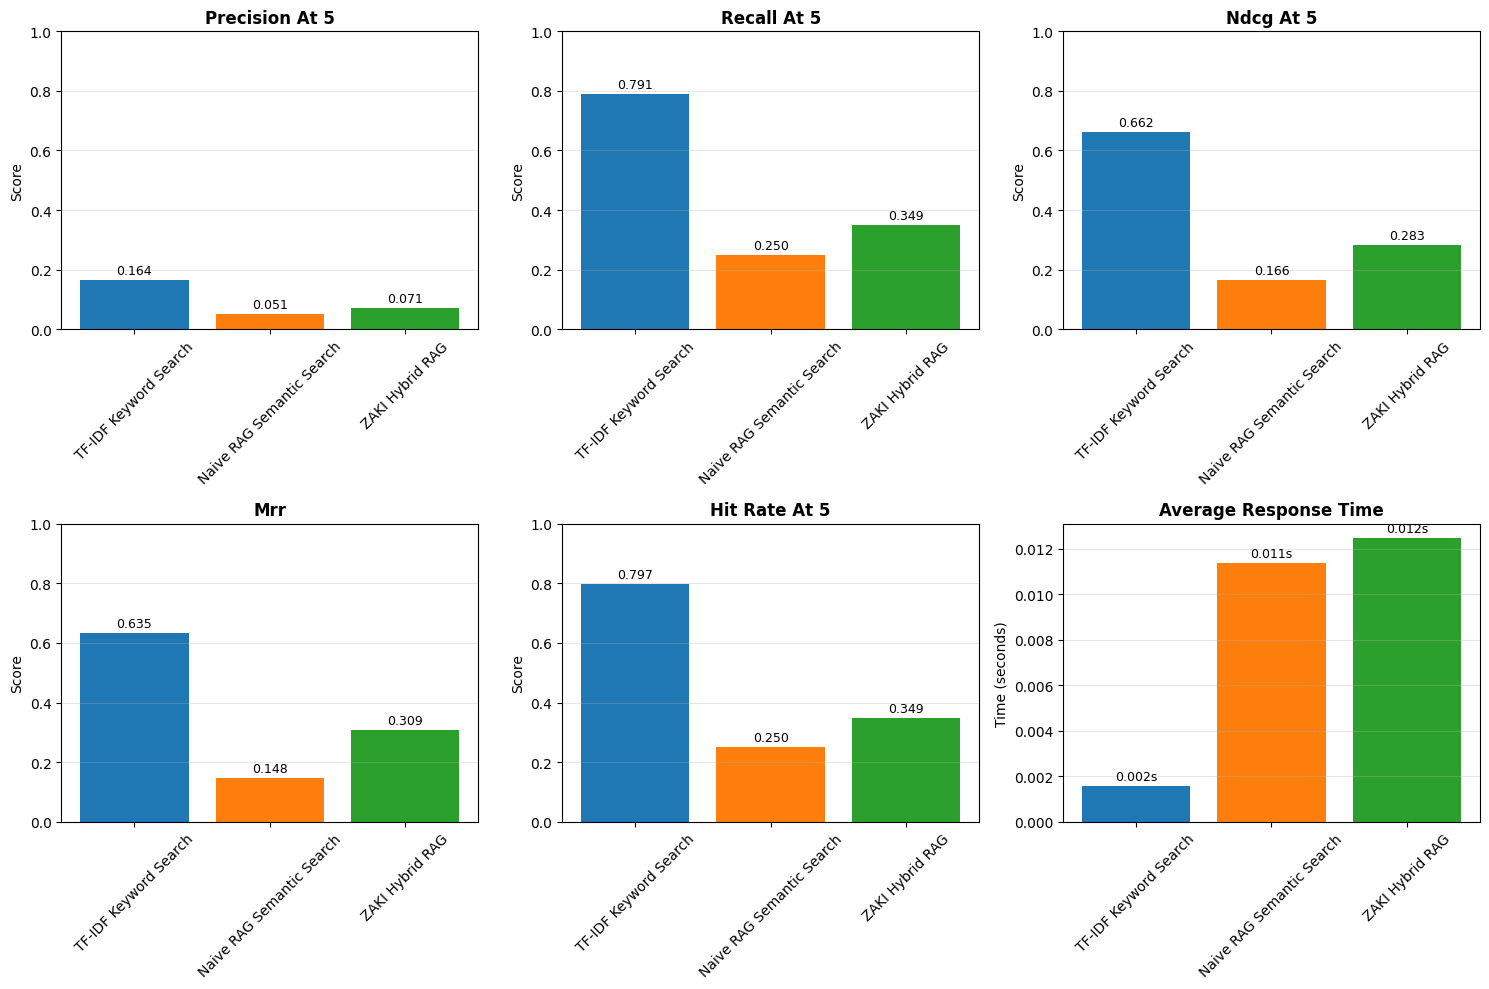


=== ANALISIS DETAIL ===

TF-IDF Keyword Search:
  Precision@5: 0.1640
  Recall@5: 0.7907
  NDCG@5: 0.6616
  MRR: 0.6350
  Hit Rate@5: 0.7965
  Avg Response Time: 0.002s
  Source Diversity: 0.1209

Naive RAG Semantic Search:
  Precision@5: 0.0512
  Recall@5: 0.2500
  NDCG@5: 0.1660
  MRR: 0.1476
  Hit Rate@5: 0.2500
  Avg Response Time: 0.011s
  Source Diversity: 0.1000

ZAKI Hybrid RAG:
  Precision@5: 0.0709
  Recall@5: 0.3488
  NDCG@5: 0.2827
  MRR: 0.3085
  Hit Rate@5: 0.3488
  Avg Response Time: 0.012s
  Source Diversity: 0.1035

Sistem terbaik berdasarkan NDCG@5: TF-IDF Keyword Search

Peningkatan ZAKI Hybrid RAG:
  vs TF-IDF: -57.3%
  vs Naive RAG: 70.4%


In [ ]:
print("=== LAPORAN PERBANDINGAN SISTEM ===")
comparison_report = evaluator.generate_comparison_report()
print(comparison_report)

# Visualisasi perbandingan
print("\n=== VISUALISASI PERBANDINGAN ===")
evaluator.visualize_comparison()

# Analisis detail per metrik
print("\n=== ANALISIS DETAIL ===")
for system_name, results in evaluator.results.items():
    print(f"\n{system_name}:")
    metrics = results['metrics']

    print(f"  Precision@5: {metrics['precision_at_5']:.4f}")
    print(f"  Recall@5: {metrics['recall_at_5']:.4f}")
    print(f"  NDCG@5: {metrics['ndcg_at_5']:.4f}")
    print(f"  MRR: {metrics['mrr']:.4f}")
    print(f"  Hit Rate@5: {metrics['hit_rate_at_5']:.4f}")
    print(f"  Avg Response Time: {metrics['avg_response_time']:.3f}s")
    print(f"  Source Diversity: {metrics['source_diversity']:.4f}")

# Identifikasi sistem terbaik
best_system = max(evaluator.results.keys(),
                 key=lambda x: evaluator.results[x]['metrics']['ndcg_at_5'])
print(f"\nSistem terbaik berdasarkan NDCG@5: {best_system}")

# Improvement analysis
if len(evaluator.results) >= 2:
    zaki_ndcg = evaluator.results["ZAKI Hybrid RAG"]['metrics']['ndcg_at_5']
    tfidf_ndcg = evaluator.results["TF-IDF Keyword Search"]['metrics']['ndcg_at_5']
    naive_ndcg = evaluator.results["Naive RAG Semantic Search"]['metrics']['ndcg_at_5']

    improvement_over_tfidf = ((zaki_ndcg - tfidf_ndcg) / tfidf_ndcg) * 100
    improvement_over_naive = ((zaki_ndcg - naive_ndcg) / naive_ndcg) * 100

    print(f"\nPeningkatan ZAKI Hybrid RAG:")
    print(f"  vs TF-IDF: {improvement_over_tfidf:.1f}%")
    print(f"  vs Naive RAG: {improvement_over_naive:.1f}%")


## Analisis Error dan Failure Cases

In [ ]:
def analyze_failure_cases():
    """Analisis kasus di mana sistem gagal atau performa rendah"""
    print("=== ANALISIS FAILURE CASES ===")

    for system_name, results in evaluator.results.items():
        print(f"\n{system_name}:")

        failed_queries = []
        for query_result in results['query_results']:
            query = query_result['query']
            retrieved_docs = [r['document_id'] for r in query_result['results'][:5]]
            relevant_docs = query_result['relevant_docs']

            # Hitung precision@5 untuk query ini
            precision = len(set(retrieved_docs) & set(relevant_docs)) / len(retrieved_docs) if retrieved_docs else 0

            if precision < 0.2:  # Threshold untuk failure case
                failed_queries.append({
                    'query': query,
                    'precision': precision,
                    'retrieved': retrieved_docs,
                    'relevant': relevant_docs
                })

        if failed_queries:
            print(f"  Failure cases: {len(failed_queries)}")
            for case in failed_queries[:3]:  # Tampilkan 3 terburuk
                print(f"    - Query: {case['query'][:50]}...")
                print(f"      Precision: {case['precision']:.3f}")
        else:
            print("  No significant failure cases")

# Jalankan analisis failure cases
analyze_failure_cases()


In [ ]:
def test_individual_query(query_text, display_results=True):
    """Test query individual pada semua sistem"""
    print(f"=== TESTING QUERY: {query_text} ===")

    systems = [
        ("TF-IDF", tfidf_baseline),
        ("Naive RAG", naive_rag_baseline),
        ("ZAKI Hybrid", zaki_hybrid)
    ]

    for system_name, system in systems:
        print(f"\n{system_name} Results:")
        results = system.search(query_text, top_k=5)

        for i, result in enumerate(results[:3]):  # Tampilkan top 3
            print(f"  {i+1}. Score: {result['score']:.4f}")
            print(f"     Text: {result['text'][:100]}...")
            print(f"     Source: {result['metadata'].get('doc_type', 'unknown')}")

# Test beberapa query individual
test_queries_sample = [
    "Apa kewajiban zakat menurut Al-Qur'an?",
    "Bagaimana peran BAZNAS dalam pengelolaan zakat?",
    "Siapa yang wajib membayar zakat?"
]

for query in test_queries_sample:
    test_individual_query(query)
    print("\n" + "="*60 + "\n")


# PDF Knowledge Base Baru

In [ ]:
!pip install PyPDF2 langchain-text-splitters tiktoken unidecode
!pip install langchain langchain-text-splitters langchain-community

import PyPDF2
import pandas as pd
import re
import unicodedata
from langchain_text_splitters import RecursiveCharacterTextSplitter
import tiktoken
from datetime import datetime
import hashlib
import os

Found existing installation: langchain 0.3.26
Uninstalling langchain-0.3.26:
  Successfully uninstalled langchain-0.3.26
  Using cached langchain-0.3.26-py3-none-any.whl.metadata (7.8 kB)
Using cached langchain-0.3.26-py3-none-any.whl (1.0 MB)


## PDF Text Extraction

In [ ]:
def extract_text_from_pdf(pdf_path):
    """
    Ekstrak teks dari file PDF
    """
    try:
        with open(pdf_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            text = ""

            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                page_text = page.extract_text()
                text += f"\n--- Page {page_num + 1} ---\n{page_text}"

            return text
    except Exception as e:
        print(f"Error extracting PDF: {e}")
        return None

def extract_metadata_from_pdf(pdf_path):
    """
    Ekstrak metadata dari PDF
    """
    try:
        with open(pdf_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            metadata = pdf_reader.metadata

            return {
                'title': metadata.get('/Title', ''),
                'author': metadata.get('/Author', ''),
                'subject': metadata.get('/Subject', ''),
                'creator': metadata.get('/Creator', ''),
                'producer': metadata.get('/Producer', ''),
                'creation_date': metadata.get('/CreationDate', ''),
                'modification_date': metadata.get('/ModDate', ''),
                'pages': len(pdf_reader.pages)
            }
    except Exception as e:
        print(f"Error extracting metadata: {e}")
        return {}

## Text Preprocessing dan Cleaning

In [ ]:
def clean_text(text):
    """
    Membersihkan dan menormalisasi teks
    """
    if not text:
        return ""

    # Normalisasi Unicode
    text = unicodedata.normalize('NFKC', text)

    # Hapus karakter kontrol dan non-printable
    text = ''.join(char for char in text if unicodedata.category(char)[0] != 'C')

    # Normalisasi whitespace
    text = re.sub(r'\s+', ' ', text)

    # Hapus page markers
    text = re.sub(r'--- Page \d+ ---', '', text)

    # Hapus header/footer yang berulang
    text = re.sub(r'(.*?)(\1\s*){3,}', r'\1', text, flags=re.MULTILINE)

    # Hapus nomor halaman standalone
    text = re.sub(r'^\s*\d+\s*$', '', text, flags=re.MULTILINE)

    # Normalisasi tanda baca
    text = re.sub(r'([.!?])\s*([.!?])+', r'\1', text)

    return text.strip()

def detect_document_type(text):
    """
    Deteksi jenis dokumen berdasarkan konten
    """
    text_lower = text.lower()

    if any(keyword in text_lower for keyword in ['peraturan', 'pasal', 'bab', 'ayat']):
        return 'regulation'
    elif any(keyword in text_lower for keyword in ['panduan', 'petunjuk', 'manual']):
        return 'guide'
    elif any(keyword in text_lower for keyword in ['laporan', 'report']):
        return 'report'
    elif any(keyword in text_lower for keyword in ['zakat', 'infak', 'sedekah']):
        return 'zakat_guide'
    else:
        return 'document'

def extract_title_from_content(text):
    """
    Ekstrak judul dari konten teks
    """
    lines = text.split('\n')

    # Cari baris yang kemungkinan judul (huruf kapital, pendek)
    for line in lines[:10]:  # Cek 10 baris pertama
        line = line.strip()
        if line and len(line) < 200 and line.isupper():
            return line
        elif line and len(line) < 100 and any(word.isupper() for word in line.split()):
            return line

    # Fallback: ambil baris pertama yang tidak kosong
    for line in lines:
        line = line.strip()
        if line and len(line) > 10:
            return line[:100] + "..." if len(line) > 100 else line

    return "Untitled Document"


## Text Chunking dengan Overlap

In [ ]:
class AdvancedTextChunker:
    def __init__(self, chunk_size=1000, chunk_overlap=200, separators=None):
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap

        if separators is None:
            self.separators = [
                "\n\n",      # Paragraph breaks
                "\n",        # Line breaks
                ". ",        # Sentence endings
                "! ",        # Exclamation
                "? ",        # Question
                "; ",        # Semicolon
                ", ",        # Comma
                " ",         # Space
                ""           # Fallback
            ]
        else:
            self.separators = separators

        # Initialize tokenizer for accurate token counting
        try:
            self.encoding = tiktoken.get_encoding("cl100k_base")
        except:
            self.encoding = None

    def count_tokens(self, text):
        """
        Count tokens menggunakan tiktoken jika tersedia
        """
        if self.encoding:
            return len(self.encoding.encode(text))
        else:
            # Fallback: estimate berdasarkan kata
            return len(text.split()) * 1.3

    def chunk_text(self, text):
        """
        Chunk teks dengan overlap dan preservasi konteks
        """
        if not text:
            return []

        # Jika teks sudah cukup kecil, return as is
        if self.count_tokens(text) <= self.chunk_size:
            return [text]

        chunks = []
        current_chunk = ""

        # Split berdasarkan separator secara hierarkis
        parts = self._split_text_hierarchical(text)

        for part in parts:
            # Cek apakah menambahkan part akan melebihi chunk_size
            test_chunk = current_chunk + ("\n" if current_chunk else "") + part

            if self.count_tokens(test_chunk) <= self.chunk_size:
                current_chunk = test_chunk
            else:
                # Simpan chunk saat ini jika tidak kosong
                if current_chunk:
                    chunks.append(current_chunk.strip())

                    # Mulai chunk baru dengan overlap
                    overlap_text = self._get_overlap_text(current_chunk)
                    current_chunk = overlap_text + ("\n" if overlap_text else "") + part
                else:
                    # Part terlalu besar, perlu dipecah lebih lanjut
                    sub_chunks = self._force_split_large_text(part)
                    chunks.extend(sub_chunks[:-1])
                    current_chunk = sub_chunks[-1] if sub_chunks else ""

        # Tambahkan chunk terakhir
        if current_chunk:
            chunks.append(current_chunk.strip())

        return chunks

    def _split_text_hierarchical(self, text):
        """
        Split teks secara hierarkis menggunakan separator
        """
        parts = [text]

        for separator in self.separators:
            new_parts = []
            for part in parts:
                if self.count_tokens(part) > self.chunk_size:
                    if separator in part:
                        split_parts = part.split(separator)
                        for i, split_part in enumerate(split_parts):
                            if i < len(split_parts) - 1:
                                split_part += separator
                            new_parts.append(split_part)
                    else:
                        new_parts.append(part)
                else:
                    new_parts.append(part)
            parts = new_parts

        return [part for part in parts if part.strip()]

    def _get_overlap_text(self, text):
        """
        Ambil bagian akhir teks untuk overlap
        """
        if not text:
            return ""

        words = text.split()
        if len(words) <= 10:
            return text

        # Ambil kata-kata terakhir untuk overlap
        overlap_words = words[-min(50, len(words) // 4):]
        overlap_text = " ".join(overlap_words)

        # Pastikan tidak melebihi chunk_overlap
        while self.count_tokens(overlap_text) > self.chunk_overlap and len(overlap_words) > 1:
            overlap_words = overlap_words[1:]
            overlap_text = " ".join(overlap_words)

        return overlap_text

    def _force_split_large_text(self, text):
        """
        Force split untuk teks yang terlalu besar
        """
        if not text:
            return []

        chunks = []
        words = text.split()
        current_words = []

        for word in words:
            test_chunk = " ".join(current_words + [word])

            if self.count_tokens(test_chunk) <= self.chunk_size:
                current_words.append(word)
            else:
                if current_words:
                    chunks.append(" ".join(current_words))
                current_words = [word]

        if current_words:
            chunks.append(" ".join(current_words))

        return chunks

# Inisialisasi chunker
chunker = AdvancedTextChunker(chunk_size=1000, chunk_overlap=200)

## Metadata Extraction

In [ ]:
def extract_structured_info(text):
    """
    Ekstrak informasi terstruktur dari teks
    """
    info = {
        'sections': [],
        'topics': [],
        'references': [],
        'entities': []
    }

    # Ekstrak section headers (BAB, Pasal, dll)
    section_pattern = r'(BAB|PASAL|Pasal|Bagian)\s+([IVX\d]+|[A-Z]+)?\s*[:\-]?\s*([^\n]+)'
    sections = re.findall(section_pattern, text, re.IGNORECASE)
    info['sections'] = [f"{match[0]} {match[1]} {match[2]}".strip() for match in sections]

    # Ekstrak topik zakat
    zakat_topics = ['zakat fitrah', 'zakat mal', 'zakat penghasilan', 'zakat emas', 'zakat perak', 'nisab', 'mustahiq']
    for topic in zakat_topics:
        if topic.lower() in text.lower():
            info['topics'].append(topic)

    # Ekstrak referensi Al-Qur'an
    quran_pattern = r'QS\.?\s*([A-Za-z\-\s]+):\s*(\d+)'
    quran_refs = re.findall(quran_pattern, text)
    info['references'] = [f"QS. {ref[0].strip()}:{ref[1]}" for ref in quran_refs]

    # Ekstrak entitas penting
    entities = ['BAZNAS', 'LAZ', 'UPZ', 'Kementerian Agama', 'Pemerintah']
    for entity in entities:
        if entity.lower() in text.lower():
            info['entities'].append(entity)

    return info

def generate_chunk_metadata(chunk_text, chunk_index, total_chunks, source_file, document_type):
    """
    Generate metadata untuk setiap chunk
    """
    structured_info = extract_structured_info(chunk_text)

    metadata = {
        'chunk_index': chunk_index,
        'total_chunks': total_chunks,
        'source_file': source_file,
        'document_type': document_type,
        'char_count': len(chunk_text),
        'word_count': len(chunk_text.split()),
        'sections': structured_info['sections'],
        'topics': structured_info['topics'],
        'references': structured_info['references'],
        'entities': structured_info['entities'],
        'created_at': datetime.now().isoformat(),
        'chunk_hash': hashlib.md5(chunk_text.encode()).hexdigest()
    }

    return metadata

## Main Processing Function

In [ ]:
def process_pdf_for_knowledge_base(pdf_path, source_name=None):
    """
    Proses PDF lengkap untuk knowledge base
    """
    print(f"Processing PDF: {pdf_path}")

    if source_name is None:
        source_name = os.path.basename(pdf_path)
    print("Extracting text from PDF...")
    raw_text = extract_text_from_pdf(pdf_path)

    if not raw_text:
        print("Failed to extract text from PDF")
        return None
    print("Extracting PDF metadata...")
    pdf_metadata = extract_metadata_from_pdf(pdf_path)
    print("Cleaning and preprocessing text...")
    cleaned_text = clean_text(raw_text)
    document_type = detect_document_type(cleaned_text)
    document_title = extract_title_from_content(cleaned_text)

    print(f"Document type: {document_type}")
    print(f"Document title: {document_title}")
    print(f"Text length: {len(cleaned_text)} characters")
    print("Chunking text...")
    chunks = chunker.chunk_text(cleaned_text)

    print(f"Created {len(chunks)} chunks")
    records = []

    for i, chunk in enumerate(chunks):
        # Generate metadata untuk chunk
        chunk_metadata = generate_chunk_metadata(
            chunk, i, len(chunks), source_name, document_type
        )

        record = {
            'content': chunk,
            'source_file': source_name,
            'document_type': document_type,
            'document_title': document_title,
            'chunk_index': i,
            'total_chunks': len(chunks),
            'char_count': len(chunk),
            'word_count': len(chunk.split()),
            'metadata': chunk_metadata,
            'pdf_metadata': pdf_metadata,
            'created_at': datetime.now().isoformat()
        }

        records.append(record)

    return records


## Upload ke Supabase

In [ ]:
from supabase import create_client, Client

SUPABASE_URL = userdata.get('SUPABASE_URL')
SUPABASE_KEY = userdata.get('SUPABASE_KEY')
client: Client = create_client(SUPABASE_URL, SUPABASE_KEY)

def upload_to_supabase(records, table_name="baznas_docs", batch_size=50):
    """
    Upload records ke Supabase dengan batch processing
    """
    print(f"Uploading {len(records)} records to Supabase table: {table_name}")

    uploaded_count = 0
    errors = []

    # Upload dalam batch untuk efisiensi
    for i in range(0, len(records), batch_size):
        batch = records[i:i + batch_size]

        try:
            result = client.table(table_name).insert(batch).execute()
            uploaded_count += len(batch)
            print(f"Uploaded batch {i//batch_size + 1}: {len(batch)} records")

        except Exception as e:
            error_msg = f"Error uploading batch {i//batch_size + 1}: {e}"
            print(error_msg)
            errors.append(error_msg)

    print(f"Upload completed: {uploaded_count}/{len(records)} records uploaded")

    if errors:
        print("Errors encountered:")
        for error in errors:
            print(f"  - {error}")

    return uploaded_count, errors

def validate_upload(table_name="baznas_docs", source_file=None):
    """
    Validasi hasil upload
    """
    try:
        if source_file:
            result = client.table(table_name).select("*").eq("source_file", source_file).execute()
        else:
            result = client.table(table_name).select("id", "source_file", "chunk_index").execute()

        print(f"Validation: Found {len(result.data)} records in {table_name}")
        return result.data

    except Exception as e:
        print(f"Validation error: {e}")
        return []

## Complete Workflow untuk PDF ke Supabase

In [ ]:
def pdf_to_supabase_workflow(pdf_path, table_name="baznas_docs", source_name=None):
    """
    Workflow lengkap dari PDF ke Supabase
    """
    try:
        # 1. Process PDF
        print("=" * 50)
        print("STARTING PDF TO SUPABASE WORKFLOW")
        print("=" * 50)

        records = process_pdf_for_knowledge_base(pdf_path, source_name)

        if not records:
            print("Failed to process PDF")
            return False

        # 2. Upload ke Supabase
        print("\n" + "=" * 30)
        print("UPLOADING TO SUPABASE")
        print("=" * 30)

        uploaded_count, errors = upload_to_supabase(records, table_name)

        # 3. Validate upload
        print("\n" + "=" * 20)
        print("VALIDATION")
        print("=" * 20)

        validation_records = validate_upload(table_name, source_name or os.path.basename(pdf_path))

        # 4. Summary report
        print("\n" + "=" * 30)
        print("WORKFLOW SUMMARY")
        print("=" * 30)
        print(f"PDF File: {pdf_path}")
        print(f"Source Name: {source_name or os.path.basename(pdf_path)}")
        print(f"Chunks Created: {len(records)}")
        print(f"Records Uploaded: {uploaded_count}")
        print(f"Upload Success Rate: {(uploaded_count/len(records)*100):.1f}%")
        print(f"Validation Records: {len(validation_records)}")

        if errors:
            print(f"Errors: {len(errors)}")
        else:
            print("Status: SUCCESS")

        return uploaded_count == len(records)

    except Exception as e:
        print(f"Workflow error: {e}")
        return False


## USAGE EXAMPLES

In [ ]:
# Example 1: Process single PDF
pdf_path = "/path/to/your/document.pdf"
success = pdf_to_supabase_workflow(
    pdf_path=pdf_path,
    table_name="baznas_docs",
    source_name="Peraturan_BAZNAS_2024.pdf"
)

# Example 2: Process multiple PDFs
pdf_files = [
    "/path/to/document1.pdf",
    "/path/to/document2.pdf",
    "/path/to/document3.pdf"
]

for pdf_file in pdf_files:
    print(f"\nProcessing: {pdf_file}")
    success = pdf_to_supabase_workflow(pdf_file, "baznas_docs")
    if not success:
        print(f"Failed to process: {pdf_file}")

# Example 3: Custom chunking parameters
custom_chunker = AdvancedTextChunker(
    chunk_size=1500,    # Larger chunks
    chunk_overlap=300   # More overlap
)

# Replace global chunker
chunker = custom_chunker

# Example 4: Upload to different table
pdf_to_supabase_workflow(
    pdf_path="hadits_collection.pdf",
    table_name="hadits_docs",  # Different table
    source_name="Hadits_Zakat_Collection.pdf"
)


In [ ]:
from google.colab import files
import os

# Upload file PDF
print("Silakan upload file PDF Anda...")
uploaded = files.upload()

# Process uploaded files
for filename in uploaded.keys():
    if filename.lower().endswith('.pdf'):
        print(f"Processing uploaded file: {filename}")

        success = pdf_to_supabase_workflow(
            filename,
            table_name="baznas_docs",
            source_name=filename
        )

        if success:
            print(f"{filename} uploaded to Supabase successfully!")
        else:
            print(f" Failed to upload {filename}")
    else:
        print(f" {filename} is not a PDF file, skipping...")


Silakan upload file PDF Anda...


Saving Riset Mendalam Tentang BAZNAS_.pdf to Riset Mendalam Tentang BAZNAS_ (2).pdf
Processing uploaded file: Riset Mendalam Tentang BAZNAS_ (2).pdf
STARTING PDF TO SUPABASE WORKFLOW
Processing PDF: Riset Mendalam Tentang BAZNAS_ (2).pdf
Extracting text from PDF...
Extracting PDF metadata...
Cleaning and preprocessing text...
Document type: regulation
Document title: AnalisisKomprehensifBAZNASIndonesiaRingkasanEksekutifBadanAmilZakatNasional(BAZNAS)merupakanpilarstr...
Text length: 30241 characters
Chunking text...
Workflow error: empty separator
 Failed to upload Riset Mendalam Tentang BAZNAS_ (2).pdf


# Fine-tuning Embedding Model

### Setup Fine-tuning Environment

In [ ]:
!pip install transformers datasets accelerate -U
!pip install sentence-transformers

import torch
from transformers import AutoModel, AutoTokenizer
from datasets import Dataset
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from tqdm.auto import tqdm
import random
import pandas as pd

### Prepare Data for Fine-tuning

In [ ]:
from sentence_transformers import InputExample
from torch.utils.data import DataLoader
import pandas as pd

print("Memulai persiapan data untuk fine-tuning...")

try:
    id_to_index_map = {meta['id']: i for i, meta in enumerate(all_metadata)}
    print("Peta ID string ke indeks numerik berhasil dibuat.")
except (TypeError, KeyError) as e:
    raise Exception(f"Error saat membuat peta ID: Pastikan 'all_metadata' adalah list of dictionaries dengan key 'id'. Error: {e}")

train_examples = []
for query_id, doc_ids_str in ground_truth.items():
    if query_id < len(test_queries):
        query = test_queries[query_id]

        for doc_id_str in doc_ids_str:
            numeric_index = id_to_index_map.get(doc_id_str)

            if numeric_index is not None:
                positive_passage = all_docs[numeric_index]
                train_examples.append(InputExample(texts=[query, positive_passage]))

print(f" Berhasil membuat {len(train_examples)} pasangan data training positif.")

Memulai persiapan data untuk fine-tuning...
Peta ID string ke indeks numerik berhasil dibuat.
 Berhasil membuat 180 pasangan data training positif.


### Load Model dan Setup Training

In [ ]:
from sentence_transformers import SentenceTransformer, losses
from torch.utils.data import DataLoader
model_name = 'indobenchmark/indobert-base-p2'
print(f"Memuat model dasar: {model_name}")
model = SentenceTransformer(model_name)
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
print("Menggunakan MultipleNegativesRankingLoss sebagai loss function.")
train_loss = losses.MultipleNegativesRankingLoss(model=model)

Memuat model dasar: indobenchmark/indobert-base-p2
Menggunakan MultipleNegativesRankingLoss sebagai loss function.


### Start Fine-tuning

In [ ]:
import math
import os

num_epochs = 2
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)
output_path = "./finetuned-zaki-bert-v2"

print(f"Memulai fine-tuning selama {num_epochs} epoch...")
print(f"Model akan disimpan di: {output_path}")

model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path=output_path,
          show_progress_bar=True)

print(f"\n Fine-tuning selesai! Model baru tersimpan di '{output_path}'.")

Memulai fine-tuning selama 2 epoch...
Model akan disimpan di: ./finetuned-zaki-bert-v2


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: corefloral (corefloral-university-of-al-azhar-indonesia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss



 Fine-tuning selesai! Model baru tersimpan di './finetuned-zaki-bert-v2'.


### Load dan Gunakan Model Fine-tuned

In [ ]:
import faiss
from rank_bm25 import BM25Okapi

print(f"Memuat model yang sudah di-fine-tune dari: {output_path}")
finetuned_model = SentenceTransformer(output_path)

embedding_model = finetuned_model
print(" Variabel 'embedding_model' telah diperbarui dengan model hasil fine-tuning.")
print("\nMemulai pembangunan ulang indeks (FAISS & BM25)...")
print("Membuat embeddings baru...")
embeddings = embedding_model.encode(
    all_docs,
    show_progress_bar=True,
    normalize_embeddings=True,
    batch_size=16
)
embeddings = embeddings.astype("float32")
print("Membangun ulang FAISS index...")
dimension = embeddings.shape[1]
faiss_index = faiss.IndexHNSWFlat(dimension, 64)
faiss_index.hnsw.efConstruction = 200
faiss_index.add(embeddings)
print("Membangun ulang BM25 index...")
tokenized_docs = [doc.split() for doc in all_docs]
bm25_index = BM25Okapi(tokenized_docs)

print("\n Semua indeks berhasil diperbarui!")

Memuat model yang sudah di-fine-tune dari: ./finetuned-zaki-bert-v2
 Variabel 'embedding_model' telah diperbarui dengan model hasil fine-tuning.

Memulai pembangunan ulang indeks (FAISS & BM25)...
Membuat embeddings baru...


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Membangun ulang FAISS index...
Membangun ulang BM25 index...

 Semua indeks berhasil diperbarui!


## Analisis Hasil Setelah fine tuning

=== LAPORAN PERBANDINGAN SISTEM ===
                      System Precision@5 Recall@5  NDCG@5     MRR Hit Rate@5  \
0      TF-IDF Keyword Search      0.1640   0.7907  0.6616  0.6350     0.7965   
1  Naive RAG Semantic Search      0.0512   0.2500  0.1660  0.1476     0.2500   
2            ZAKI Hybrid RAG      0.1988   0.9535  0.8310  0.7988     0.9593   

  Avg Response Time Source Diversity  
0            0.002s           0.1209  
1            0.013s           0.1000  
2            0.014s           0.1070  

=== VISUALISASI PERBANDINGAN ===


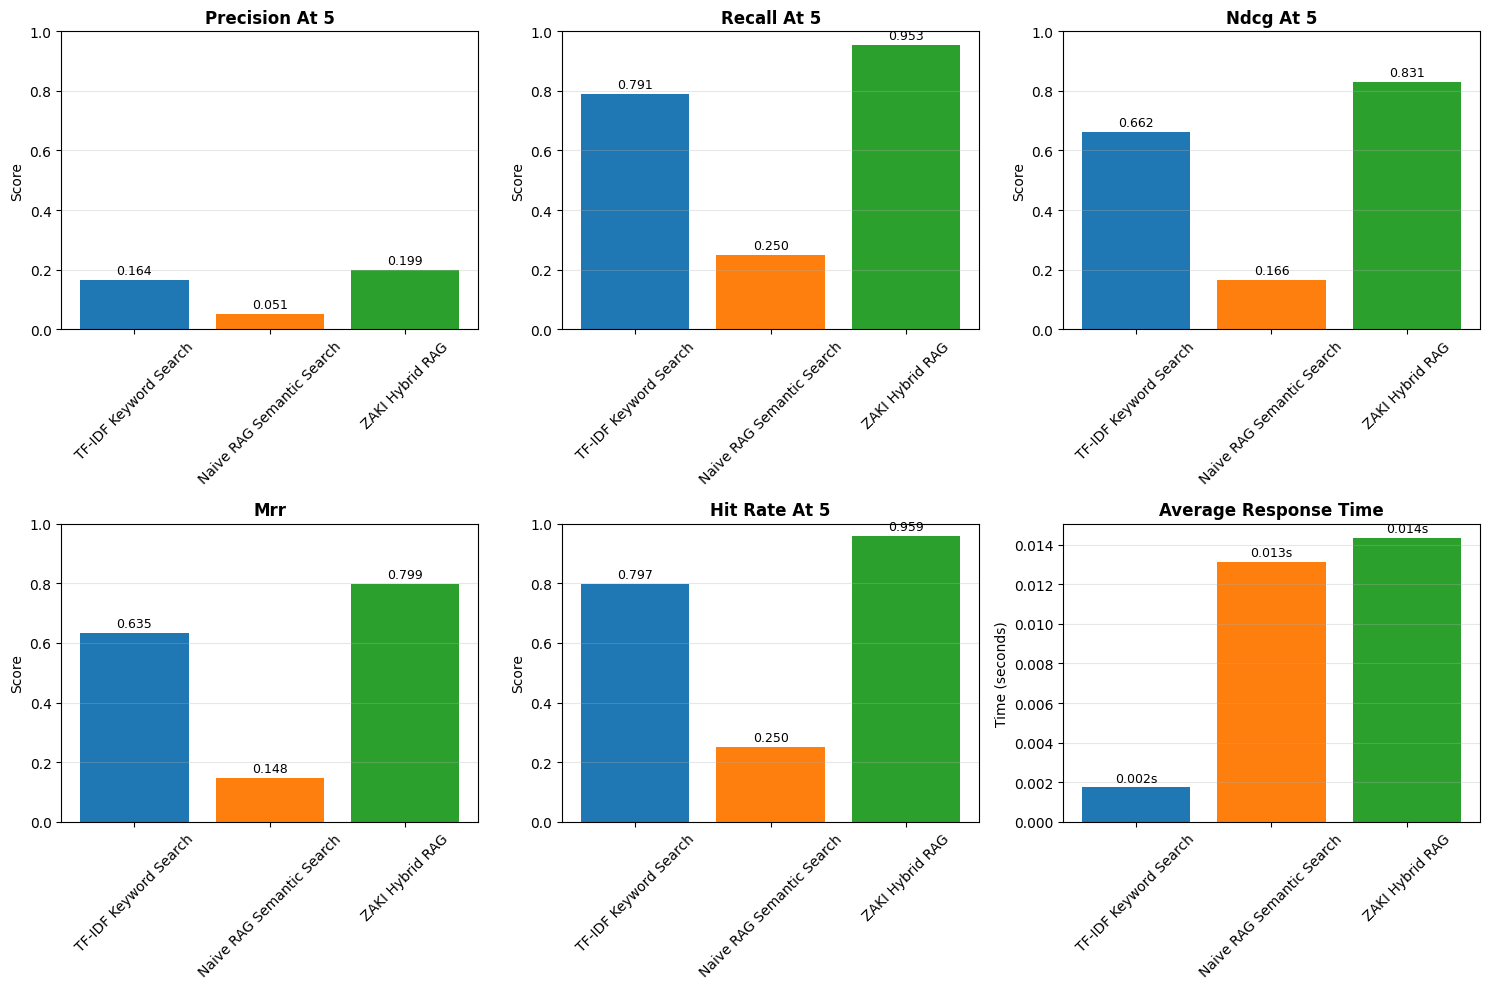


=== ANALISIS DETAIL ===

TF-IDF Keyword Search:
  Precision@5: 0.1640
  Recall@5: 0.7907
  NDCG@5: 0.6616
  MRR: 0.6350
  Hit Rate@5: 0.7965
  Avg Response Time: 0.002s
  Source Diversity: 0.1209

Naive RAG Semantic Search:
  Precision@5: 0.0512
  Recall@5: 0.2500
  NDCG@5: 0.1660
  MRR: 0.1476
  Hit Rate@5: 0.2500
  Avg Response Time: 0.013s
  Source Diversity: 0.1000

ZAKI Hybrid RAG:
  Precision@5: 0.1988
  Recall@5: 0.9535
  NDCG@5: 0.8310
  MRR: 0.7988
  Hit Rate@5: 0.9593
  Avg Response Time: 0.014s
  Source Diversity: 0.1070

Sistem terbaik berdasarkan NDCG@5: ZAKI Hybrid RAG

Peningkatan ZAKI Hybrid RAG:
  vs TF-IDF: 25.6%
  vs Naive RAG: 400.7%


In [ ]:
print("=== LAPORAN PERBANDINGAN SISTEM ===")
comparison_report = evaluator.generate_comparison_report()
print(comparison_report)

# Visualisasi perbandingan
print("\n=== VISUALISASI PERBANDINGAN ===")
evaluator.visualize_comparison()

# Analisis detail per metrik
print("\n=== ANALISIS DETAIL ===")
for system_name, results in evaluator.results.items():
    print(f"\n{system_name}:")
    metrics = results['metrics']

    print(f"  Precision@5: {metrics['precision_at_5']:.4f}")
    print(f"  Recall@5: {metrics['recall_at_5']:.4f}")
    print(f"  NDCG@5: {metrics['ndcg_at_5']:.4f}")
    print(f"  MRR: {metrics['mrr']:.4f}")
    print(f"  Hit Rate@5: {metrics['hit_rate_at_5']:.4f}")
    print(f"  Avg Response Time: {metrics['avg_response_time']:.3f}s")
    print(f"  Source Diversity: {metrics['source_diversity']:.4f}")

best_system = max(evaluator.results.keys(),
                 key=lambda x: evaluator.results[x]['metrics']['ndcg_at_5'])
print(f"\nSistem terbaik berdasarkan NDCG@5: {best_system}")

# Improvement analysis
if len(evaluator.results) >= 2:
    zaki_ndcg = evaluator.results["ZAKI Hybrid RAG"]['metrics']['ndcg_at_5']
    tfidf_ndcg = evaluator.results["TF-IDF Keyword Search"]['metrics']['ndcg_at_5']
    naive_ndcg = evaluator.results["Naive RAG Semantic Search"]['metrics']['ndcg_at_5']

    improvement_over_tfidf = ((zaki_ndcg - tfidf_ndcg) / tfidf_ndcg) * 100
    improvement_over_naive = ((zaki_ndcg - naive_ndcg) / naive_ndcg) * 100

    print(f"\nPeningkatan ZAKI Hybrid RAG:")
    print(f"  vs TF-IDF: {improvement_over_tfidf:.1f}%")
    print(f"  vs Naive RAG: {improvement_over_naive:.1f}%")


# Evaluasi Generator (RAGAS)

In [ ]:
!pip install -q --upgrade ragas

## Data Evaluasi RAGAS

In [ ]:
from datasets import Dataset

zaki_query_results = evaluator.results["ZAKI Hybrid RAG"]['query_results']

# Siapkan data dalam format yang dibutuhkan RAGAS
data_for_ragas = {
    'question': [],
    'answer': [],
    'contexts': [],
    'ground_truth': []
}

for i, result in enumerate(zaki_query_results[:5]): # Kita evaluasi 5 pertanyaan pertama sebagai contoh
    # 1. Ambil pertanyaan
    question = result['query']

    answer = generate_answer(question)

    retrieved_docs = zaki_hybrid.search(question, top_k=3) # Ambil top 3 konteks
    contexts = [doc['text'] for doc in retrieved_docs]

    relevant_doc_indices = ground_truth_numeric.get(i, [])
    ground_truth_text = "\\n".join([all_docs[idx] for idx in relevant_doc_indices])

    # Masukkan ke dictionary
    data_for_ragas['question'].append(question)
    data_for_ragas['answer'].append(answer)
    data_for_ragas['contexts'].append(contexts)
    data_for_ragas['ground_truth'].append(ground_truth_text)

# Konversi ke Hugging Face Dataset
ragas_dataset = Dataset.from_dict(data_for_ragas)

print("Dataset untuk evaluasi RAGAS siap!")

Mencari informasi untuk: Apa tujuan utama dari ditetapkannya Peraturan BAZNAS Nomor 2 Tahun 2019?
Ditemukan 15 kandidat dokumen
Dipilih 3 dokumen terbaik setelah Cross-Encoder rerank


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Jawaban berhasil dihasilkan
Mencari informasi untuk: Sebutkan Undang-Undang yang menjadi landasan hukum dari Peraturan BAZNAS Nomor 2 Tahun 2019.
Ditemukan 15 kandidat dokumen


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Dipilih 3 dokumen terbaik setelah Cross-Encoder rerank
Jawaban berhasil dihasilkan
Mencari informasi untuk: Siapakah Ketua BAZNAS RI yang menetapkan Peraturan BAZNAS Nomor 2 Tahun 2019?


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Ditemukan 15 kandidat dokumen
Dipilih 3 dokumen terbaik setelah Cross-Encoder rerank
Jawaban berhasil dihasilkan
Mencari informasi untuk: Kapan Peraturan BAZNAS Nomor 2 Tahun 2019 mulai berlaku?
Ditemukan 15 kandidat dokumen


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Dipilih 3 dokumen terbaik setelah Cross-Encoder rerank
Jawaban berhasil dihasilkan
Mencari informasi untuk: Apa perbedaan antara BAZNAS, BAZNAS Provinsi, dan BAZNAS Kabupaten/Kota menurut Peraturan BAZNAS No. 2 Tahun 2019?
Ditemukan 15 kandidat dokumen


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Dipilih 3 dokumen terbaik setelah Cross-Encoder rerank
Jawaban berhasil dihasilkan
Dataset untuk evaluasi RAGAS siap!


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


## Run Evaluasi RAGAS

In [ ]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)
from ragas.llms.langchain import LangchainChat
ragas_llm = LangchainChat(llm_sumopod)

metrics_to_evaluate = [
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
]

print("Menjalankan evaluasi RAGAS...")
result_ragas = evaluate(
    dataset=ragas_dataset,
    metrics=metrics_to_evaluate,
    llm=ragas_llm,
    is_async=False
)

print("Evaluasi RAGAS selesai!")
ragas_df = result_ragas.to_pandas()
print(ragas_df)

ModuleNotFoundError: No module named 'ragas.llms.langchain'